# Rating Detectives: Modeling Movie Ratings with Multidimensional Features 🔍

## Introduction
Welcome to the Rating Detectives Notebook! This notebook takes you behind the scenes of our data science journey, exploring the intricate factors that shape movie ratings. Through advanced feature engineering, statistical analysis, and machine learning, we investigate how movies resonate with audiences across time, regions, and genres.

We guide you through the process, from data collection and cleaning to exploratory analyses and predictive modeling. By combining traditional film attributes (e.g., release date, runtime, genre) with innovative features like historical event proximity scores and diversity metrics, we uncover the nuanced drivers behind movie ratings

Presentation of the Datasets
1. CMU Movie Summary Corpus

Files & Content:
movie.metadata.tsv: Metadata such as titles, genres, and release years.
character.metadata.csv: Information about characters and their attributes.
plot_summaries.txt: Narrative summaries of movie plots.
name.cluster.txt & tvtropes.cluster.txt: Clustering data and trope information.
Purpose in Analysis:
Forms the baseline dataset providing critical metadata and narrative context against which we can layer ratings, events, and demographic details.

2. IMDb Rating Dataset

Files & Content:
ratings_links.csv: IMDb average ratings and associated movie identifiers.
ratings_ratings.csv: Additional descriptive fields to link titles with their IMDb entries.
title.ratings.tsv:
Purpose in Analysis:
Supplies the target variable (IMDb ratings) and connects our metadata with ground-truth audience reception metrics.

3. Full TMDB Movies Dataset 2024:

Files & Content: 
TMDB_movie_dataset_v11.csv: Comprehensive metadata, including revenue, runtime, and release date, to enrich the CMU dataset.
Purpose in Analysis:
Enhances the metadata by integrating additional descriptive features, such as budget and runtime, to deepen the analysis. Also, used to link the IMDb ratings to the CMU ones.

4. Wikidata Dataset: 
File & content: wikidata_actor_info.csv :Supplementary dataset containing freebase IDs, nationalities, and missing ethnicity data for actors.
Purpose in Analysis:
Complements the character metadata by filling gaps in actor demographics, enabling a richer analysis of the influence of cast diversity on movie ratings.


## Research Questions:
- How do film ratings vary across regions and genres, and how has this evolved over time?
- What is the influence of cast demographics, including ethnicity and gender, on ratings?
- How have traditional genres blended into complex combinations of genres assigned to movies, and is this a relevant feature for predicting a movies average rating?
- Can we create a score to identify movies that are proximal in release date to significant regional cultural moments, and this score's impact on ratings?
- What novel features can be prepared to predict movie ratings based on available characters metadata?
- How accurately can we prepare a classification model to label the ratings of unlabelled movies using features identified as being correlated with movie ratings?
- What feature is the most informative in assigning a rating out of 10 to a given movie?

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# paths and processes imports
import ast
from pathlib import Path
import subprocess

# sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr, f_oneway

# statsmodels imports
from statsmodels.stats import diagnostic
import statsmodels.api as sm
from statsmodels.formula.api import ols

# src imports
from src.data.regions_clusters import regions, country_to_region, ethnicity_to_region
from src.scripts import ratings_statistics, ratings_visualizations, characters_features
from src.models import add_features
from src.utils import cleaning, filling
from src.utils.plots_standards import styles, genres_colors, regions_colors

# 0 - Data loading

In [2]:
# data path
DATA = './data/'

# src/data/ path
SRC_DATA = './src/data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
df_ratings_imdb = pd.read_csv(DATA + 'title.ratings.tsv', sep='\t')

The movies and characters dataset do require significant cleaning, as is presented below.

# 1 - Datasets wrangling

## 1.1 - Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [3]:
# df_movies has duplicates of the same movies based on their title which we will delete, only 5% of all data
df_movies = df_movies.drop_duplicates(subset=['title'])

In [4]:
# dropping duplicates on imdb_id column to avoid the creation of even more duplicates when merging 
df_tmdb = df_tmdb.drop_duplicates(subset=['imdb_id'])

In [5]:
# drop movies in each dataframe with missing release dates 
df_movies = df_movies.dropna(subset=['release_date'])
df_tmdb = df_tmdb.dropna(subset=['release_date'])

# cleaning dates format
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)
df_tmdb['release_date'] = df_tmdb['release_date'].apply(cleaning.clean_dates)

# unique indexes definition for subsequent merging
title_release_movies = df_movies.title + df_movies.release_date.astype(str)
title_release_tmdb = df_tmdb.title + df_tmdb.release_date.astype(str)

# copies of df_movies and df_tmdb for merging, with new index definition
df_movies_copy = df_movies.copy()
df_movies_copy.index = title_release_movies
df_tmdb_copy = df_tmdb.copy()
df_tmdb_copy.index = title_release_tmdb

# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies_copy, df_tmdb_copy, left_index=True, right_index=True)

# as the unique index of title and release date was used to merge the dataframes, the original title columns are duplicated and must be removed
df_movies_tmdb = df_movies_tmdb.drop(['title_y'], axis = 1).rename(columns={'title_x': 'title'}) 

# deleting temporary copies of df_movies and df_tmdb
del df_movies_copy
del df_tmdb_copy

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [6]:
# dropping some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [7]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [8]:
# using the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# dropping missing release dates, removing duplicate column and renaming 'release_date_x'
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [9]:
# using the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# removing duplicate column and renaming 'revenue_x'
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [10]:
# using the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# removing duplicate column and renaming 'runtime_x'
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [11]:
# removing movies with no genre reported, as this feature will be fundamental in subsequent analysis
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [12]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDb references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Using the ratings from IMDB to give a ratings feature to our metadata.

In [13]:
# IMDb references in df_ratings_imdb_id are formatted differently than in df_movies_tmdb
df_ratings_imdb['tconst'] = df_ratings_imdb['tconst'].apply(cleaning.clean_imdb)

# giving movie metadata ratings from IMDb mean ratings using TMDB as linker as it has IMDb ids of movies
df_movies_ratings_imdb = pd.merge(df_movies_tmdb, df_ratings_imdb, left_on='imdb_id', right_on='tconst')

In [14]:
# dropping many useless columns
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['id'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['status'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_average'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_count'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['backdrop_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['homepage'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['original_title'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['overview'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['popularity'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['poster_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tagline'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['keywords'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tconst'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['adult'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['production_countries'], axis = 1)

In [15]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_ratings_imdb = filling.fill_iqr(df_movies_ratings_imdb, 'runtime', 3.5)

In [16]:
# dropping missing 'countries' entries
df_movies_ratings_imdb.dropna(subset=['countries'], inplace=True)

# evaluating movies with one country
country_1perc, country_1entries = cleaning.count_entries(df_movies_ratings_imdb, 'countries')

# printing the results
print(f"{country_1perc*100:.2f} % of our ratings-populated movie metadataset have only one country listed.")

# keeping movies with one country for further analysis
df_movies_ratings_imdb = country_1entries

# dropping counts column
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['counts'], axis = 1)

86.52 % of our ratings-populated movie metadataset have only one country listed.


Given most movies have only one country listed, the other movies with more than one country have been dropped to avoid redundancy of considering the same movie and thereby rating across regions.

In [17]:
# evaluating movies with 1 to 6 genres
percentages, subsets = cleaning.evaluate_genre_counts(df_movies_ratings_imdb, 'genres', 6)

# printing the results
for i in range(1, 7):
    print(f"{percentages[f'1_to_{i}_genre']*100:.2f} % of our ratings-populated movie metadataset have 1 to {i} genres listed.")

19.82 % of our ratings-populated movie metadataset have 1 to 1 genres listed.
39.23 % of our ratings-populated movie metadataset have 1 to 2 genres listed.
56.90 % of our ratings-populated movie metadataset have 1 to 3 genres listed.
72.01 % of our ratings-populated movie metadataset have 1 to 4 genres listed.
83.07 % of our ratings-populated movie metadataset have 1 to 5 genres listed.
90.43 % of our ratings-populated movie metadataset have 1 to 6 genres listed.


The majority of movies do not have one genre listed, so some way of handling this must be considered. One technique could be to explode the genre lists for multigenre movies, select for the top 20 (or some other value) most occurring genre, and then recombine the multigenre movies with only these relevant genres. However, considering we'd want to keep at least 90% of the movies which corresponds to movies having up to six genres, then in the 'worst-case' scenario there could be 6^20 possible recombinations of the top 20 genres. Our data would obviously not explore this entire combinatorial space, however, we would be analying hundreds of genres. Alternatively, the first genre listed in a movie's entry could be considered as the most relevant one and kept as the sole genre for multigenre movies. The issue here is we fear we are missing information about movies if we discard their other pertinent genres. Instead, we opt to explode all movies genres, then select for the top 20 most occurring genres, then preserve only movie entries with one of those top 20 genres listed.

In [18]:
# exploding genres
df_movies_ratings_imdb = df_movies_ratings_imdb.explode("genres")

# the genres column needs cleaning to ensure the same genres aren't doubled in a different format
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.lower()

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" film", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" movies", "")

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("[", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("]", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("'", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace('"', "")

In [19]:
# identifying the 20 most common single genres over all movies
genre_counts = df_movies_ratings_imdb['genres'].value_counts()

# getting the top 20 genres as a list
top_20_genres = genre_counts.head(20).index.tolist()

# removing irrelevant genre rows from the movies metadataset
df_movies_ratings_imdb = df_movies_ratings_imdb[df_movies_ratings_imdb['genres'].isin(top_20_genres)]

In [20]:
# the 'spoken_languages', 'countries' and 'genres' columns needs to quickly be cleaned
df_movies_ratings_imdb["spoken_languages"] = df_movies_ratings_imdb["spoken_languages"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["countries"] = df_movies_ratings_imdb["countries"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.capitalize()

# capitalizing top_20_genres list
top_20_genres = [item.capitalize() for item in top_20_genres]

In [21]:
# final ordering of the standard dataframe
df_movies_ratings_imdb = df_movies_ratings_imdb.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_ratings_imdb['revenue'] = df_movies_ratings_imdb['revenue'].replace(0.0, None)

# converting 'revenue' column to numeric values, raise error message in case of problems
df_movies_ratings_imdb['revenue'] = pd.to_numeric(df_movies_ratings_imdb['revenue'], errors='coerce')

In [22]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_ratings_imdb['budget'] = df_movies_ratings_imdb['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `revenue`, `production_companies`, `spoken_languages` (recall that `'original_language'` with 0% missing data is available).

In [23]:
print(f"There are now {len(df_movies_ratings_imdb['title'].unique())} unique movies in the standard movies dataset.")
print(f"There were {len(df_movies)} unique movies in the initial movies dataset.")

There are now 32972 unique movies in the standard movies dataset.
There were 68978 unique movies in the initial movies dataset.


Part of our analysis involves considering geographical groupings, which have been manually clustered by production region. Therefore, we will now add the `region` column to the Master Dataframe.

In [24]:
# mapping the 'countries' column to the 'region' column
df_movies_ratings_imdb['region'] = df_movies_ratings_imdb['countries'].map(country_to_region)

# entries for which a region was not assigned are dropped
df_movies_ratings_imdb = df_movies_ratings_imdb.dropna(subset=['region'])

In [25]:
# a dataframe with unique movie titles is now defined and will be used alongside df_movies_ratings_imdb
df_movies_ratings_imdb_unique = cleaning.drop_most_missing(df_movies_ratings_imdb, ['title'])

# drop 'missing_values' column of df_movies_ratings_imdb
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_ratings_imdb_unique = df_movies_ratings_imdb_unique.drop_duplicates(subset='title')

`df_movies_ratings_imdb` and `df_movies_ratings_imdb_unique` are now the master movies dataframes. In the following sections, these dataframes might undergo some modifications, therefore copies will be created at the beginning of each section to maintain the original datasets. The naming convention will be the following:
- `df_movies_ratings_imdb` --> `df_movies_###`, where `###` represents the section (e.g. `###` = `visuals` for section 2);
- `df_movies_ratings_imdb_unique` --> `df_movies_###_unique`

## 1.2 - Characters dataset wrangling

In [26]:
# cleaning characters 'release_date' and 'actor_birth' to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

The datastory will have a focus on actor ethnicity as an important feature, therefore particular attention is payed to the related columns in `df_characters`.

In [27]:
# counting the number of unique values in 'actor_ethnicity', excluding NaN
print(f"Number of unique ethnicities in 'actor_ethnicity': {df_characters['actor_ethnicity'].nunique(dropna=True)} \n")

# counting the number of NaN values in 'actor_ethnicity'
print(f"Number of NaN values in 'actor_ethnicity': {df_characters['actor_ethnicity'].isna().sum()}")

# total number of entries in 'actor_ethnicity' column
print(f"Total entries in 'actor_ethnicity': {len(df_characters['actor_ethnicity'])}")

# nan entries proportion
nan_proportion_ethnicity = df_characters['actor_ethnicity'].isna().sum() / len(df_characters['actor_ethnicity'])
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")

Number of unique ethnicities in 'actor_ethnicity': 479 

Number of NaN values in 'actor_ethnicity': 344611
Total entries in 'actor_ethnicity': 450669
Proportion of NaN values in 'actor_ethnicity': 76.47%


In [28]:
# counting the number of unique actors who have a non-NaN ethnicity
print(f"Unique actors who have an ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['actor_name'].nunique()}")

# counting the number of unique actors in total
print(f"Total number of unique actors: {df_characters['actor_name'].nunique()} \n")

# counting the number of unique movies (using either 'freebase_id' or 'wikipedia_id')
print(f"Total number of unique movies: {df_characters['freebase_id'].nunique()}")

# counting the number of unique movies with at least one actor who has a specified ethnicity
print(f"Unique movies with at least one actor with ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['freebase_id'].nunique() }")

Unique actors who have an ethnicity: 8148
Total number of unique actors: 134078 

Total number of unique movies: 64330
Unique movies with at least one actor with ethnicity: 37958


Actors' ethnicities are in the format of Freebase IDs. To translate them, these unique IDs have been saved in a `.txt` file, which has been translated using `query.wikidata.org` by executing the following SPARQL request:

```sparql
SELECT DISTINCT ?freebase_id ?wikidata_id ?label WHERE {
  VALUES ?freebase_id {
    "/m/05bzpzx" "/m/064rb5l" "/m/01km_m" "/m/059v8" "/m/03b_13l" "/m/09c8kp" "/m/05ztd1" 
    "/m/04c28" "/m/03sk2" "/m/04jtjvt" "/m/03hjx6f" "/m/027936c" "/m/03nvq" "/m/03nz70" 
    "/m/01g3rx" "/m/02wz7j" "/m/04kdwcx" "/m/04_8lfc" "/m/033qt1" "/m/08j1fb" "/m/07wsyr" 
    "/m/06vb7b" "/m/012fh" "/m/0dm3xpw" "/m/09r2kh" "/m/02ry8mk" "/m/029q52" "/m/026d074" 
    "/m/013y54"
    # Add more IDs as needed
  }
  ?wikidata_id wdt:P646 ?freebase_id.
  ?wikidata_id rdfs:label ?label.
  FILTER(LANG(?label) = "en")
}

The creation of the `.txt` file is achieved by `src/data/freebase_to_batches.py` and the result is `src/data/unique_actor_ethnicities_batexhes.txt`. The outputs from query.wikidata.org have been saved in a .csv file (`freebaseids_labels.csv`).

In [29]:
# reading the .csv and saving it to a dataframe
df_labels = pd.read_csv(SRC_DATA + 'freebaseids_label.csv')
df_labels.columns = ['freebase_id', 'wikipedia_id', 'label']  

# mapping dictionary definition
freebase_to_label = dict(zip(df_labels['freebase_id'], df_labels['label']))

# creating 'ethnicity_label' column where to map the freebse ethnicity Ids to the corresponding labels
df_characters['ethnicity_label'] = df_characters['actor_ethnicity'].map(freebase_to_label)

In [30]:
# calculating the proportion of nans in 'ethnicity_label'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])

# checking if any information have been lost during the ids-label translation
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")
print(f"Proportion of NaN values in 'ethnicity_label': {nan_proportion_label:.2%}")

Proportion of NaN values in 'actor_ethnicity': 76.47%
Proportion of NaN values in 'ethnicity_label': 77.17%


### 1.2.1 - Clustering ethnicities & adding nationalities and ethnicities from Wikidata

In [31]:
# loading the dictionary from the .txt file
with open(SRC_DATA + "ethnicities_clusters.txt", "r") as file:
    ethnicities_clusters = ast.literal_eval(file.read())

In [32]:
# defining the ethnicity_to_clusters dictionary
ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        # checking if the label is already in the dictionary
        if label not in ethnicity_to_clusters:
            # init a new empty list
            ethnicity_to_clusters[label] = []
        # adding the cluster if not already in the list to avoid duplicates
        if cluster not in ethnicity_to_clusters[label]:
            ethnicity_to_clusters[label].append(cluster)

# mapping each character's ethnicity to its unique clusters
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity_to_clusters.get(ethnicity, [])
)

In [33]:
# searching unique ethnicity labels where 'mapped_clusters' is missing
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].isna()]['ethnicity_label'].unique()

Since the labels are still incomplete for a large part, information from wikidata is adopted to enrich the `df_characters` dataframe. For each actor (using his freebase_id), a query has been requested to retrieve ethnicity or nationality if available. Everything is saved in `wikidata_actor_info.csv`.

In [34]:
# reading the .csv as a dataframe
df_wikidata = pd.read_csv(SRC_DATA + 'wikidata_actor_info.csv', sep=',')

# left merging df_characters and df_wikidata
df_characters = pd.merge(df_characters, df_wikidata, left_on="freebase_actor_id", right_on="freebaseID", how="left")

In [35]:
# filling 'ethnicity_label', where necessary, with the new labels extracted from wikidata
# (either 'ethnicityLabel' or 'nationalityLabel' if the first is nan or ambiguous)
df_characters['ethnicity_label'] = df_characters.apply(
    lambda row: filling.fill_ethnicity(row, unmatched_ethnicities),
    axis=1
)

# printing the final results
print(f"Before filling, the proportion of NaN values in 'ethnicity_label' was: {nan_proportion_label:.2%}")

# re-computing the proportion of nan in 'ethnicity_labels'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])
print(f"After filling, the proportion of NaN values in 'ethnicity_label' is: {nan_proportion_label:.2%}")

Before filling, the proportion of NaN values in 'ethnicity_label' was: 77.17%
After filling, the proportion of NaN values in 'ethnicity_label' is: 36.54%


The proportion of missing values in `'ethnicity_label'` has been halved through filling it with wikidata information. This allows to save a big part of the original dataframe when dropping nan values in the `'ethnicity_label'` column. Now, new ethnicities can be mapped to the clusters in `ethnicities_clusters.txt` file, after updating the latter. Note that, for simplicity, only the last updated version of this file is stored in `/src/data/`, therefore also in the first clustering this version has been adopted. 

In [36]:
# defining the new ethnicity_to_clusters dictionary
ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        ethnicity_to_clusters.setdefault(label, []).append(cluster)

# updating the 'mapped_clusters' column
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: list(set(ethnicity_to_clusters.get(ethnicity, [])))
)

In [37]:
# identifying unmatched ethnicity labels
unmatched_ethnicities = df_characters[df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity not in ethnicity_to_clusters
)]['ethnicity_label']

# counting occurrences of unmatched ethnicity labels
unmatched_ethnicities_counts = unmatched_ethnicities.value_counts()

# printing the total number of unique unmatched ethnicity labels
print(f"Number of unmatched ethnicity labels: {unmatched_ethnicities_counts.shape[0]}")

# printing unmatched ethnicity labels with their counts
print("Unmatched ethnicity labels and their counts:")
print(unmatched_ethnicities_counts)

Number of unmatched ethnicity labels: 6
Unmatched ethnicity labels and their counts:
ethnicity_label
مسح                        9
multiracial people         4
Q25589681                  4
Karay-a people             2
Bohemian People            1
peoples of the Caucasus    1
Name: count, dtype: int64


When clustering ethnicities, we encountered challenges with ambiguous or mixed ethnicities and nationalities. While we assigned most of them to specific categories, a small number remained unassigned. Due to their low occurrence, we chose to exclude these entries from our analysis.

In [38]:
# dropping useless columns
df_characters = df_characters.drop(['freebaseID'], axis = 1)
df_characters = df_characters.drop(['actorLabel'], axis = 1)
df_characters = df_characters.drop(['ethnicityLabel'], axis = 1)
df_characters = df_characters.drop(['nationalityLabel'], axis = 1)
df_characters = df_characters.drop(['ethnicity_label'], axis = 1)
df_characters = df_characters.drop(['freebase_character_id'], axis = 1)
df_characters = df_characters.drop(['freebase_map'], axis = 1)
df_characters = df_characters.drop(['actor_height'], axis = 1)
df_characters = df_characters.drop(['character_name'], axis = 1)
df_characters = df_characters.drop(['actor_ethnicity'], axis = 1)
df_characters = df_characters.drop(['freebase_id'], axis = 1)

In [39]:
# renaming mapped cluster column
df_characters = df_characters.rename(columns={'mapped_clusters': 'actor_ethnicity'})
df_characters.head()

wikipedia_id  release_date  actor_birth actor_gender          actor_name  \
0        975900        2001.0       1958.0            F      Wanda De Jesus   
1        975900        2001.0       1974.0            F  Natasha Henstridge   
2        975900        2001.0       1969.0            M            Ice Cube   
3        975900        2001.0       1967.0            M       Jason Statham   
4        975900        2001.0       1977.0            F         Clea DuVall   

   age_at_release freebase_actor_id  \
0            42.0        /m/03wcfv7   
1            27.0         /m/0346l4   
2            32.0        /m/01vw26l   
3            33.0         /m/034hyc   
4            23.0         /m/01y9xg   

                                actor_ethnicity  
0                             [North Americans]  
1                             [North Americans]  
2  [North Americans, South and Central African]  
3                               [West European]  
4                             [North Americans]

In [40]:
# deleting useless dfs
del df_labels
del df_wikidata
del unmatched_ethnicities

Similarly to what will be done for the master movies dataframes, also `df_characters` will be copied at the beginning of sections where it will be used following the same naming conventions as the movies datasets.

# 2 - Movies basic visuals

To begin analyzing the movie and characters datasets in their wrangled form, some general information about the movies dataframe are retrieved to better understand the underlying statistics of some important features.

In [41]:
# copies of the master dataframes to proceed with the analysis
df_movies_visuals = df_movies_ratings_imdb.copy()
df_movies_visuals_unique = df_movies_ratings_imdb_unique.copy()

The first graph plotted is the movie distribution by release date, to visualize how movie production evolved over time. Our data covers the years from 1888 until 2012, therefore, these range of years is plotted.

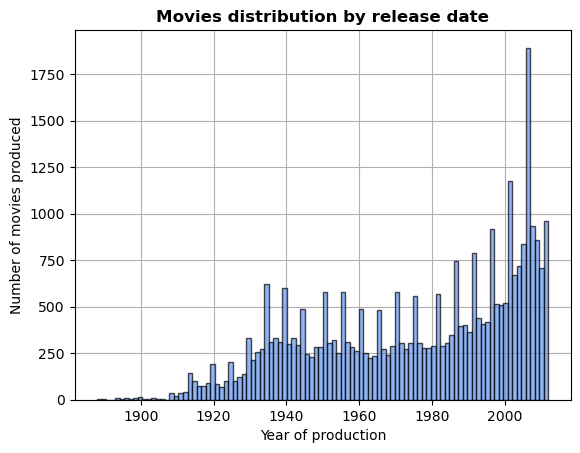

In [42]:
# movies distribution by release date
plt.figure()
plt.title('Movies distribution by release date', weight='bold')
plt.hist(df_movies_visuals_unique['release_date'], bins= 100, **styles['hist_style'], zorder=2)
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.grid(True, zorder=0)
plt.show()

From the graph above, it is clear the distinction between the 40s to 70s plateau and, from the 60s, the general tendency to produce more movies. Moreover, every few years peaks can be seen. 
A deeper analysis is needed, since this introductory graph does not include the region of production or specific genres.

Let us now retrieve more information about the `revenue`, `runtime` and `release_date` correlations.

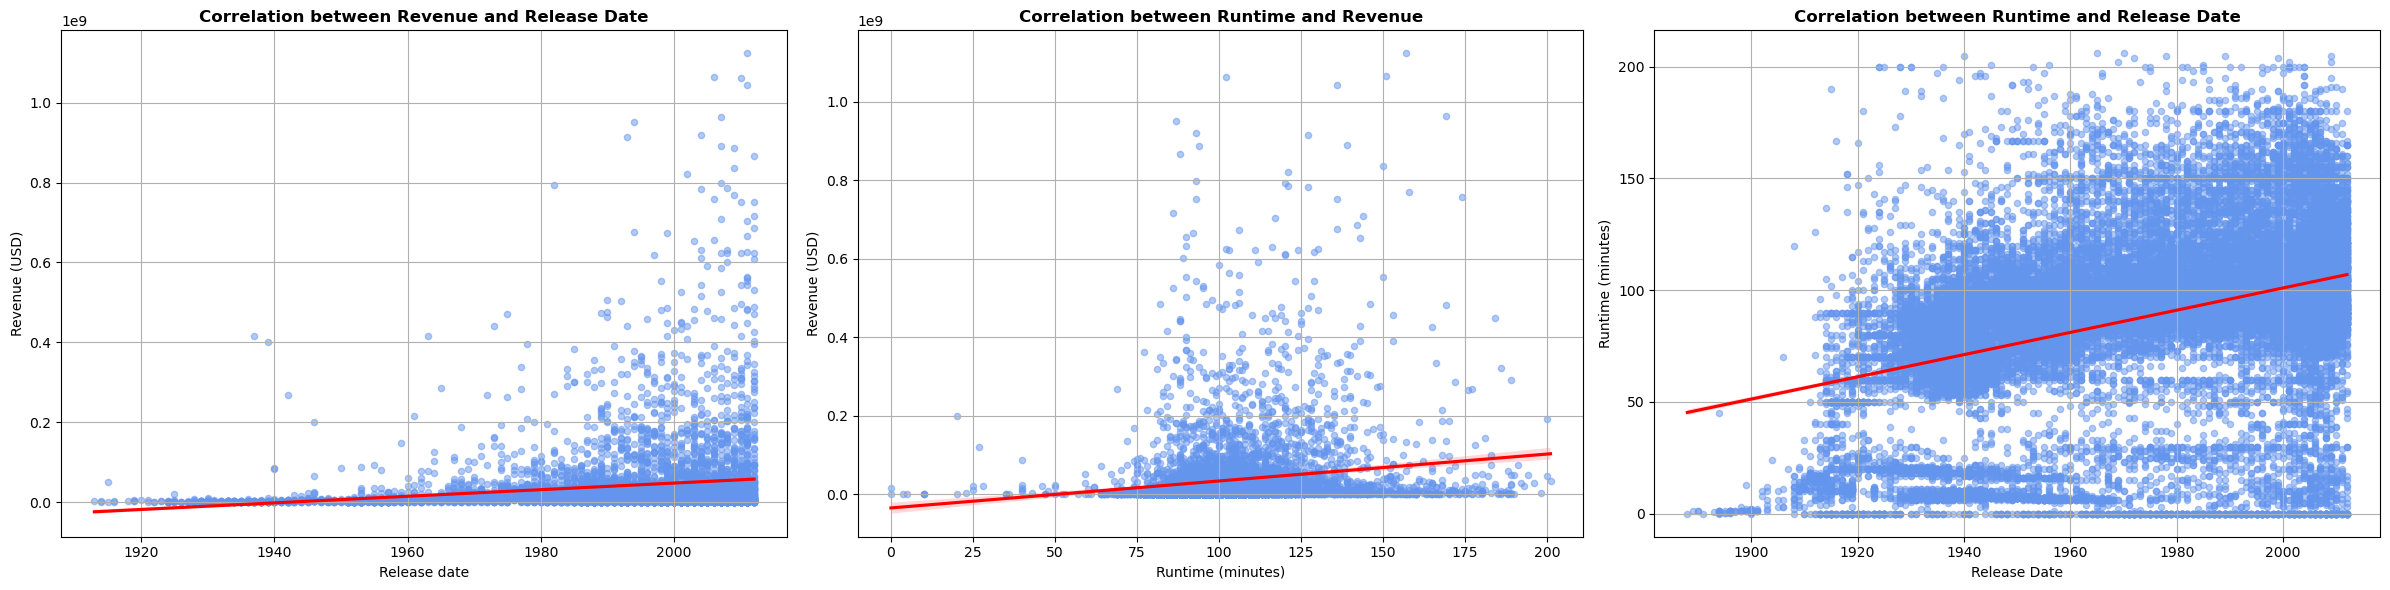

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# scatter-plot for release date vs revenue
sns.regplot(
    ax=axes[0],
    x='release_date',
    y='revenue',
    data=df_movies_visuals_unique,
    scatter_kws=styles['scatter_style'],
    line_kws=styles['line_style']
)
axes[0].set_title('Correlation between Revenue and Release Date', weight='bold')
axes[0].set_xlabel("Release date")
axes[0].set_ylabel("Revenue (USD)")
axes[0].grid(True)

# scatter-plot for runtime vs revenue
sns.regplot(
    ax=axes[1],
    x='runtime',
    y='revenue',
    data=df_movies_visuals_unique,
    scatter_kws=styles['scatter_style'],
    line_kws=styles['line_style']
)
axes[1].set_title('Correlation between Runtime and Revenue', weight='bold')
axes[1].set_xlabel("Runtime (minutes)")
axes[1].set_ylabel("Revenue (USD)")
axes[1].grid(True)

# scatter-plot for release date vs runtime
sns.regplot(
    ax=axes[2],
    x='release_date',
    y='runtime',
    data=df_movies_visuals_unique,
    scatter_kws=styles['scatter_style'],
    line_kws=styles['line_style']
)
axes[2].set_title('Correlation between Runtime and Release Date', weight='bold')
axes[2].set_xlabel("Release Date")
axes[2].set_ylabel("Runtime (minutes)")
axes[2].grid(True)

plt.tight_layout()
plt.show()

The 3 plots present very disperse values. However, the general trends highlighted in the red regressions are all positive. They indicate that both revenue and runtime increase with the release date: movies tend to be much longer and slightly more profitable over time. It is also showed how longer movies are generally more remunerative.

One of the main features of movies stored in the dataframe is the `genres` column. To better understand the evolution of the production of a certain movies genre, distributions are plotted. Only the 20 most relevant genres are taken into consideration, as explained in the cleaning section of the notebook.


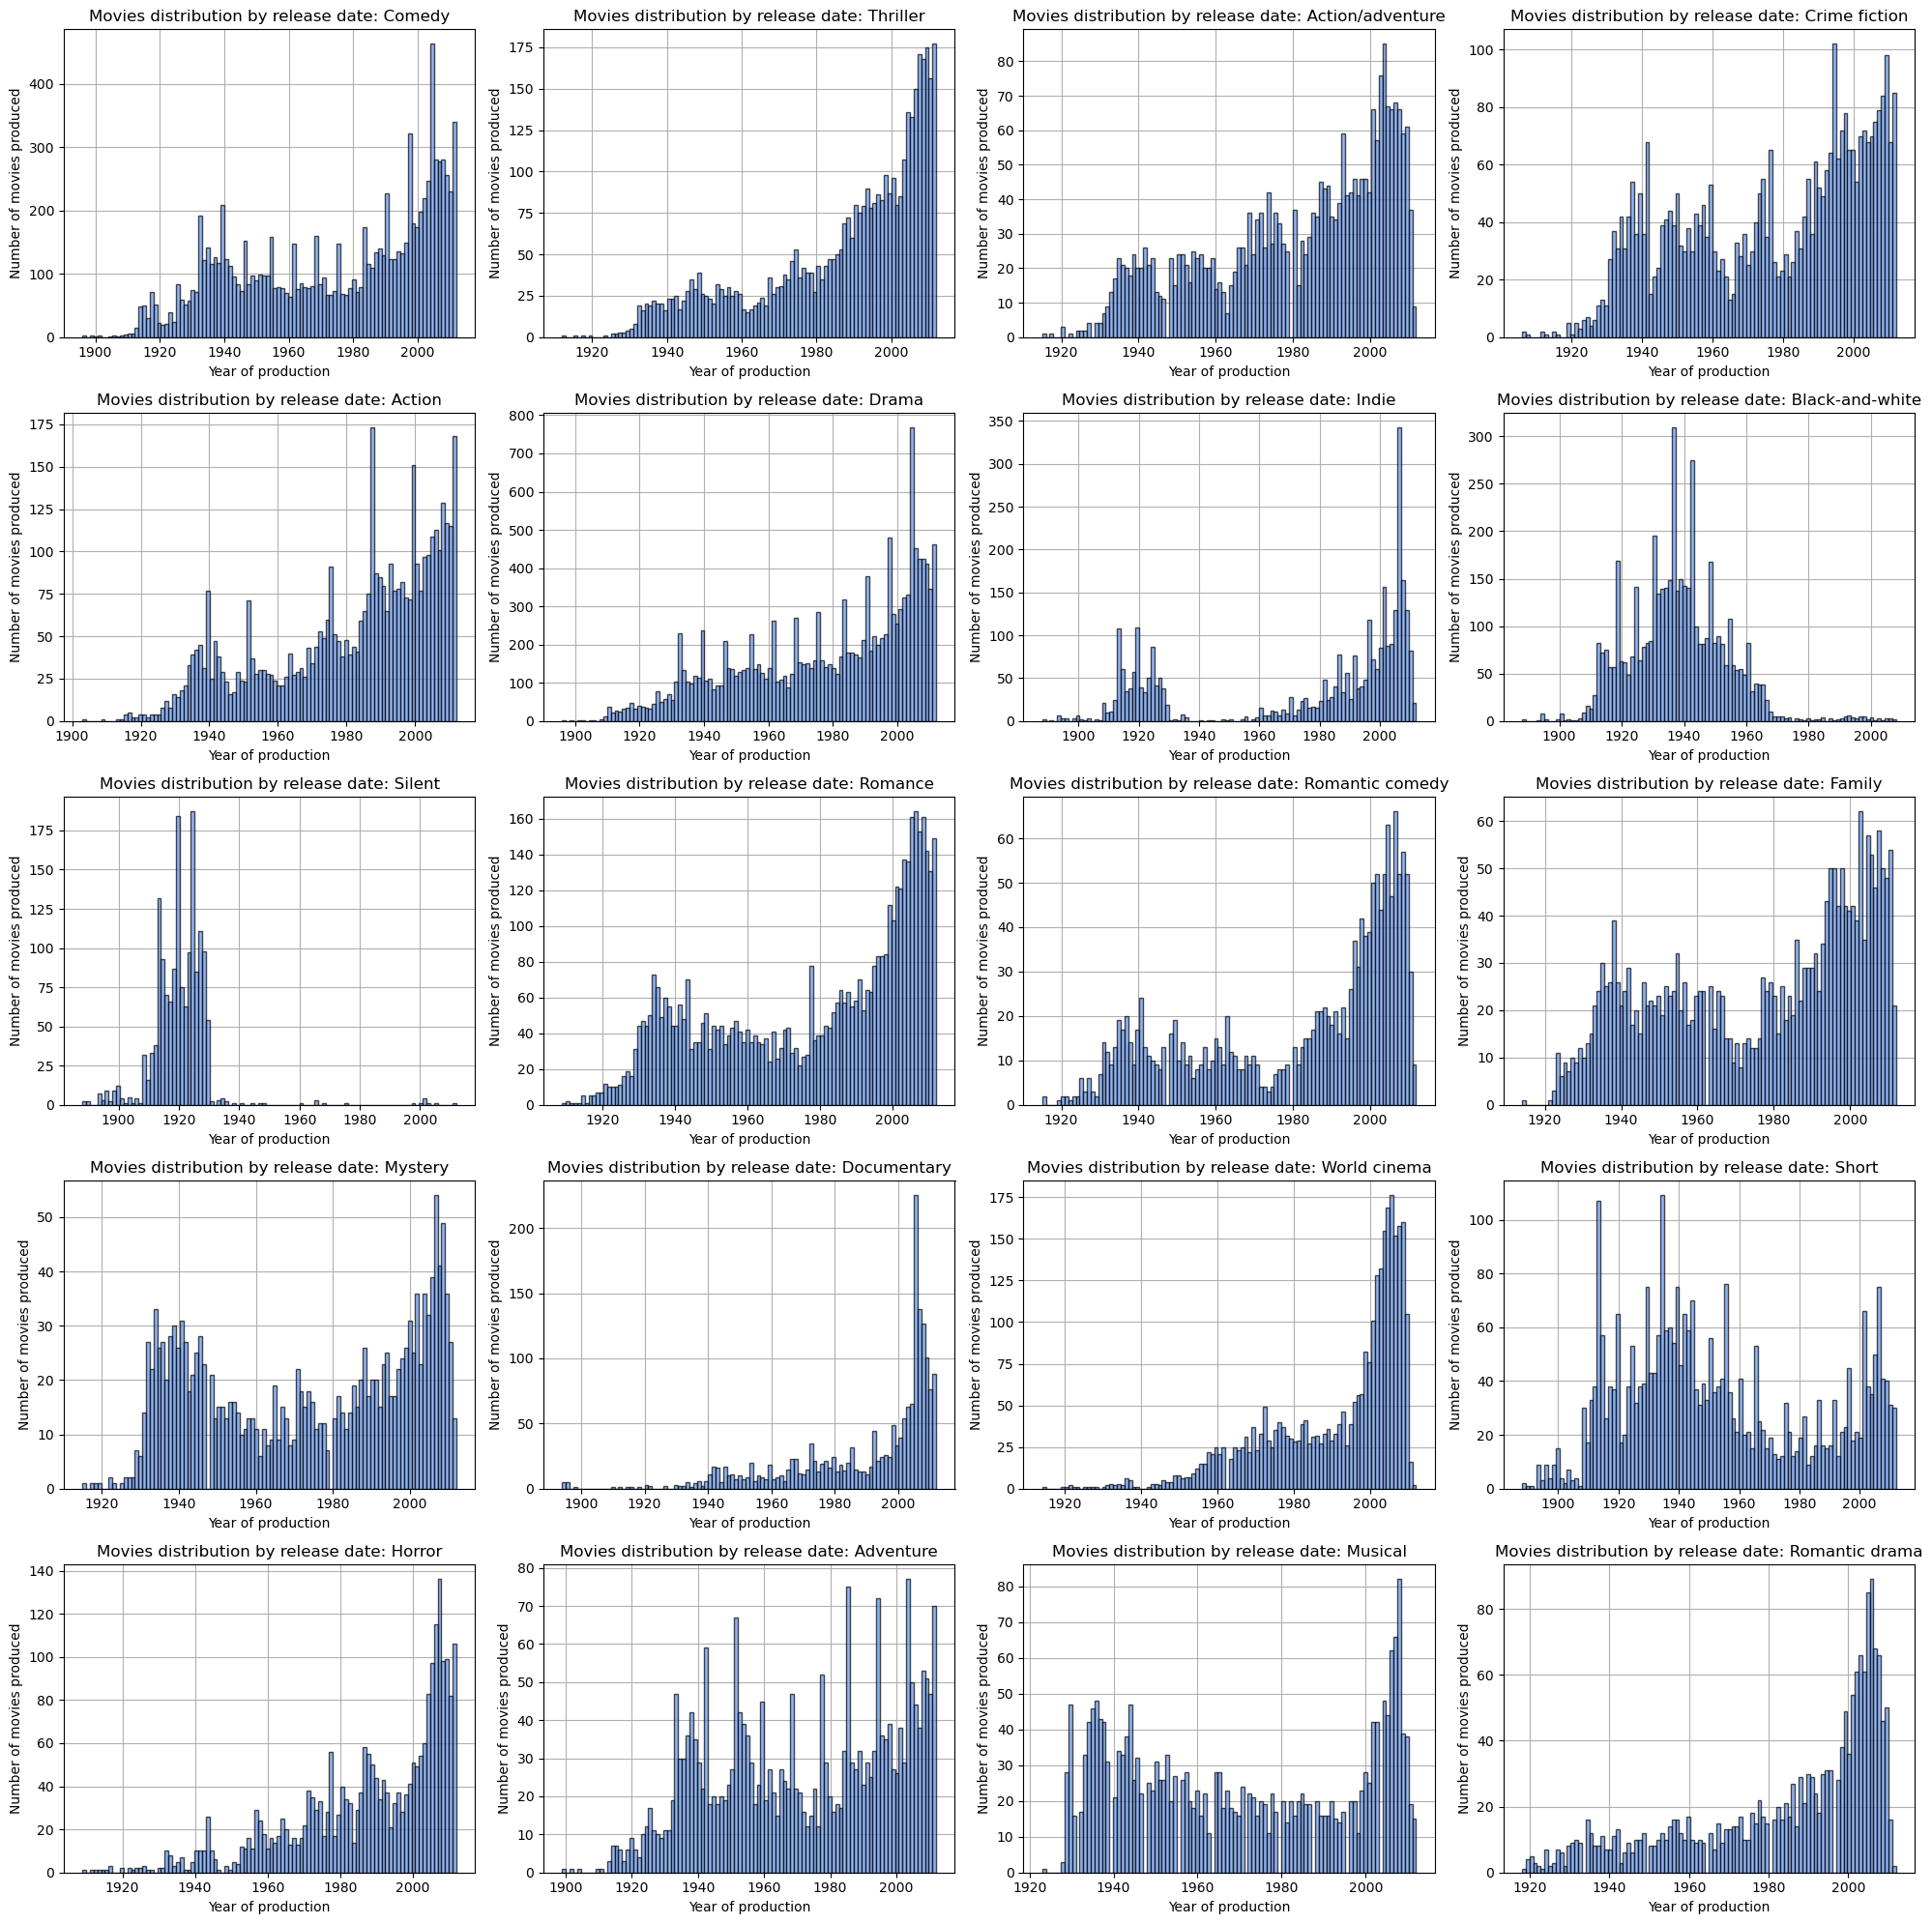

In [44]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

# looping over genres
for i, genre in enumerate(df_movies_visuals['genres'].unique()):
    # selecting current axes
    ax = axes[i]
    ax.set_title(f'Movies distribution by release date: {genre}')

    # plotting the histogram for the current genre
    ax.hist(df_movies_visuals[df_movies_visuals['genres'] == genre]['release_date'], bins= 100, **styles['hist_style'], zorder=2)

    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')
    ax.grid(True, zorder=0)

plt.tight_layout()

From these plots, it is most interesting to observe that production frequencies of films are genre-specific. For some films, such as the most popular genres' distributions (row 1), these genre-specific production distributions strongly resemble the original production distribution. This is in contrast to genres like 'Black-and-white' (row 2, column 4) or 'Silent' films that peak in their max production period in the 40s and in the 20s, respectively. In a similar vein, some genre production distributions, such as those for indie films, are bimodal. This differs from the initial plot of production frequencies, which showed an essentially monotonically increasing distribution. This bimodality is specific to the 20s and the 90s, which may align with the Roaring 20s and the technological revolution of the 90s.

# 3 - Ratings Analysis

In [45]:
# copies of the master dataframes to proceed with the analysis
df_movies_ratings = df_movies_ratings_imdb.copy()
df_movies_ratings_unique = df_movies_ratings_imdb_unique.copy()

The sourced IMDb ratings come from audiences reviewing movies on a 0 to 10 scale. These ratings are then averaged in a way that IMDb does not disclose. Regardless, as our analysis is centered around predicting movie ratings, the general distribution of the ratings for our movies -- which at this point, have already been cleaned -- is required. Both quantitative and visual descriptions for these rating distributions are first presented.

In [46]:
# visualizing basic 'averagerating' statistics
df_movies_ratings["averageRating"].describe()

count    77948.00000
mean         6.16238
std          1.08109
min          1.10000
25%          5.60000
50%          6.30000
75%          6.90000
max          9.50000
Name: averageRating, dtype: float64

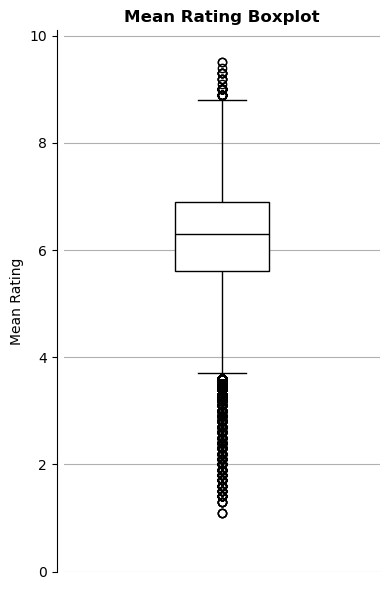

In [47]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(data=df_movies_ratings['averageRating'], **styles['boxplot_style'])

# box-plotting the 'mean_rating' column
sns.despine(offset=5, trim=False, bottom=True)
plt.title('Mean Rating Boxplot', weight='bold')
plt.xticks([])
plt.ylim([0,10.1])
plt.ylabel("Mean Rating", fontsize=10)
plt.grid(True)

plt.tight_layout()

As expected, the movie ratings are approximately normally distributed with equivalent whisker sizes in the above boxplot and a median centered about at the centre of the plot's interquartile range. Clearly, many outliers are observed. However, these ratings will not be considered as such as their presence in the overall ratings distribution is not heavily skewing the mean from the median, and these extreme ratings may provide future insight as to what characteristics relate to such outliers.

The plot below provides further information on the mean movie ratings distribution over the rating scale, from 0 to 10.

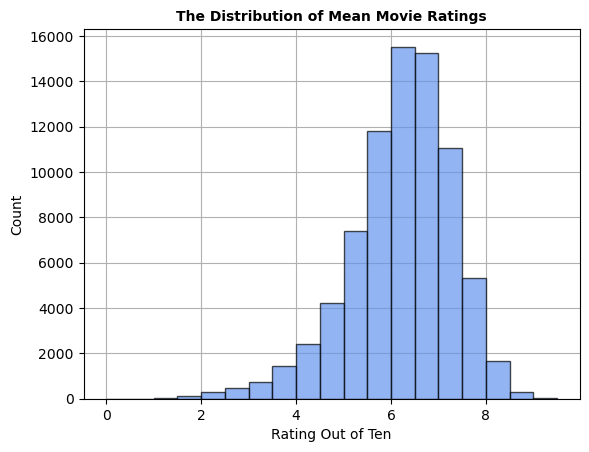

In [48]:
# defining bins
bin_edges = np.arange(0, df_movies_ratings['averageRating'].max() + 0.5, 0.5)

plt.hist(df_movies_ratings['averageRating'].values, bins = bin_edges, **styles['hist_style'],zorder=2)
plt.title("The Distribution of Mean Movie Ratings", weight='bold', fontsize=10)
plt.xlabel('Rating Out of Ten', fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(True, zorder=0)

In this visualization of movie average ratings, an approximately normal distribution is modelled. A slight left-skew may be claimed, and for this reaon we implement a ktest as well as a QQ-plot to assess the average movie rating normality. Doing so is essential for further statistical analyses, given normality is a baseline condition for several tests (e.g. ANOVA testing).

In [49]:
diagnostic.kstest_normal(df_movies_ratings['averageRating'].values, dist = 'norm')

(0.07208240893274553, 0.0009999999999998899)

The mean rating normality test returns a low p-value and this suggests that the distribution lacks normality. However, visual inspections of the mean ratings distribution lead to a different conclusion. We therefore turn to a Q-Q plot for further assessing normality.

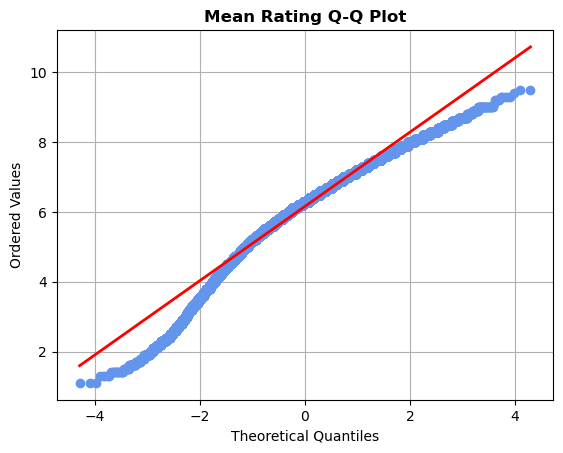

In [50]:
# ploting Q-Q test
fig, ax = plt.subplots()
res = stats.probplot(df_movies_ratings['averageRating'].values, dist="norm", plot=ax)

# line settings
ax.get_lines()[0].set_color('cornflowerblue') 
ax.get_lines()[0].set_linewidth(2)
ax.get_lines()[1].set_color('red') 
ax.get_lines()[1].set_linewidth(2)

plt.title("Mean Rating Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

Given the central portion of the Q-Q plot is flatter and the edges steeper, we revert to the conclusion that the IMDb mean ratings sourced are approximately normally distributed. However, the shape of this Q-Q plot does reveal that there are more datapoints aggregated about the mean than there would be in the case of a normal distribution.

Now, a closer look to genres preferences is presented. The objective in doing so is to visualize if the mean movie rating changes, based on the movie genre, hence making the above assessment of movie rating distributions more granular.

Text(50.72222222222221, 0.5, 'Genres')

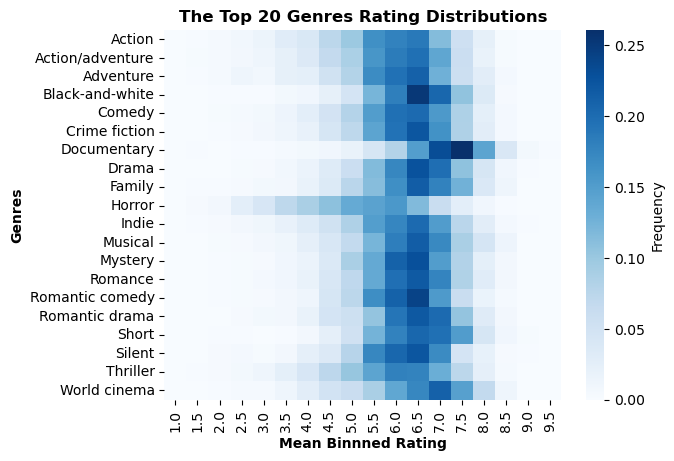

In [51]:
# making the mean of each movie's rating an increment of 0.5
df_movies_ratings["binned_rating"] = df_movies_ratings["averageRating"].apply(lambda x: round(x*2)/2)

df_genres_meanratings = pd.crosstab(df_movies_ratings['genres'], df_movies_ratings['binned_rating'], normalize='index')

# creating an heatmap among the genres
ax = plt.axes()
sns.heatmap(df_genres_meanratings, annot=False, cmap='Blues', ax = ax, cbar_kws={'label': 'Frequency'})
ax.set_title('The Top 20 Genres Rating Distributions', weight='bold')
ax.set_xlabel('Mean Binnned Rating', weight='bold')
ax.set_ylabel('Genres', weight='bold')

From this heatmap, we can observe that for the majority of the top 20 genres movies reported in the CMU dataset, an approximately normal distribution of their ratings is taken on. These distributions mostly show average ratings of movies irrespective of their genre between the 4.5 and 7.5 rating bins, as expected given the population's mean rating of 6. Noticeably, horror and science fiction imovies have comparatively stronger left-skews than the other main genres for ratings.

With the genre distributions or ratings analyzed, relationships between the cleaned movie metadata features and ratings is assessed. Namely, correlations between movie runtime and release date with ratings are analyzed.

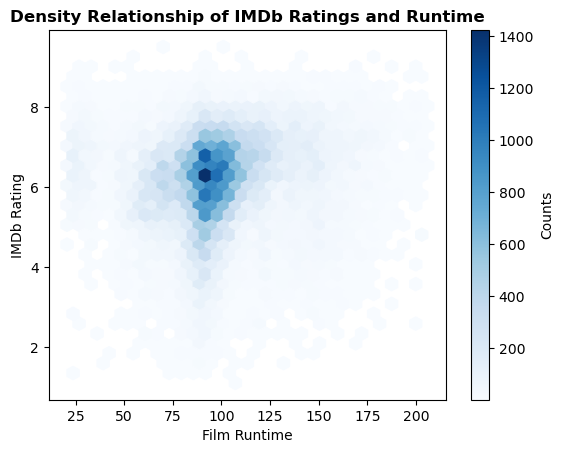

In [52]:
# plotting the relationship between movies with reasonable runtimes (over 20 minutes, despite short films
# having lesser time than this as there are many incorrect runtimes observed under 20 minutes) and mean rating
df_movies_ratings_runtimes = df_movies_ratings[df_movies_ratings['runtime'] > 20.0]

plt.hexbin(df_movies_ratings_runtimes["runtime"], df_movies_ratings_runtimes["averageRating"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Counts")
plt.xlabel("Film Runtime")
plt.ylabel("IMDb Rating")
plt.title("Density Relationship of IMDb Ratings and Runtime", weight='bold')
plt.show()

The high density of movie counts (the blue region on the graph) suggests that movies with a runtime between 75 and 125 minutes usually receive a rating between 5 and 7.

Unfortunately, the density plot only gives partial answers specific questions of if there is a relationship between runtime and ratings, and if this relationship changes based on movie genre? To further assess the relationship of movie runtime on rating, a matrix of visualizaitons of these correlations per top 20 movie genre is provided.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


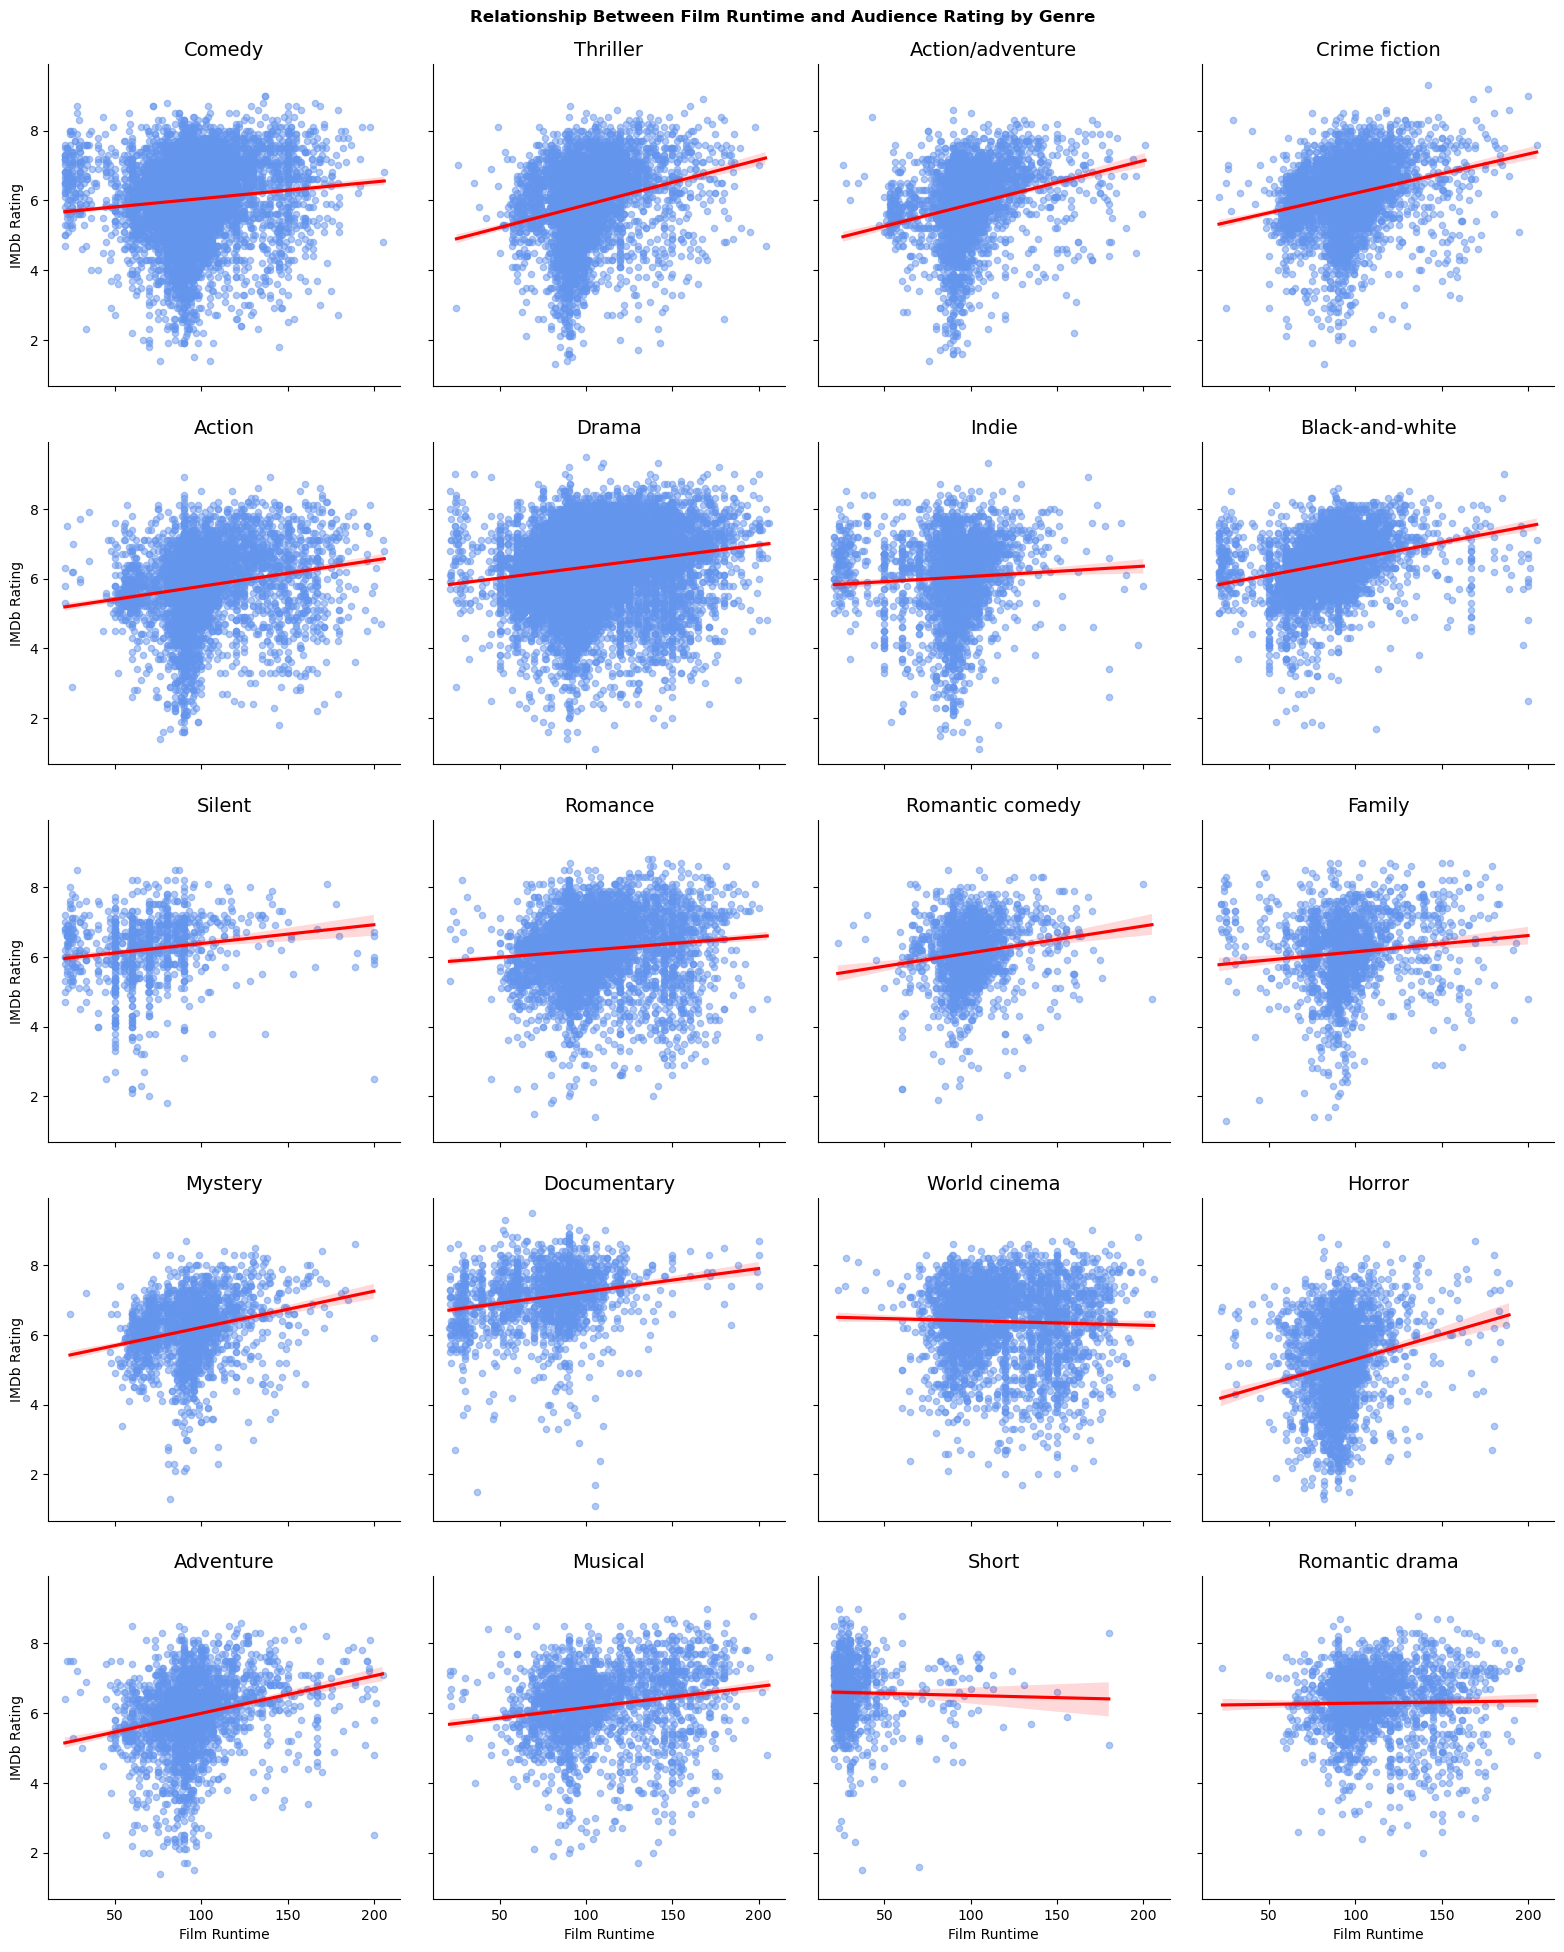

In [53]:
# preparing a grid of scatter plots with regression lines for each genre
seperated_genres = sns.FacetGrid(df_movies_ratings_runtimes, col="genres", col_wrap=4, height=4, sharex=True, sharey=True)

# mapping the regression plot
seperated_genres.map(sns.regplot, "runtime", "averageRating", scatter_kws=styles['scatter_style'], line_kws=styles['line_style'])

seperated_genres.set_axis_labels("Film Runtime", "IMDb Rating")
seperated_genres.fig.suptitle("Relationship Between Film Runtime and Audience Rating by Genre", weight='bold')
seperated_genres.set_titles("{col_name}", size=14)

seperated_genres.tight_layout(pad=2)
plt.show()

The correlation, for almost all genres is positive, meaning that the longer the movie, the higher the rating. The correlation is stronger in some cases, like in 'Thriller' movies (row 1, column 2), 'Action/adventure' (row 1, column 3), 'Crime Fiction' (row 1, column 4) and also 'Horror' (row 4, column 4) and, interestingly, they appear to share almost the same scatter plot shape. The only movie genres that show negative correlations are 'World cinema' and 'Short' (row 5, column 3) films.

To further analyze the correlation between average ratings and movie runtime, Pearson and Spearman correlations between the two are calculated.

In [54]:
# calculating Pearson correlation
pearson_corr, pearson_p = pearsonr(df_movies_ratings_runtimes['runtime'], df_movies_ratings_runtimes['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# calculating Spearman correlation
spearman_corr, spearman_p = spearmanr(df_movies_ratings_runtimes['runtime'], df_movies_ratings_runtimes['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: 0.1222, p-value: 0.0000
Spearman correlation: 0.1767, p-value: 0.0000


As both correlations are positive, we claim that across all movies there is a positive correlation between runtime and rating. This relationship is significant, considering a significance level of 0.05.

The same plots can been computed to compare the rating and the release date.

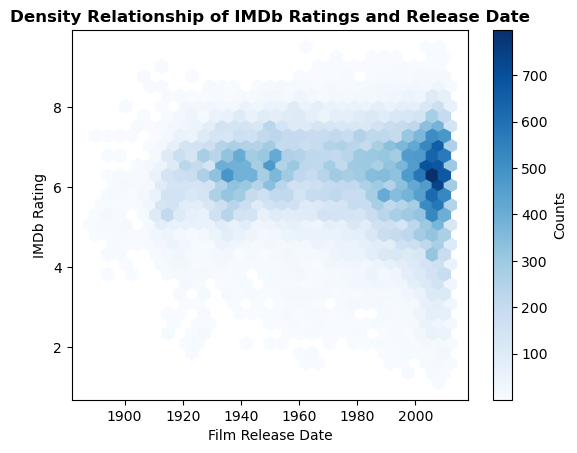

In [55]:
# hexbin() map of retings and runtime
plt.hexbin(df_movies_ratings["release_date"], df_movies_ratings["averageRating"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Counts")
plt.xlabel("Film Release Date")
plt.ylabel("IMDb Rating")
plt.title("Density Relationship of IMDb Ratings and Release Date", weight='bold')
plt.show()

This time, the density plot shows a lot of movies are produced in the last decade and they tend to receive ratings from 4 to 8. The information that can be retrieved are extremely general, therefore the next grid of plots shows the correlation between ratings and release date, for specific genres.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


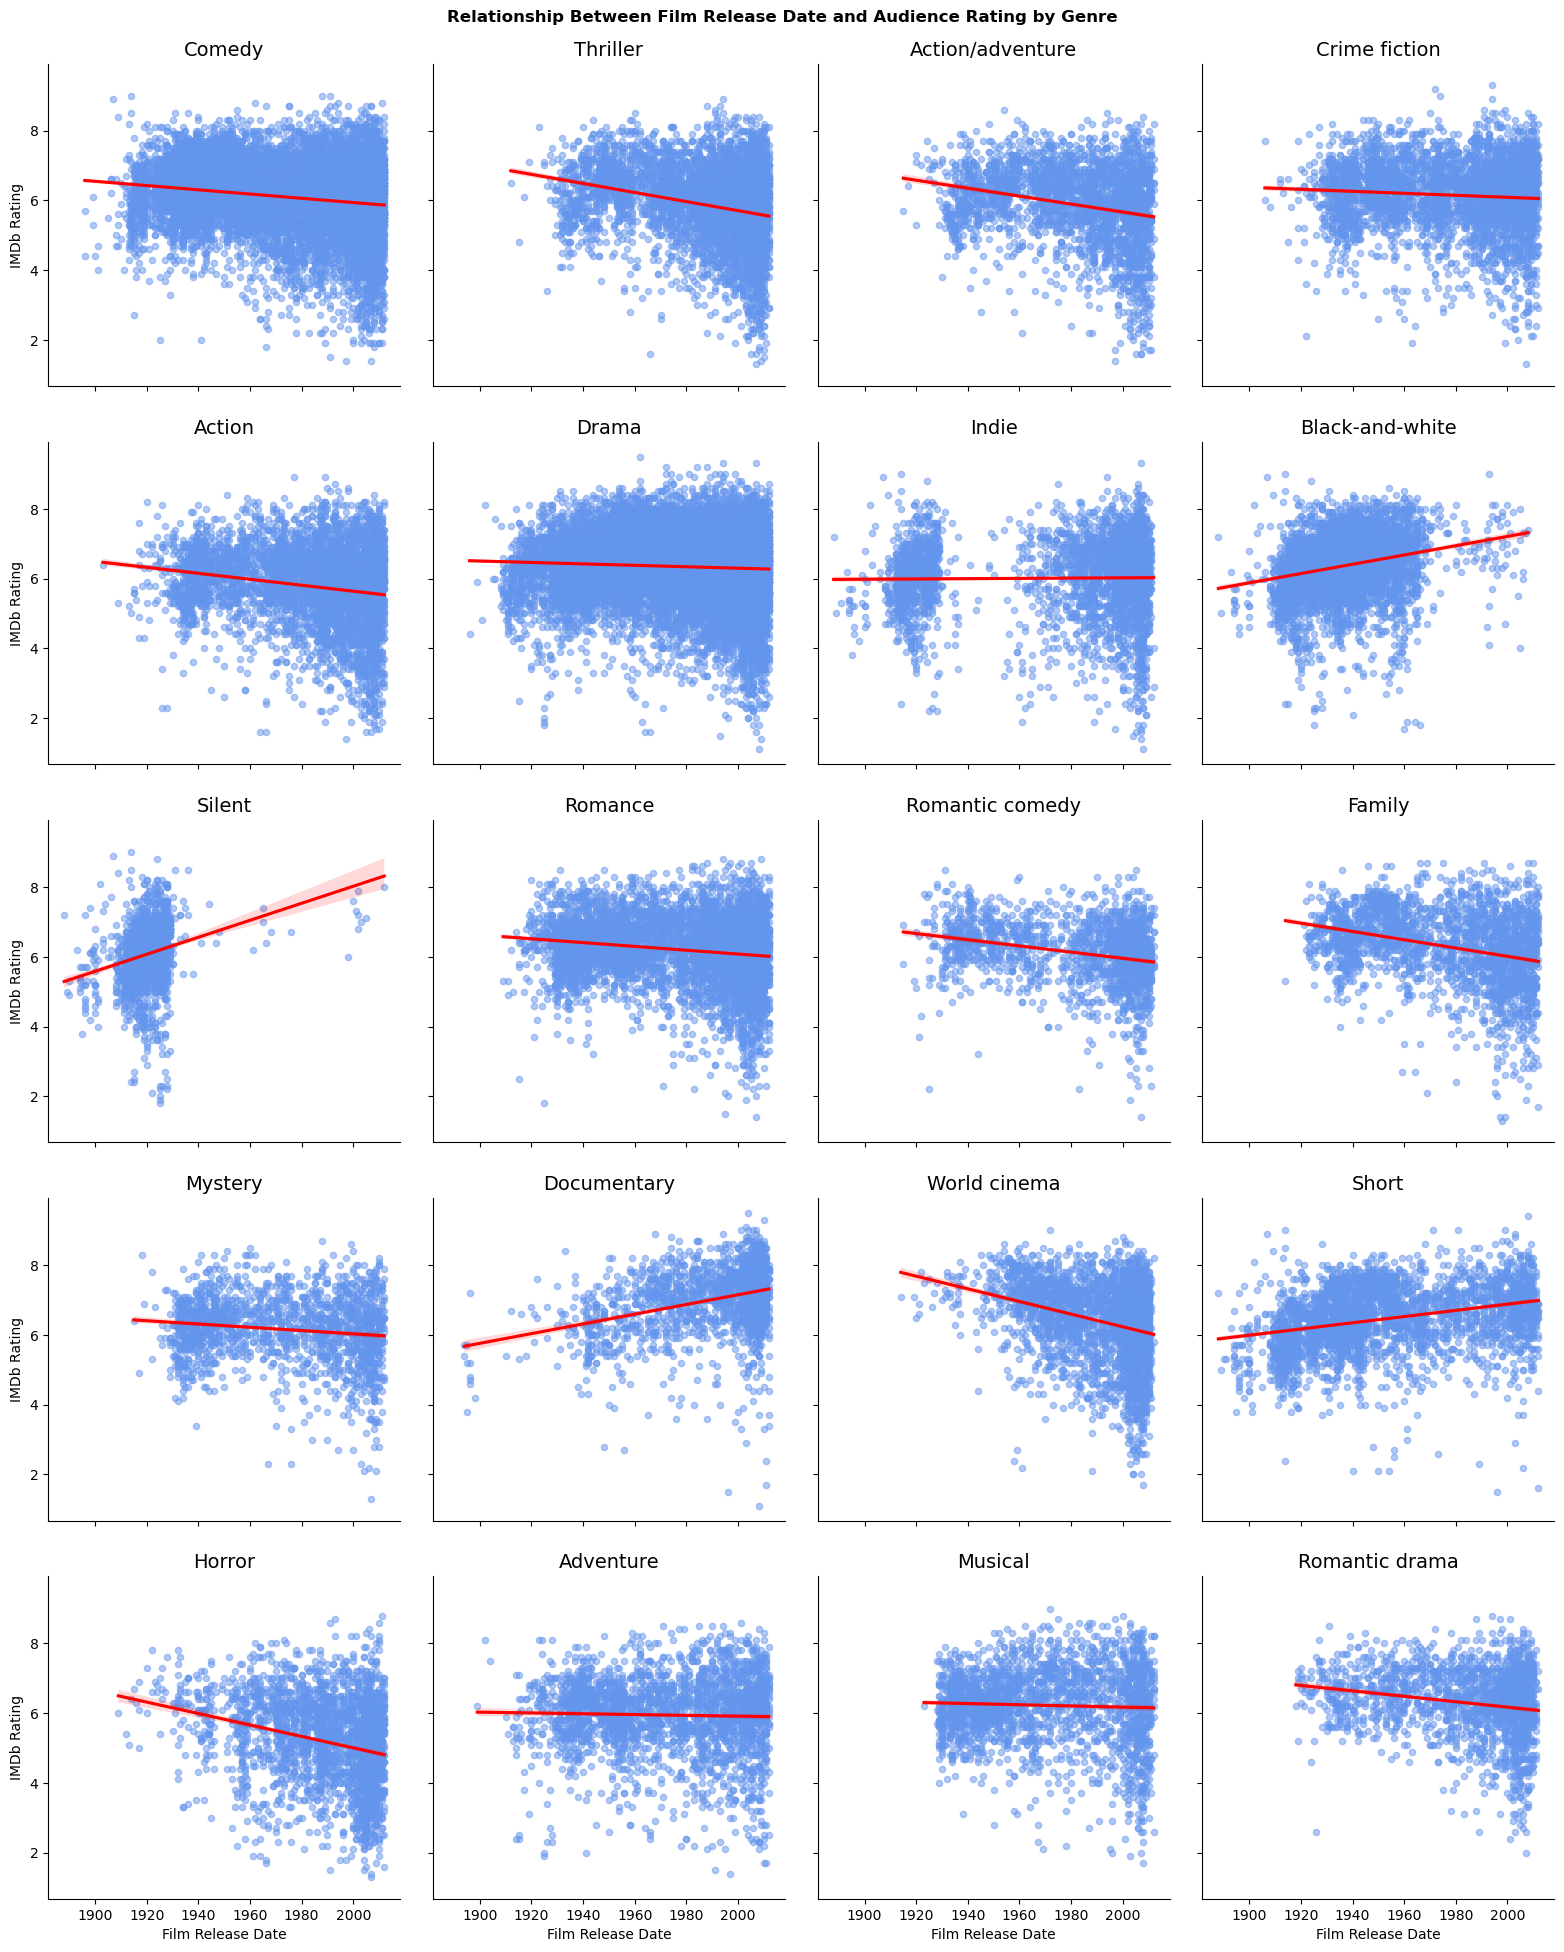

In [56]:
# preparing a grid of scatter plots with regression lines for each genre
seperated_genres = sns.FacetGrid(df_movies_ratings, col="genres", col_wrap=4, height=4, sharex=True, sharey=True)

# mapping the regression plot
seperated_genres.map(sns.regplot, "release_date", "averageRating", scatter_kws=styles['scatter_style'], line_kws=styles['line_style'])

seperated_genres.set_axis_labels("Film Release Date", "IMDb Rating")
seperated_genres.fig.suptitle("Relationship Between Film Release Date and Audience Rating by Genre", weight='bold')
seperated_genres.set_titles("{col_name}", size=14)

seperated_genres.tight_layout(pad=2)
plt.show()

Unlike the runtime/rating correlation studied previously, here, the correlations show more varied slopes and 'scatter shapes' across genres. Genres like 'Black-and-white' (row 2, column 4) tend to increase in mean rating over time, as is also true for 'Silent' movies (row 3, column 1). In many other genres, the relationship of release date on average ratings appears stationary given a regression slope of approximately 0. This can be seen for genres such 'Adventure' (row 5, column 2) and 'Musical' (row 5, column 3). Finally, the remaining genres show a negative correlation, as in the case of 'Thriller' (row 1, column 2) and 'Horror' (row 4, column 1) movies. To examine the release dates correlation with average ratings across all of our movies, the Pearson and Spearman correlations are again computed.

In [ ]:
# calculating Pearson correlation
pearson_corr, pearson_p = pearsonr(df_movies_ratings['release_date'], df_movies_ratings['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# calculating Spearman correlation
spearman_corr, spearman_p = spearmanr(df_movies_ratings['release_date'], df_movies_ratings['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: -0.1029, p-value: 0.0000
Spearman correlation: -0.0858, p-value: 0.0000


The correlation between release date and average movie rating is weekly negative, yet nonetheless significant at a 0.05 significance level. This means that the rating decreases as newer films are made, however, this trend is not true for all movie genres.

## 3.1 - Film ratings across regions and genres, over time

To further analyze movie characteristics relationships with their ratings, the relationships of movie ratings with genres, region of production, and time are assessed. This analysis complexifies those above by including 'regions' as a feature to distinguish unique rating trends by. Instead of continents, this analysis proposes another geographical division, based on cultural diversity rather than political division. Indeed, we want to study how ratings can reflect society, including its culture. The number of geographical regions is kept low, nine, for simplicity.

Before the regional and genre dependencies of ratings over time can be assessed, we must check whether all movie genres are present in all nine of our regions considered. If not, we fill that region with the missing genre to avoid downstream analyses from failing due to missing values.

In [58]:
# identifying if any country does not have a particular genre
for genre in top_20_genres:
    # indentifying unique regions for the current genre
    regions_with_genre = df_movies_ratings[df_movies_ratings["genres"] == genre]["region"].unique()

    # converting .tolist()
    regions_with_genre = regions_with_genre.tolist()

    # checking if the total number of regions for the current genre is equal to the total number of regions (9)
    if len(regions_with_genre) < 9:
        for region in list(regions.keys()):
            if region not in regions_with_genre:
                print(f"The geographical region {region} does not have a movie for the genre {genre}.")

The geographical region South Africa and Central Africa does not have a movie for the genre Black-and-white.
The geographical region North Africa and Middle East does not have a movie for the genre Indie.
The geographical region South Africa and Central Africa does not have a movie for the genre Musical.
The geographical region South Africa and Central Africa does not have a movie for the genre Silent.
The geographical region North Africa and Middle East does not have a movie for the genre Silent.


In [59]:
# filling a copy dataframe with blank movie(s) for the missing genre(s) of any geographic region, to ensure no errors when plotting below
df_movies_ratings_regionfilled = df_movies_ratings.copy()

df_movies_ratings_regionfilled = filling.fill_missing_regions(
    df_movies_ratings_regionfilled,
    top_20_genres,    
    list(regions.keys())      
)

In [60]:
# checking if any country does not have a particular genre again, which shouldn't be the case
for genre in top_20_genres:
    # indentifying unique regions for the current genre
    regions_with_genre = df_movies_ratings_regionfilled[df_movies_ratings_regionfilled["genres"] == genre]["region"].unique()

    # converting .tolist()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for region in list(regions.keys()):
            if region not in regions_with_genre:
                print(f"The geographical region {region} does not have a movie for the genre {genre}.")
    else:
        print(f"Every region has at least one {genre} movie.")

Every region has at least one Drama movie.
Every region has at least one Comedy movie.
Every region has at least one Romance movie.
Every region has at least one Black-and-white movie.
Every region has at least one Action movie.
Every region has at least one Thriller movie.
Every region has at least one Crime fiction movie.
Every region has at least one Indie movie.
Every region has at least one Short movie.
Every region has at least one World cinema movie.
Every region has at least one Action/adventure movie.
Every region has at least one Horror movie.
Every region has at least one Adventure movie.
Every region has at least one Family movie.
Every region has at least one Musical movie.
Every region has at least one Documentary movie.
Every region has at least one Romantic drama movie.
Every region has at least one Mystery movie.
Every region has at least one Romantic comedy movie.
Every region has at least one Silent movie.


To compare average movie ratings across genres for movies grouped by their region of production, mean values of these double-movie groupings as well as their 95% confidence interval of average ratings are computed.

In [61]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_genre_statistics(
    df_movies_ratings_regionfilled,
    top_20_genres,
    list(regions.keys())
)

To answer our first question of how movie ratings change per region of production, an investigatory grid of mean rating comparisons is prepared across regions per movie genre. If a given region lacks less than three movies of a given genre, no bar is visualized to describe the mean of that region-genre movie category's average rating.

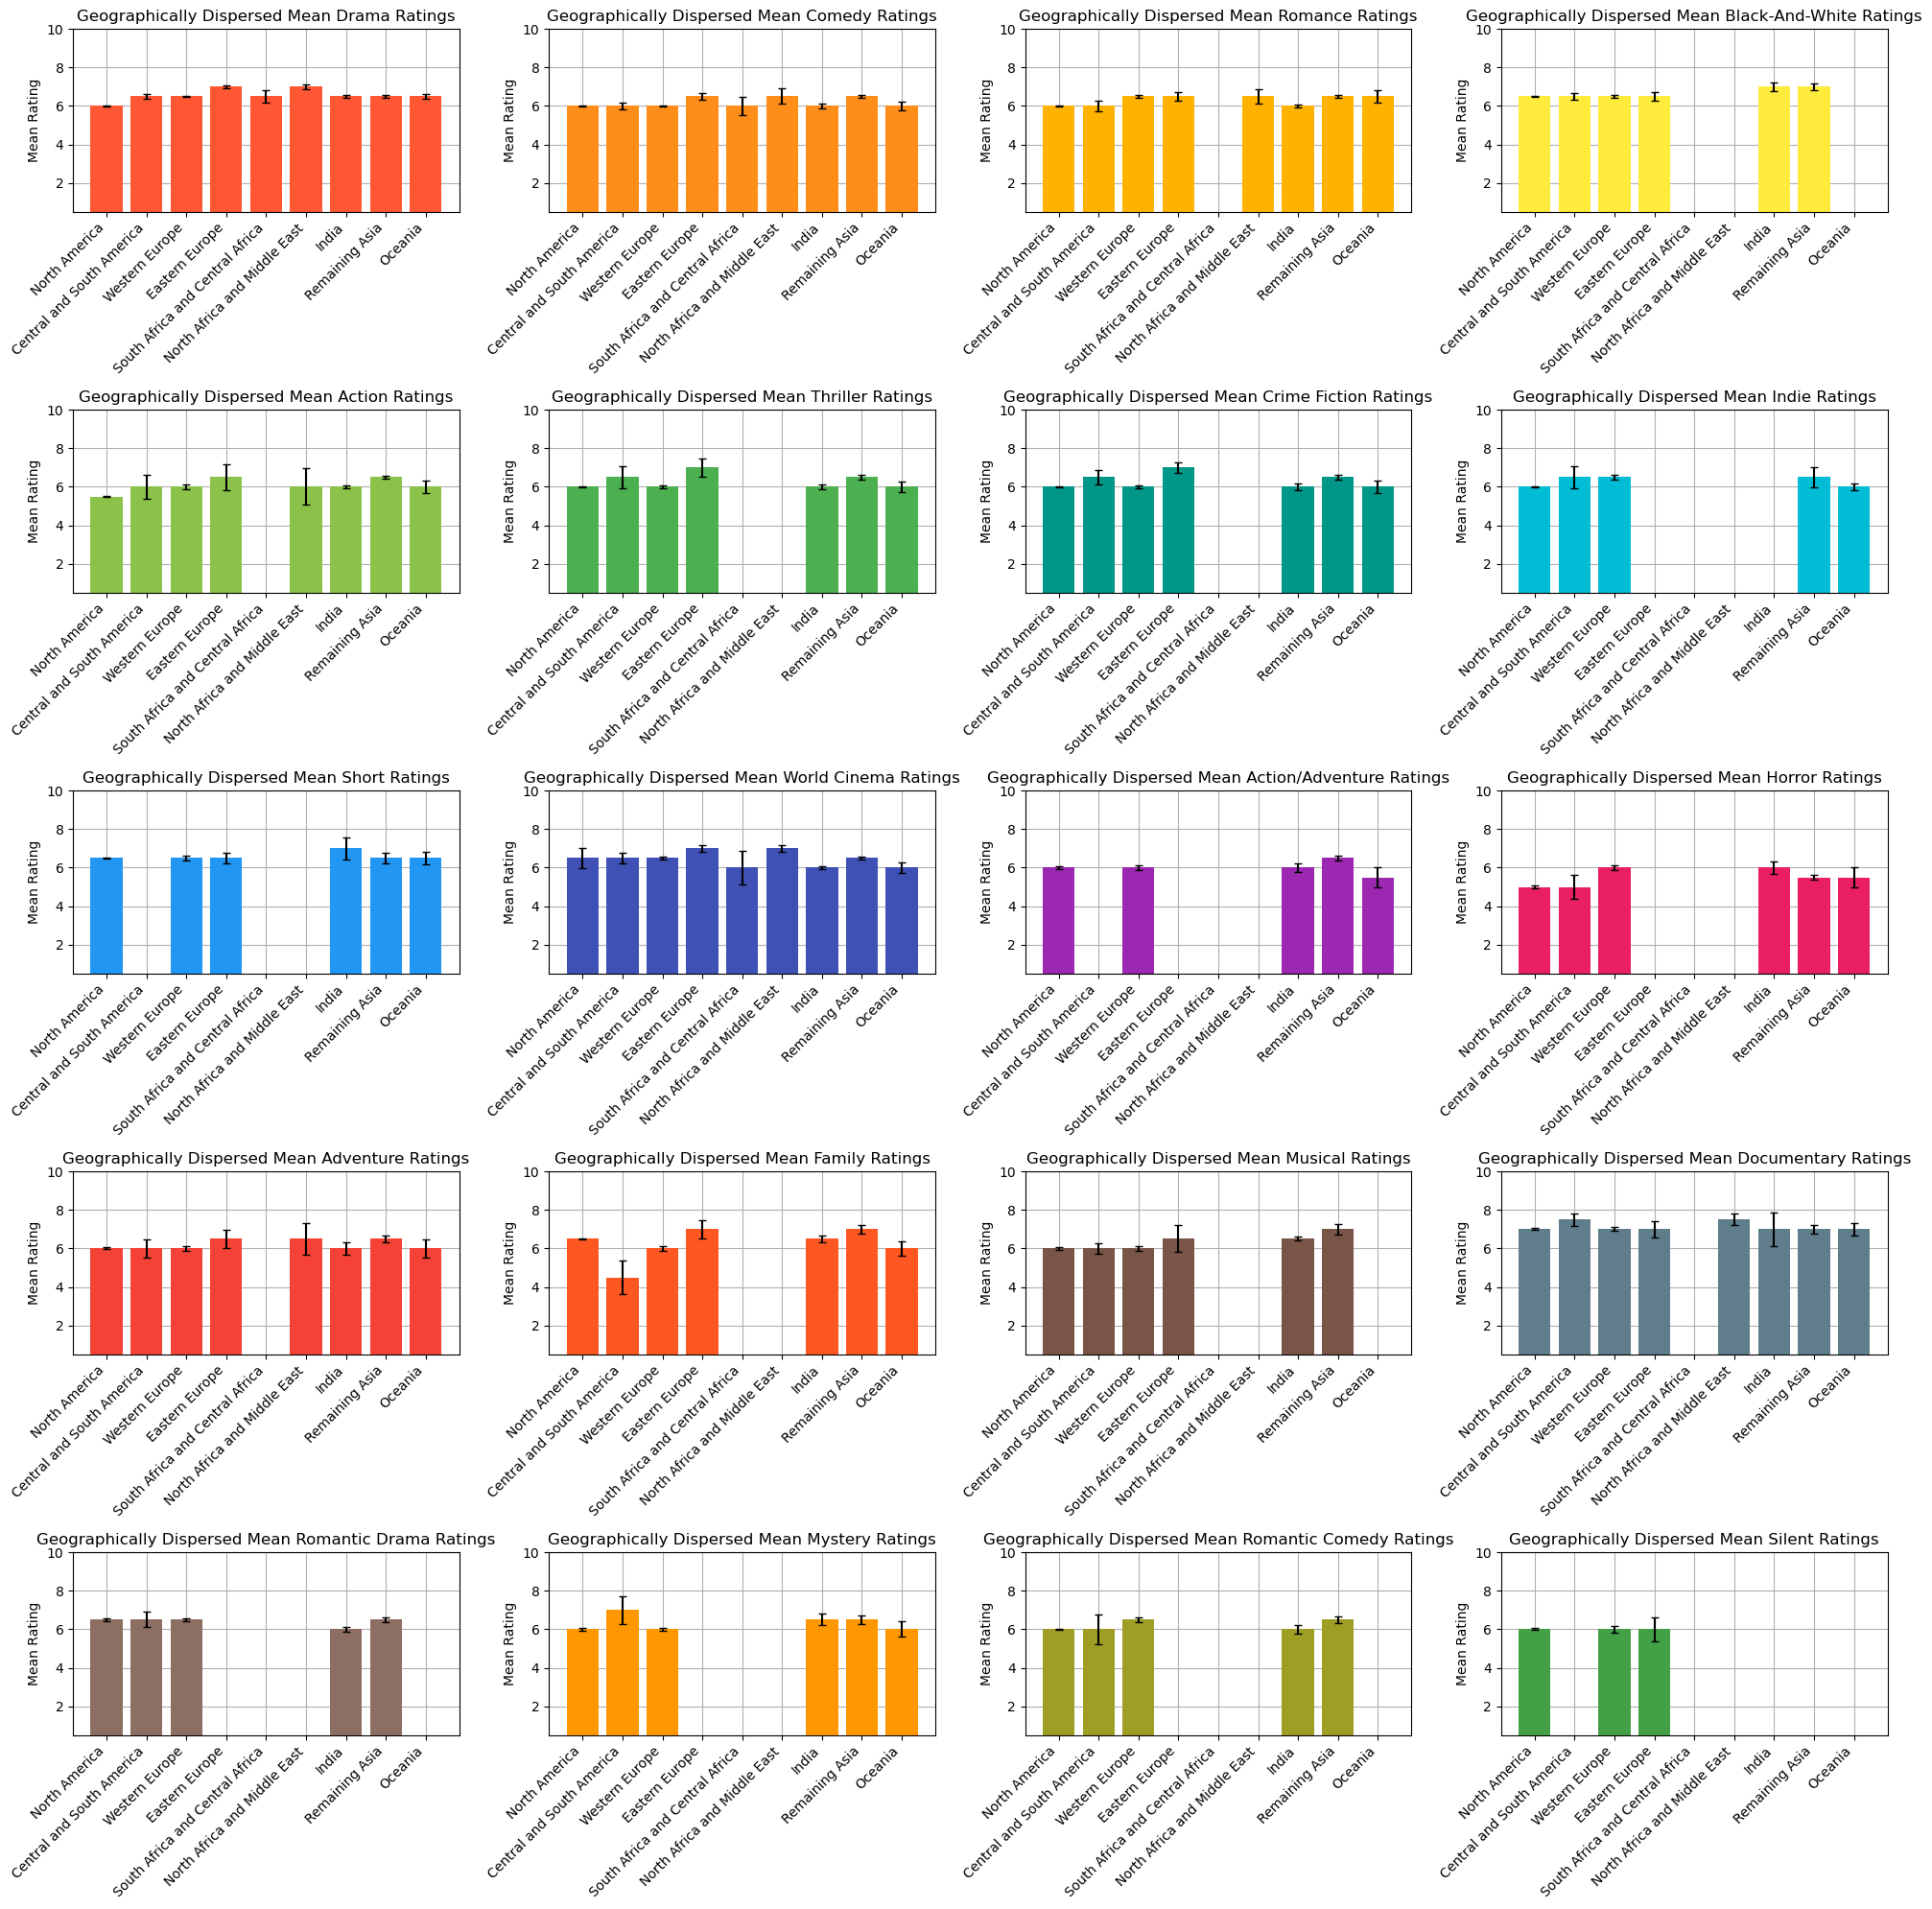

In [62]:
# creating a 5x4 grid for the subplots to fit 20 genres
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

# plotting each genre in the corresponding subplot
for i, genre in enumerate(top_20_genres):
    axes[i].bar(range(len(list(regions.keys()))), mean_ratings[genre], yerr=confidence_intervals[genre], capsize=3, color=genres_colors[i], zorder=2)

    axes[i].grid(True, zorder=0)
    axes[i].set_xticks(range(len(list(regions.keys()))))
    axes[i].set_xticklabels(list(regions.keys()), rotation=45, ha='right')
    axes[i].set_title(f"Geographically Dispersed Mean {genre.title()} Ratings")
    axes[i].set_ylabel("Mean Rating")
    axes[i].set_ylim(0.5, 10)

plt.tight_layout()
plt.show()

In some cases, for example 'Drama' movies (row 1, column 1), trends are hardly identified. In other evident cases, there is lack of data for specific genres in some regions, most frequently these regions are 'South Africa and Central Africa' and 'North Africa and Middle East'. This grid of plots gives us an overview of general preferences in terms of genre and production region, while providing confidence intervals for the rating displayed.

Now, a different visualization is proposed, grouping plots by production region rather than genre.

In [63]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_region_statistics(
    df_movies_ratings_regionfilled,
    list(regions.keys()),
    top_20_genres
)

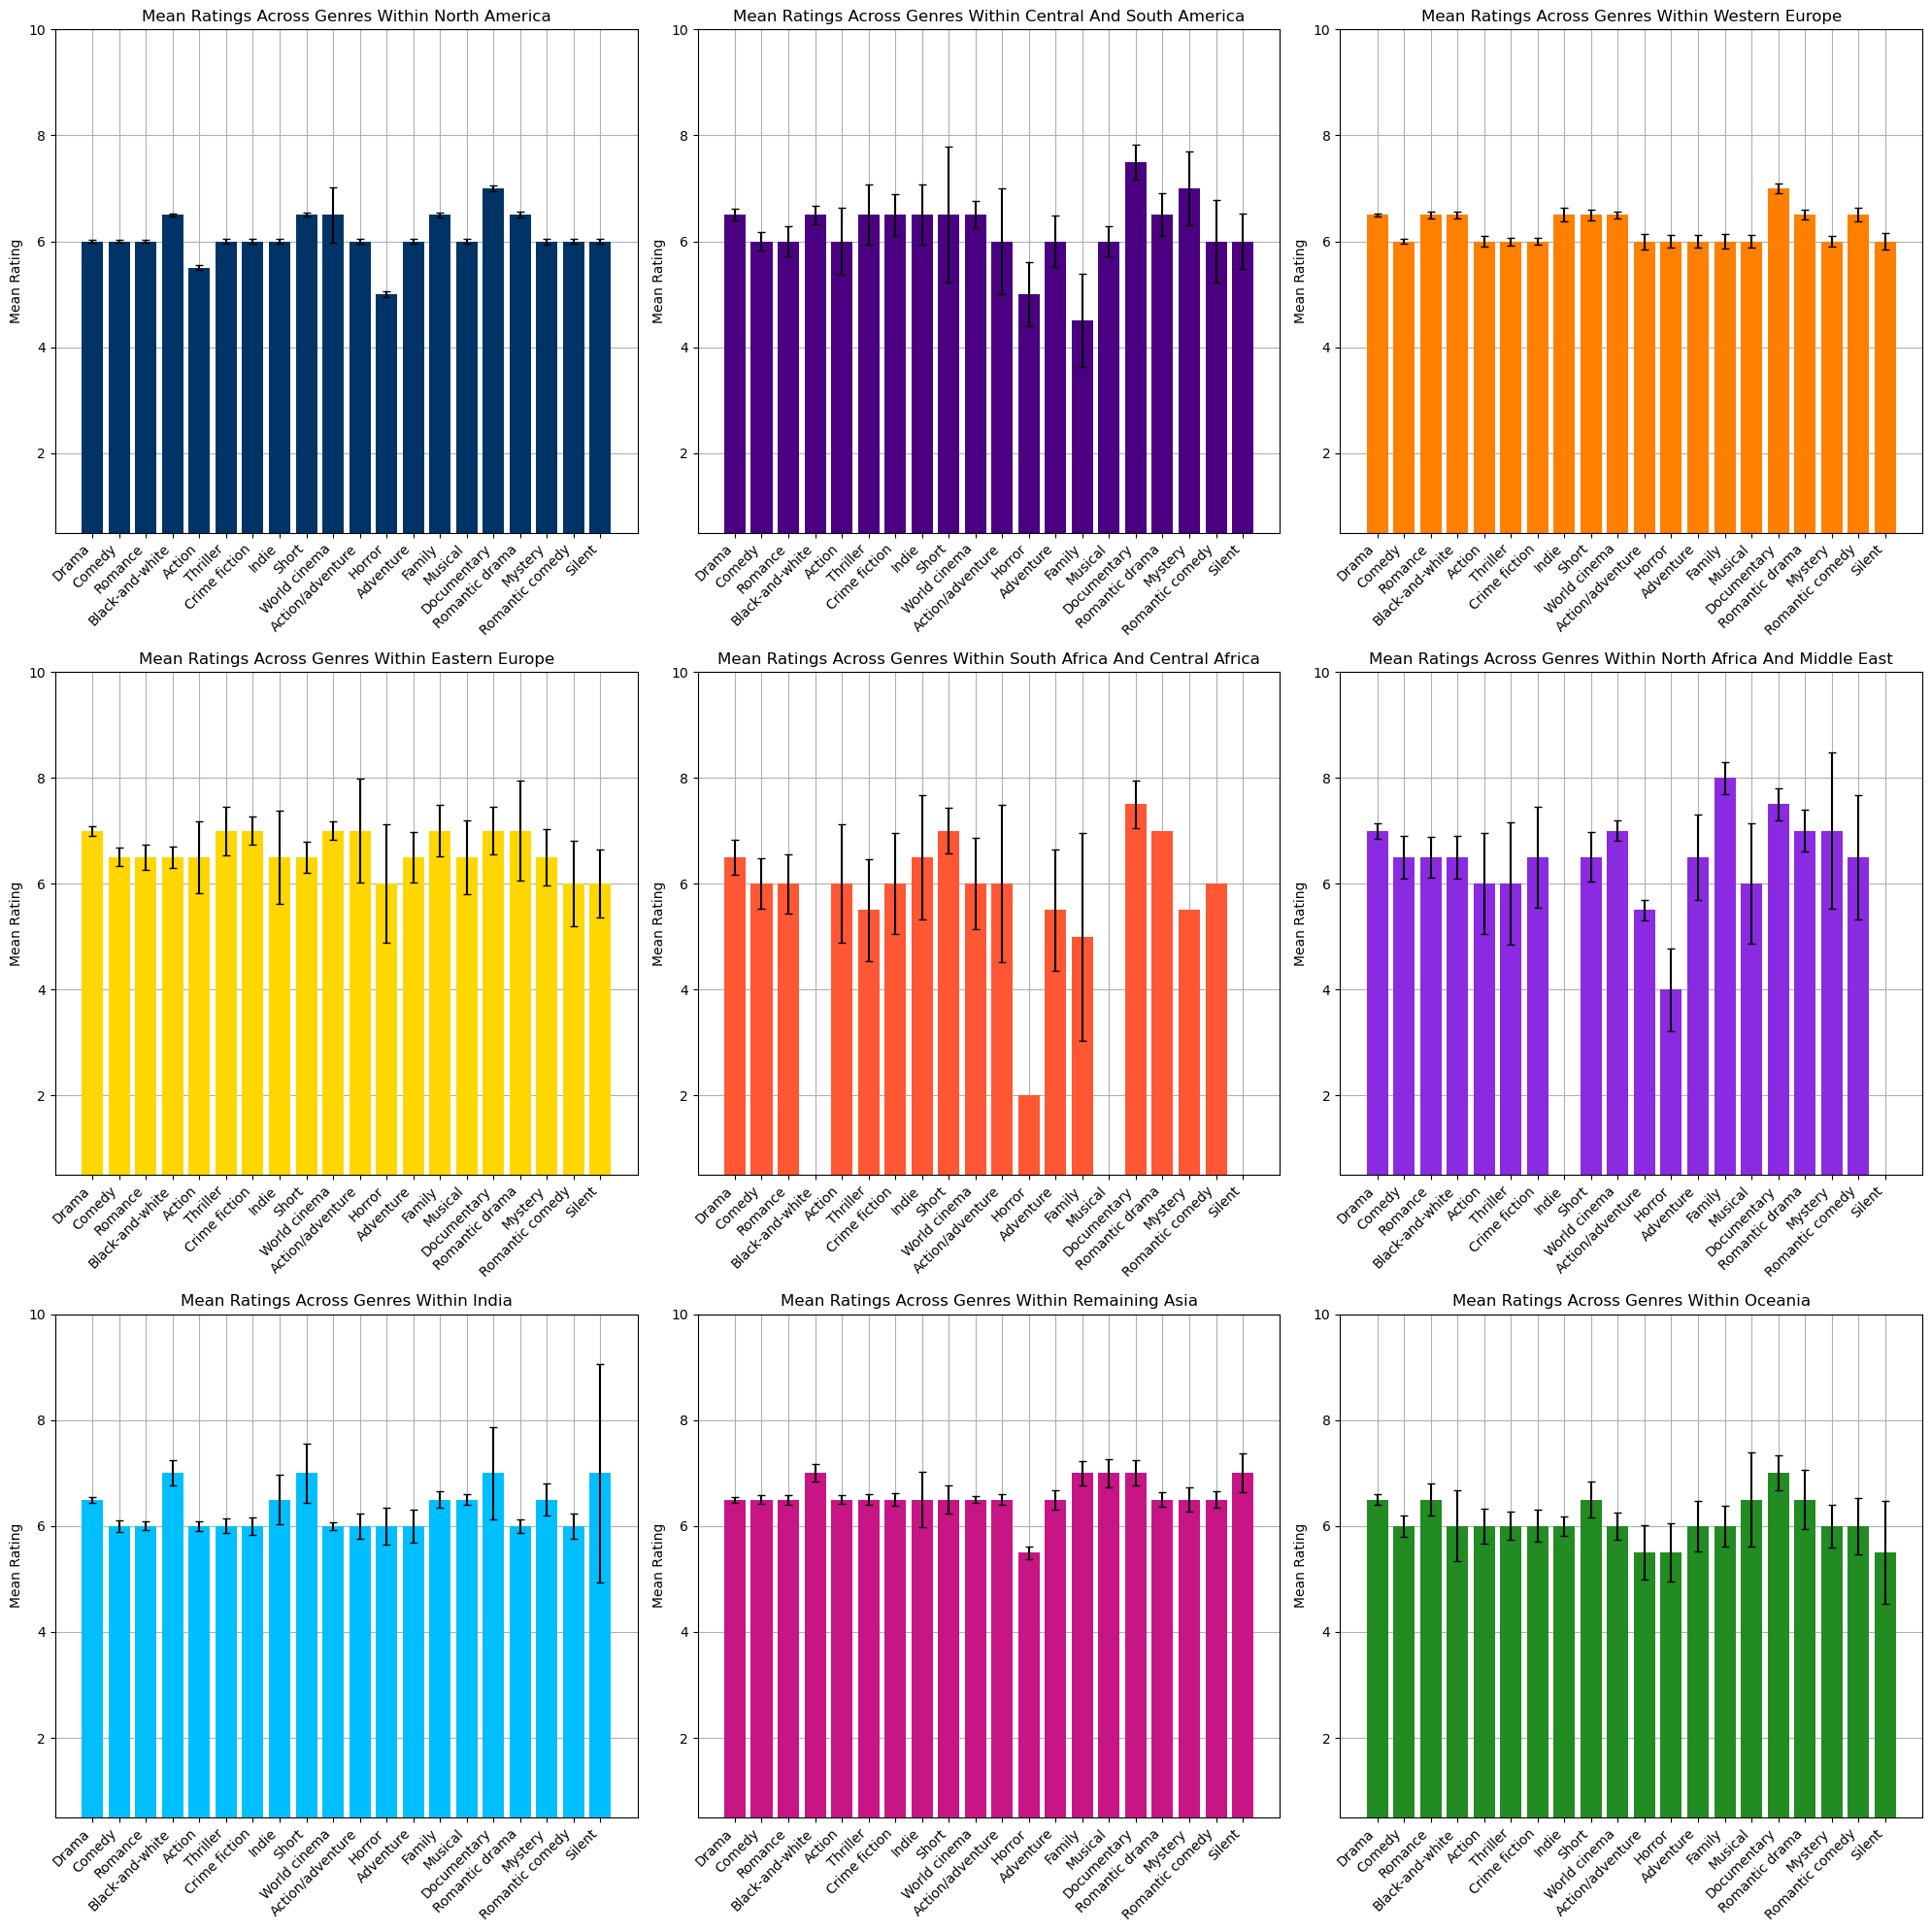

In [64]:
# creating a 3x3 grid for the subplots to fit 9 regions
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

# plotting each genre in the corresponding subplot
for i, region in enumerate(list(regions.keys())):
    axes[i].bar(range(len(top_20_genres)), mean_ratings[region], yerr=confidence_intervals[region], capsize=3, color=regions_colors[i], zorder=2)

    axes[i].grid(True, zorder=0)
    axes[i].set_xticks(range(len(top_20_genres)))
    axes[i].set_xticklabels(top_20_genres, rotation=45, ha='right')
    axes[i].set_title(f"Mean Ratings Across Genres Within {region.title()}")
    axes[i].set_ylabel("Mean Rating")
    axes[i].set_ylim(0.5, 10)

plt.tight_layout()
plt.show()

With this visualization, it is easy to identify genre-specific movie preferences within regions of interest as well as globally. Documentaries reveal to be the most highly related movie genre irrespective of the geography of production, highlighting that some regional commonalities to genre ratings exist. However, inter-regional differences in genre-specific movie average ratings are also observed. For instance, 'Horror' and 'Family' movies produced in 'Central and South America' (row 1, column 2), are generally rated with lower scores with respect to other genres, yet in other regions, such as Western Europe, these differences don't exist. This example analysis demonstrates that inter-regional distribution of movie average ratings across genres exist, and therefore that regions must be considered as a characteristic in predicting a movie's rating. 

After focusing on genres and production regions correlations with ratings, the influence of the movies release date on the ratings must be added to this complex analysis.
To avoid confusion while plotting, decades are retrieved and used as indicators of release dates.

In [65]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# binning movies into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [66]:
# defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

In [67]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_20_genres,               
    list(regions.keys()),                         
    decades               
)

In [68]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_region_decade_statistics(
    df_movies_ratings_region_decadefilled,
    list(regions.keys()),
    top_20_genres,
    decades  
)

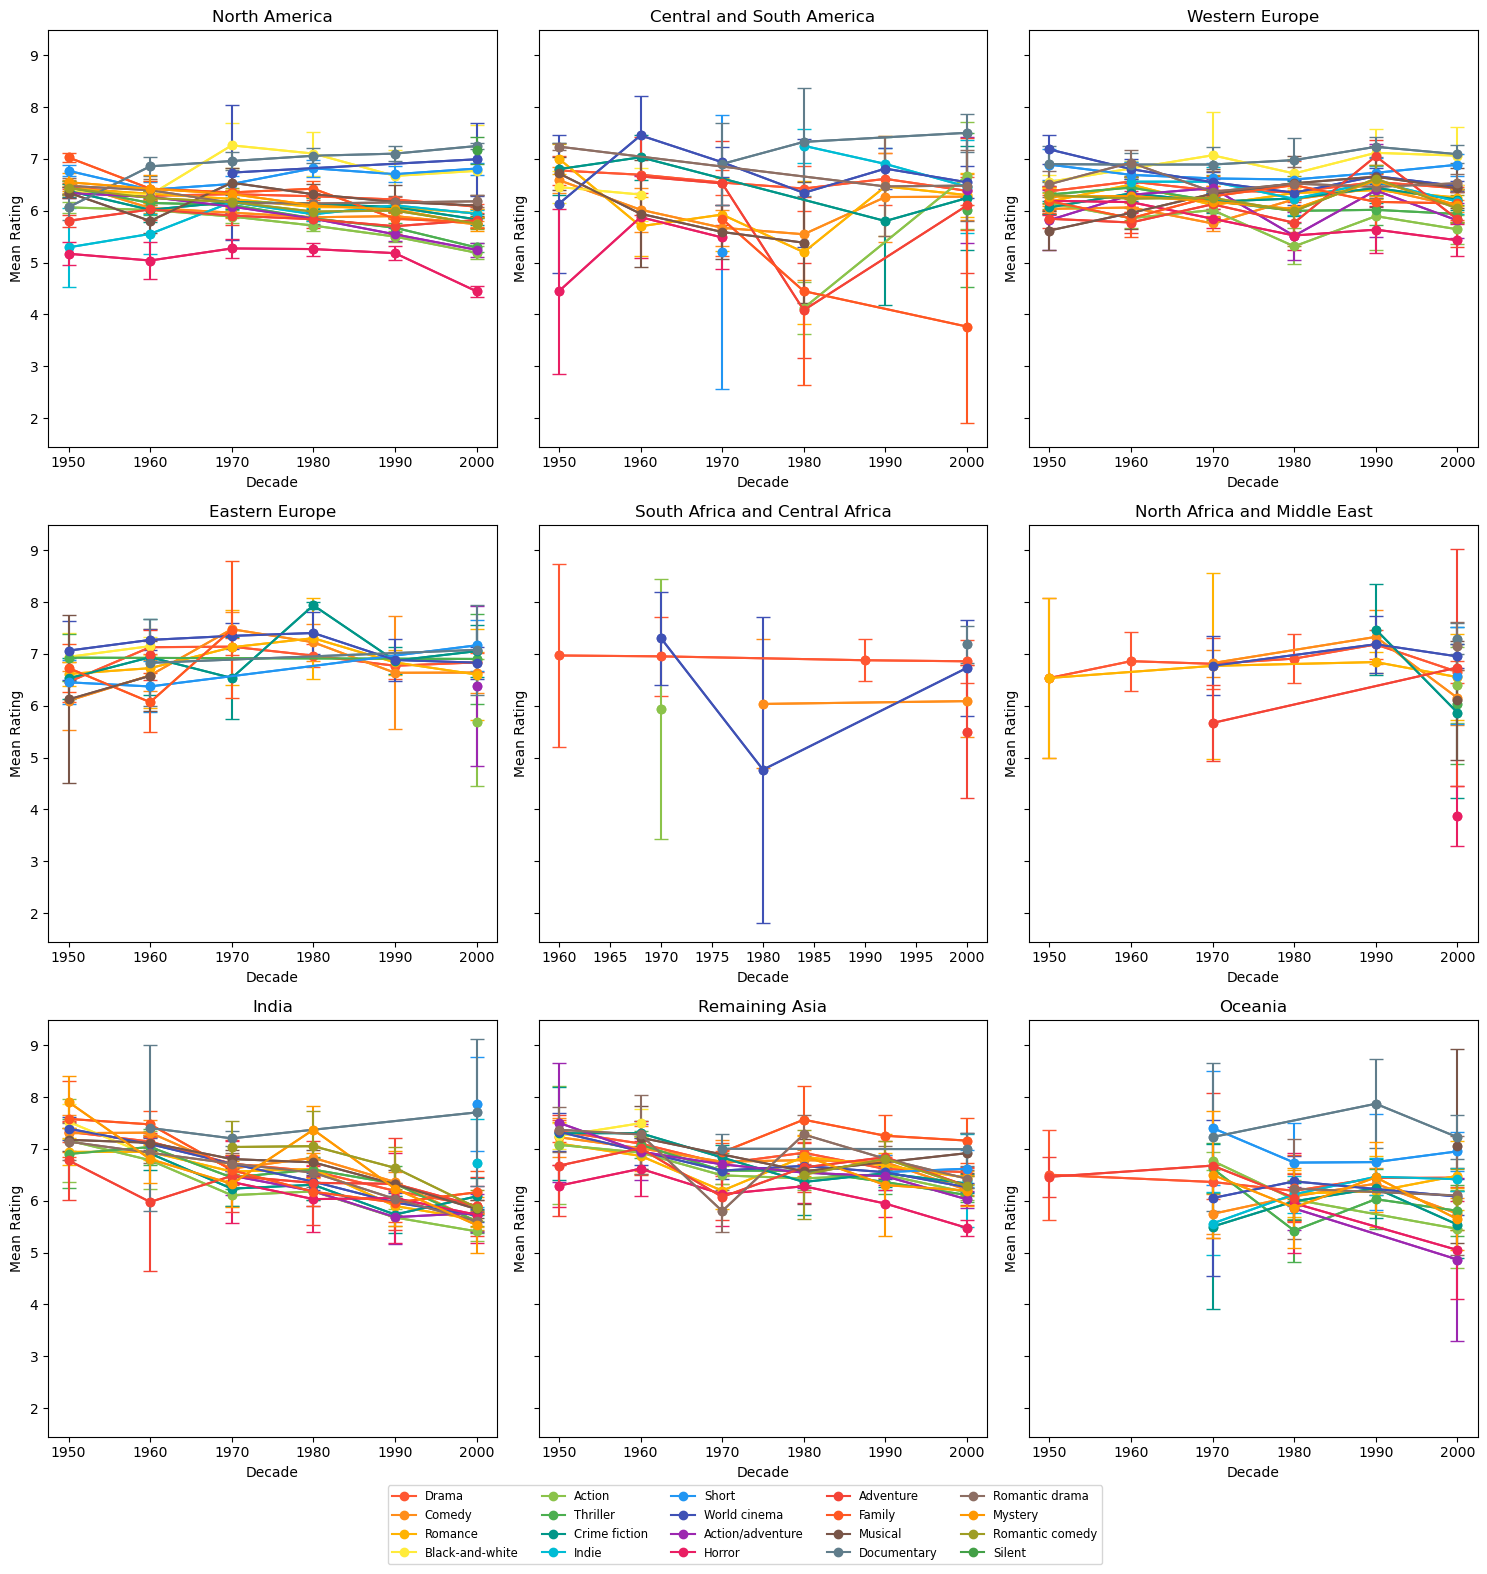

In [69]:
# plotting the results
ratings_visualizations.plot_region_genre_ratings(
    mean_ratings,           
    confidence_intervals,   
    decades,                
    top_20_genres,     
    genres_colors                  
)

As the above plots aim to identify regional trends in genre ratings over time, and our analysis includes 20 genres, these plots are quite tricky to visualize for microscopic details. However, general time-dependencies can be noticed. Unlike Western Europe, mean ratings in India irrespective of their movie genre have seen a nearly two-point decrease in ratings since 1950. In addition, Eastern Europe shows a weak yet apparent increase in movie ratings over time, whereas the remaining asia region experiences a bump of ratings in the 70s which has since diminished. This indicates that regional differences in trends of ratings over time for all genres considered in our analysis are not constant. Therefore, this analysis suggests that release date alongside regional and genre attributes of movies are required to differentiate their ratings in future supervised classification.


As we previously mentioned, as there are 20 overlapping genres in these figures, visual analysis becomes tricky. Instead, we can turn our attention to the top 6 genres presented in our cleaned movies datatset to make the observations more readable.

In [70]:
# getting the top 6 genres as a list
top_6_genres = df_movies_ratings_imdb['genres'].value_counts().head(6).index.tolist()

In [71]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# binning movies into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [72]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_6_genres,               
    list(regions.keys()),                         
    decades               
)

In [73]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_region_decade_statistics(
    df_movies_ratings_region_decadefilled,
    list(regions.keys()),
    top_6_genres,
    decades  
)

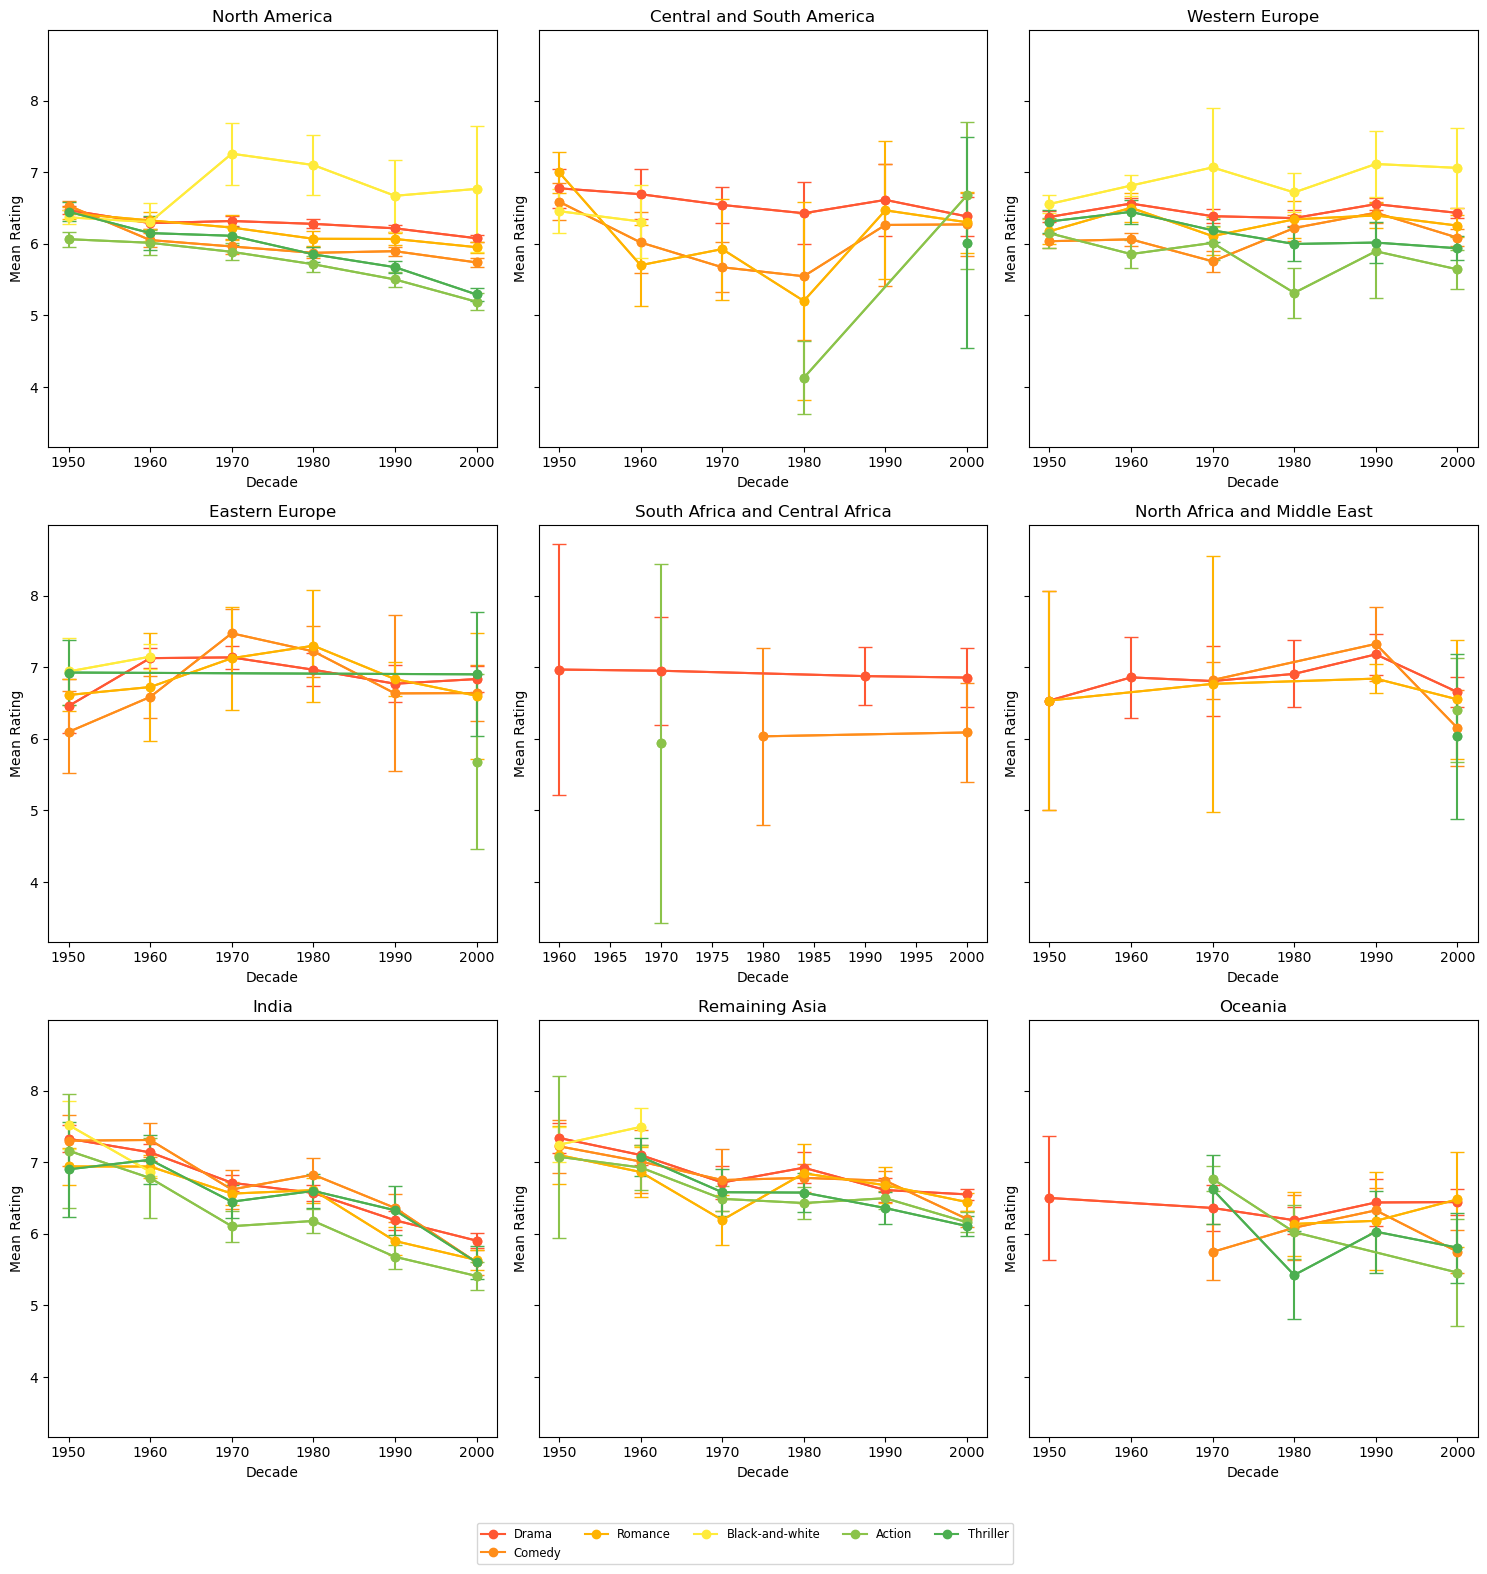

In [74]:
# plotting the results
ratings_visualizations.plot_region_genre_ratings(
    mean_ratings,           
    confidence_intervals,   
    decades,                
    top_6_genres,     
    genres_colors                  
)

Focusing on only 6 genres, trends previously unidentifiable can be retrieved. In some regions, like India (row 3, column 1) rating trends for all genres are similar and follow the same descending path. In regions like 'South Africa and Central Africa' (row 2, column 2), the lack of data already highlighted in previous notebook cells makes the time series impossible to visualize. Interestingly, movies out of the remaining asia region show a decrease in ratings for these top 6 genres over time, a trend previously unidentified when considering all 20 genres in this region together. This further underscores the need to have regional, genre, and time specific features of movies considered in rating predictions to pick up on their full profile.

Given the information gained about movie ratings across regions, a similar set of visualizations can be made by grouping movies by their genres instead of regions as to reveal region-specific average rating trends in time.

In [75]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# binning movies into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [76]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_6_genres,               
    list(regions.keys()),                         
    decades               
)

In [77]:
# compute mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_genre_region_decade_statistics(
    df_movies_ratings_region_decadefilled, 
    top_6_genres,                             
    list(regions.keys()),                           
    decades                              
)

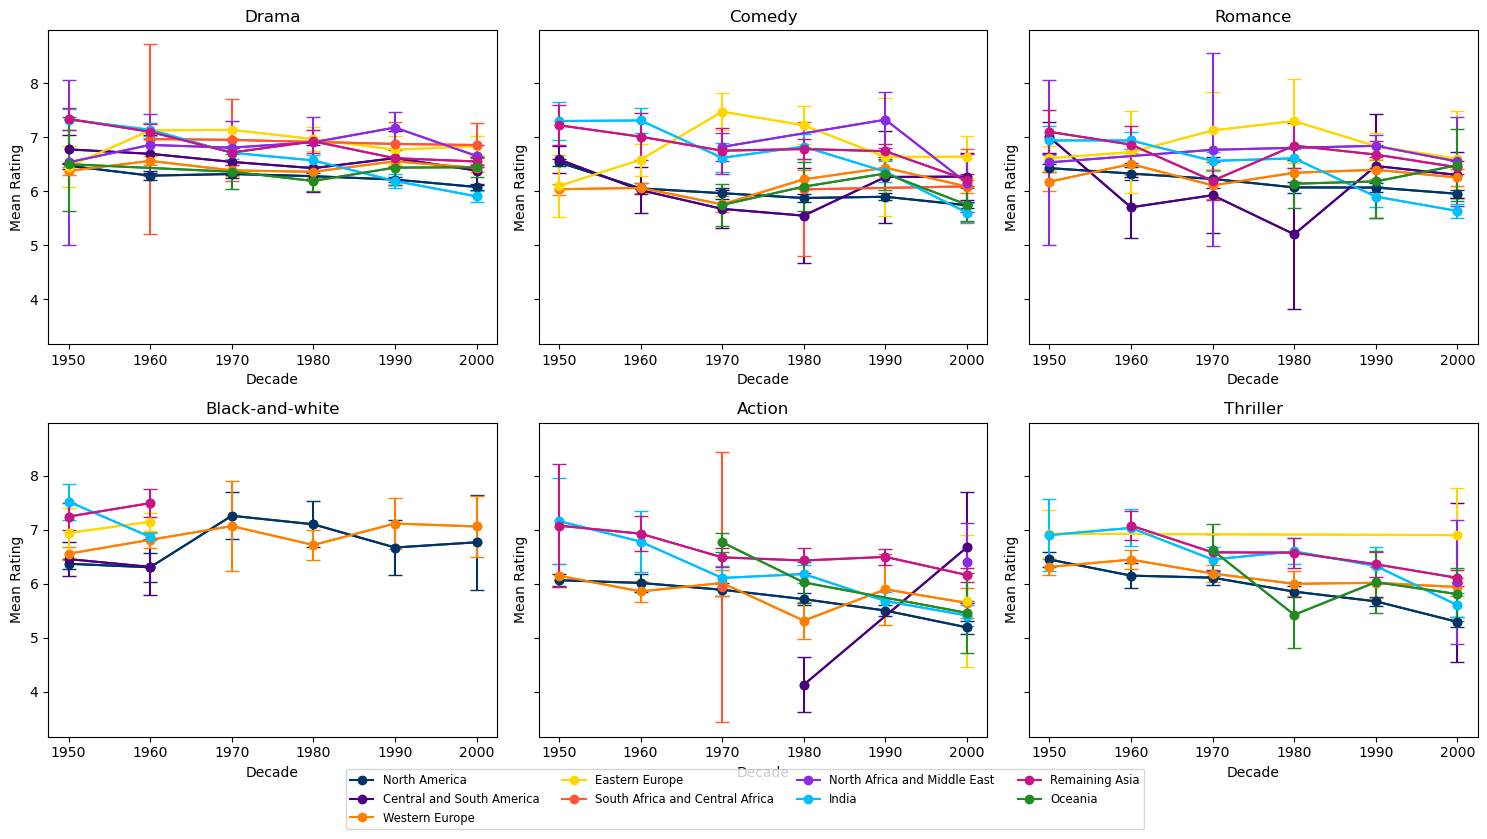

In [78]:
# plotting the results
ratings_visualizations.plot_genre_region_mean_ratings(mean_ratings, 
    confidence_intervals,
    list(regions.keys()),
    decades,
    regions_colors
)

The above visualization provides information about rating trends across decades for genres across regions. As there are only nine possible lines, based on the availability of a genre's data, we can scale up the scope of such a figure panel to encompass across all 20 genres of our analysis the region-specific development of ratings.

In [79]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# binning movies into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [80]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_20_genres,               
    list(regions.keys()),                         
    decades               
)

In [81]:
# compute mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_genre_region_decade_statistics(
    df_movies_ratings_region_decadefilled, 
    top_20_genres,                             
    list(regions.keys()),                           
    decades                              
)

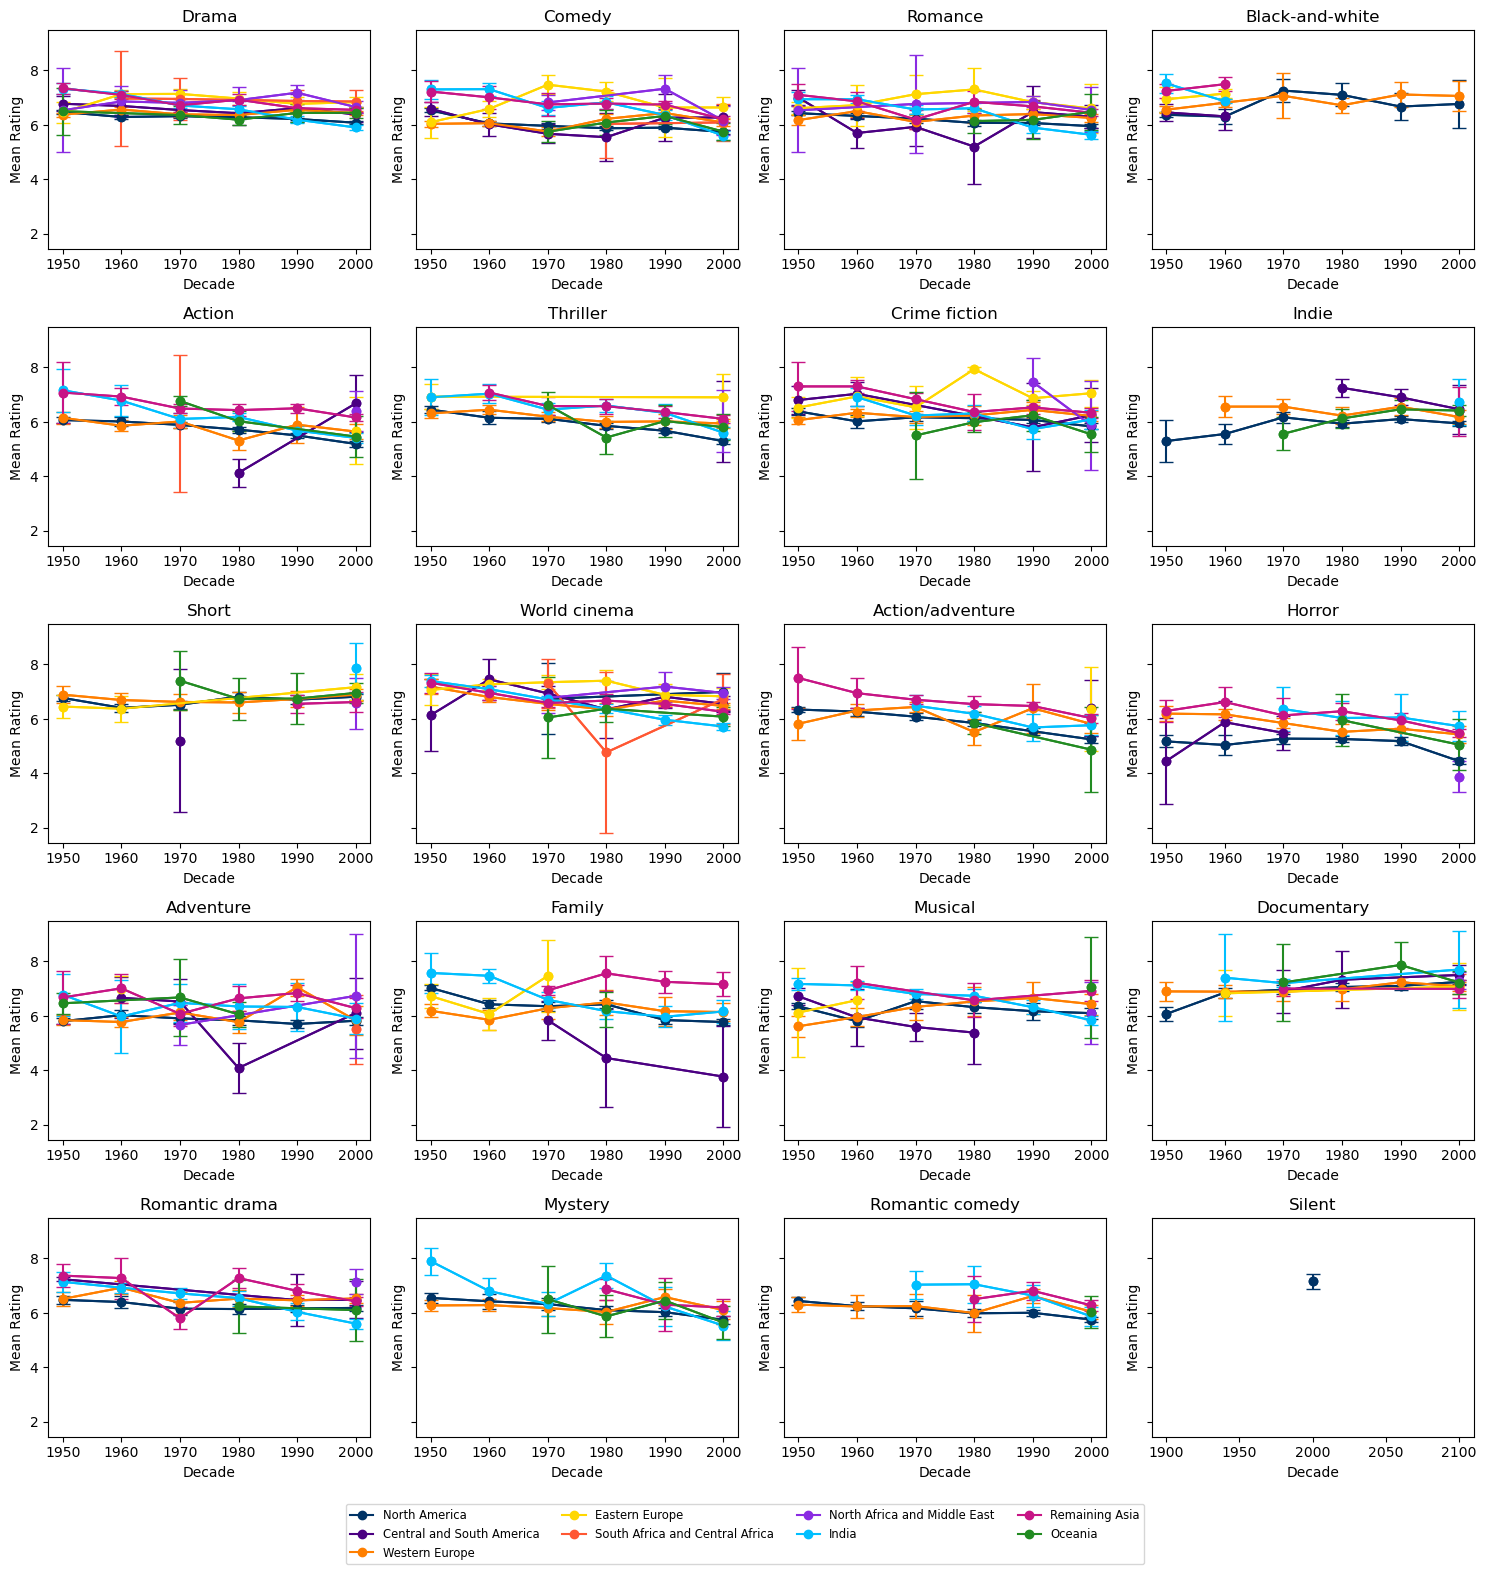

In [82]:
# plotting the results
ratings_visualizations.plot_genre_region_mean_ratings(mean_ratings, 
    confidence_intervals,
    list(regions.keys()),
    decades,
    regions_colors,
    (5, 4)
)

The presented figure panel is critical in our final datastory website as differences in a given genre's ratings per region can be clearly observed. As this seperation of ratings by genre and region is presented over time, regional, genre-specific, and time-dependent analyses of average movie ratings are brought together in these plots. Although hard to observe in this overlaid way, numerous conclusions can be drawn from these subfigures.

North America generally underperforms relative to Western Europe across most genres, with the disparity particularly pronounced in horror movies. In contrast, Eastern Europe often surpasses Western Europe, especially in dramas and crime fiction, where its ratings were significantly higher in the 1980s. India shows a marked decline in ratings across several genres, transitioning from outperforming Western Europe in earlier decades to underperforming by the 1980s, particularly in dramas, comedies, musicals, and mysteries. Oceania closely mirrors Western European trends in several genres, while Central and South America exhibit unique dynamics, such as a significant post-1980s rise in action movie ratings, contrasting with declines in North America and India. North Africa and the Middle East have seen their ratings converge with Western Europe by the 2000s. Romance films display minimal regional disparities, but data gaps persist for African regions, especially Central and South Africa, except for sporadic representation in family and horror genres. These patterns underscore significant shifts in regional cinematic performance and the influence of data availability on understanding global trends.

## 3.2 - Ratings statistical significance analysis

Although those graphical insights are clear and help in gaining an understanding of the interplay of movie genres, regions, and release date on their ratings, this section aims to analyze the significance of these observations. 

Considering there is complete independency of movies between genres, as no movies were exploded for country, no movies can be counted in more than one region. Hence, the ratings across regions are independent, and are assumed to be normally distributed. Thus, ANOVA is performed to determine if within a given genre their ratings by region are statistically significantly different. The hypotheses tested for this analysis follow:
- H_o = the null hypothesis: There is no significant difference among a given genre's rating means across movie regions.
- H_a = the alternative hypothesis: There is a significant difference among a given genre's rating means across movie regions heatmap of p-values.

In [83]:
# computing p_values from ANOVA testing for each genre
p_values = ratings_statistics.calculate_genre_anova_p_values(
    df_movies_ratings_regionfilled,
    top_20_genres,
    list(regions.keys())
)

# converting above results to a dataframe
df_genre_region_p_value = pd.DataFrame(list(p_values.items()), columns=['Genre', 'p_value'])

# log transformation for better visualization
df_genre_region_p_value['log_p_value'] = -df_genre_region_p_value['p_value'].apply(lambda x: np.log10(x) if x > 0 else None)

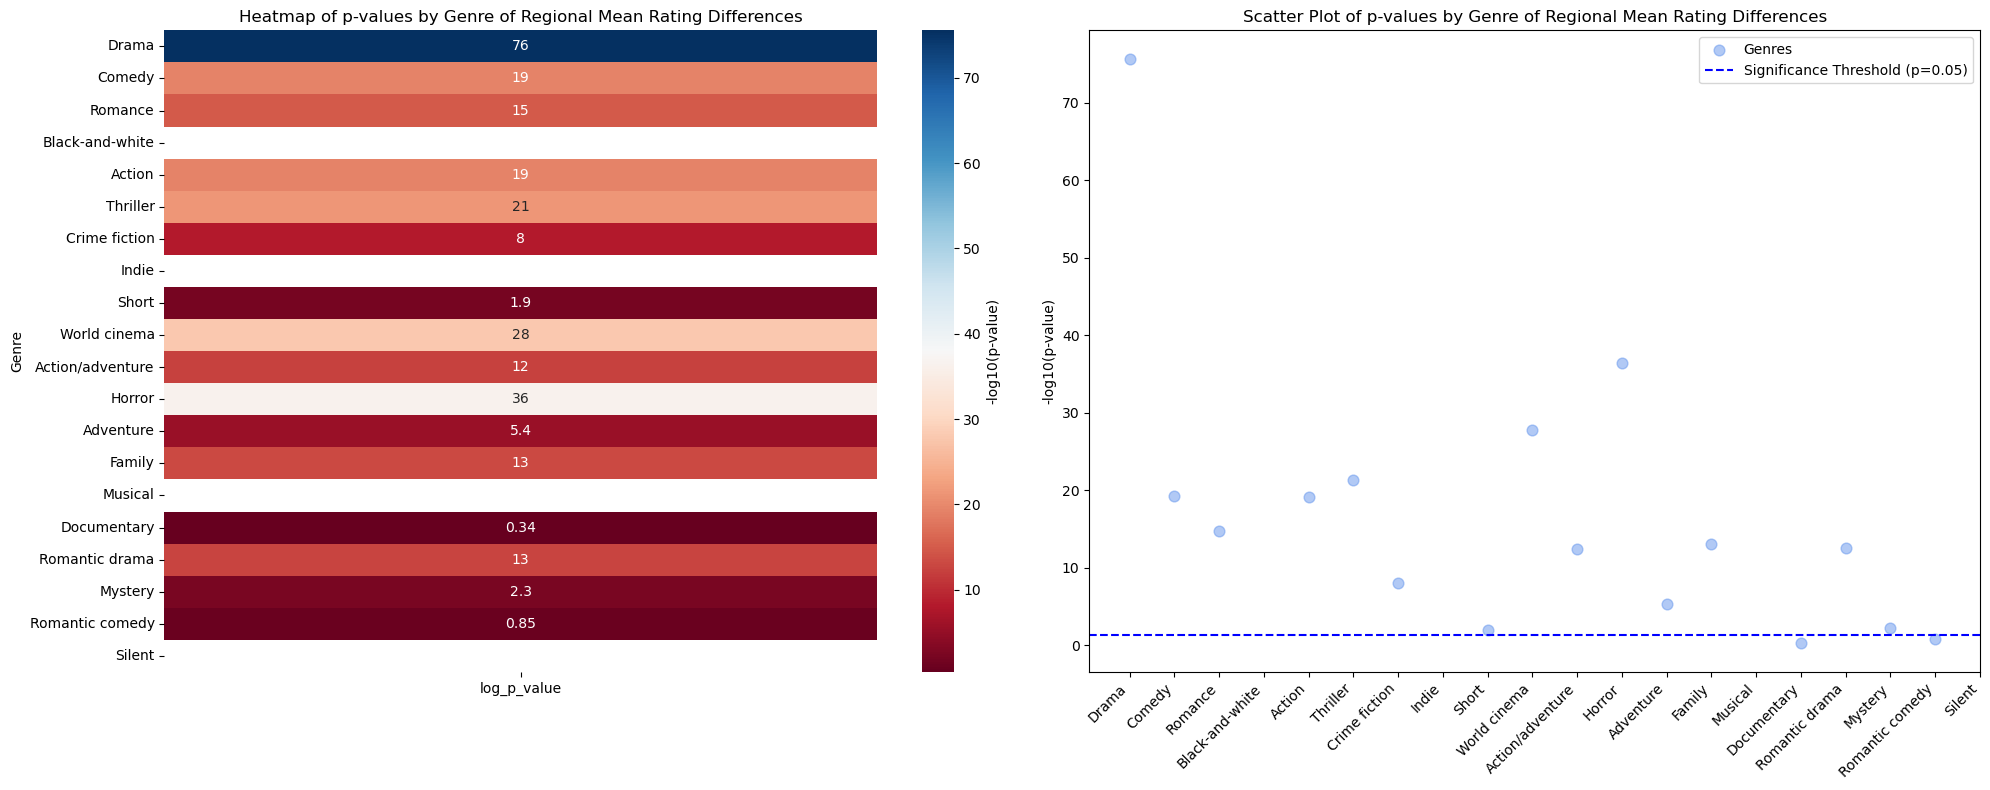

In [84]:
# preparing heatmap and scatterplot figure
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# plotting heatmap
sns.heatmap(df_genre_region_p_value.set_index('Genre')[['log_p_value']], annot=True, cmap='RdBu', cbar_kws={'label': '-log10(p-value)'}, ax=axes[0])
axes[0].set_title('Heatmap of p-values by Genre of Regional Mean Rating Differences')

# plotting scatter plot
axes[1].scatter(top_20_genres, df_genre_region_p_value['log_p_value'], s=60, color='cornflowerblue', alpha=0.5, label='Genres')

# adding significance threshold line
axes[1].axhline(y=-np.log10(0.05), color='blue', linestyle='--', label='Significance Threshold (p=0.05)')
axes[1].set_xticks(range(len(top_20_genres)))
axes[1].set_xticklabels(top_20_genres, rotation=45, ha='right')
axes[1].set_ylabel('-log10(p-value)')
axes[1].set_title('Scatter Plot of p-values by Genre of Regional Mean Rating Differences')
axes[1].legend()

plt.tight_layout()
plt.show()

Most movies genres reject that there is no statistically significant difference in their ratings across regions and therefore we consider regional differences to have an impact on the mean ratings per genre. Documentaries and romantic comedies are the sole movies that fail to conclude a statistically significant difference in their mean ratings seperated by movie country.

Now we aim to understand if there is significance in the mean ratings across genres for a given movie region. For this, new hypothesis tests are prepared:

- H_o = the null hypothesis: There is no significant difference among a given region's mean ratings across genres
- H_a = the alternative hypothesis: There is a significant difference among a given region's mean ratings across genres

As there are some movies that appear in more than one genre, then we have to consider that we are in a situation where our samples are not entirely independent, which is a requirement for using one-way ANOVA testing, and hence the sample ratings may not fit a normal distribution. As a result, a Kruskal-Wallis Test is used per regional groupign of movies. A linear-mixed model would also be applicable for such an analysis, however, this test requires a linear relationship between the ratings and genre hot-encoded features, which we cannot prove. The Kruskal-Wallis Test is therefore called on each regional grouping.

In [85]:
# performing Kruskal-Wallis and printing results
ratings_statistics.analyze_genre_ratings_by_region(df_movies_ratings, list(regions.keys()))

Results for region: North America
Kruskal-Wallis Statistic: 4016.9537, p-value: 0.0000
The null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in North America.

--------------------------------------------------

Results for region: Central and South America
Kruskal-Wallis Statistic: 91.6798, p-value: 0.0000
The null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in Central and South America.

--------------------------------------------------

Results for region: Western Europe
Kruskal-Wallis Statistic: 815.2140, p-value: 0.0000
The null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in Western Europe.

--------------------------------------------------

Results for region: Eastern Europe
Kruskal-Wallis Statistic: 24.0532, p-value: 0.1941
The null hypothesis is failed to 

## 3.3 - Genre, time and regions on ratings statistics

Since we've already established that ratings per genre are different for different regions and vice-versa, we now want to see the evolution per decade of these ratings for different region-genre combinations. To do that, we calculate the mean rating for each genre-region per decade, treating them as different subjects, and consider the rating as measured for each decade. This assumes that the ratings for a specific genre-region combination are dependent across decades, which is a key assumption for using repeated-measures ANOVA.

The repeated-measures ANOVA test requires that each genre-region combo has at least one rating per decade, thus we'll be using `df_movies_ratings_region_decadefilled`. The null hypothesis is the following:

- H_o = the null hypothesis: There is no significant difference among a given region-genre combination of movies ratings across time.
- H_a = the alternative hypothesis: There is a significant difference among a given region-genre combination of movies ratings across time.

In [86]:
# creating unique identifier for genre-region combinations
df_movies_ratings_region_decadefilled['genre_region'] = (
    df_movies_ratings_region_decadefilled['genres'] + "-" +
    df_movies_ratings_region_decadefilled['region']
)

# converting to category
df_movies_ratings_region_decadefilled['decade'] = df_movies_ratings_region_decadefilled['decade'].astype('category')
df_movies_ratings_region_decadefilled['genre_region'] = df_movies_ratings_region_decadefilled['genre_region'].astype('category')

In [87]:
# fitting the model with interaction between decade and genre_region
model = ols("averageRating ~ C(decade) * C(genre_region)", data=df_movies_ratings_region_decadefilled).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Table:")
print(anova_table)

ANOVA Table:
                                 sum_sq       df           F         PR(>F)
C(decade)                   1442.595956      5.0  266.264071  3.527453e-282
C(genre_region)            13310.275508    179.0   68.623344   0.000000e+00
C(decade):C(genre_region)   9037.584703    895.0    9.318955   0.000000e+00
Residual                   57881.747174  53417.0         NaN            NaN


Looking at the 'C(decade):C(genre_region)' row in the ANOVA table, a significant p-value means the effect of decade on ratings differs by genre_region.
Now, residuals are retrieved to plot in a Q-Q plot and to plot to see how they are spread with respect to fitted values.

In [88]:
# extracting model residuals
residuals = model.resid
fitted_values = model.fittedvalues

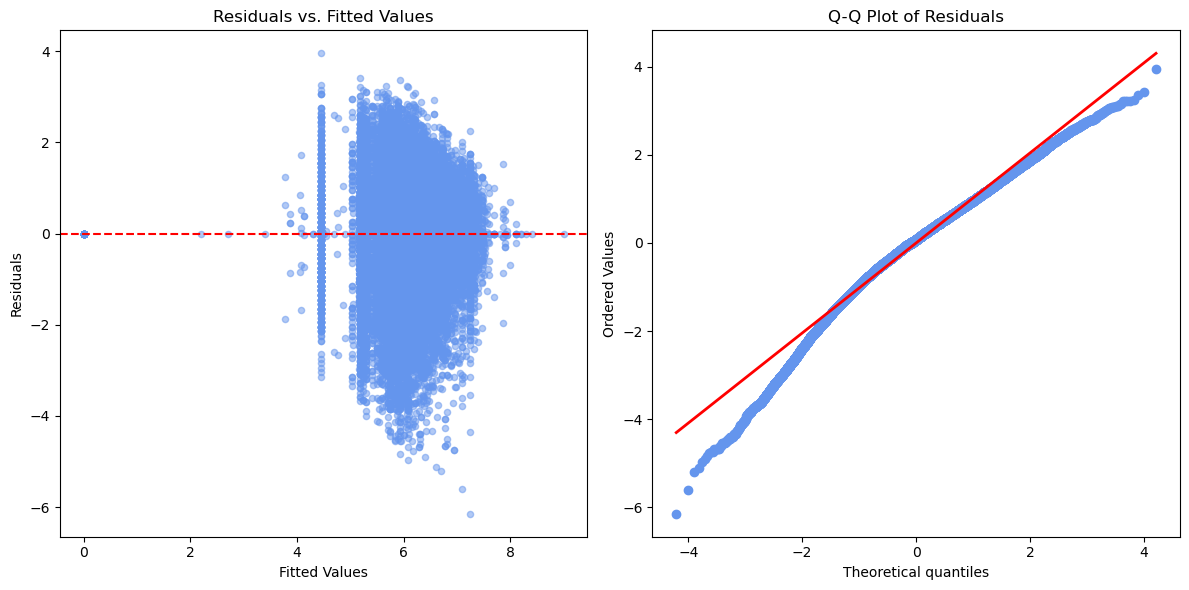

In [89]:
# preparing figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# plotting residuals vs. fitted values
axes[0].scatter(fitted_values, residuals, **styles['scatter_style'])
axes[0].axhline(y=0, color="r", linestyle="--")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs. Fitted Values")

# Q-Q plot for residuals
stats.probplot(residuals, dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot of Residuals")

# line settings
axes[1].get_lines()[0].set_color('cornflowerblue') 
axes[1].get_lines()[0].set_linewidth(2)
axes[1].get_lines()[1].set_color('red') 
axes[1].get_lines()[1].set_linewidth(2)

plt.tight_layout()
plt.show()

For every fitted value in x we have a homogeneous spread so we consider the homogenity of varience to be suitable for our analysis. 

To better understand the trends, of which we only had an intuition in the previous sections, the top and worst performing genres must be found. These top and worst performing genres are related to a specific region, for consecutive decades.

In [90]:
# converting 'decade' column to numeric (integer)
df_movies_ratings_region_decadefilled['decade'] = pd.to_numeric(df_movies_ratings_region_decadefilled['decade'], errors='coerce')

In [91]:
# calculate_slopes() call to compute slopes of average ratings between consecutive periods for movies grouped by specified columns
df_slopes = ratings_statistics.calculate_slopes(
    df_movies_ratings_region_decadefilled,
    ['region', 'genres'],
    'decade',
    'averageRating'
)

In [92]:
# identify_top_and_worst_genres() to identify the genres with the steepest and shallowest slope in ratings 
# for each region and consecutive decade pair
df_top_worst = ratings_statistics.identify_top_worst_genres(df_slopes)

In [93]:
# defining decades and regions for visualization
decade_pairs = sorted(df_top_worst[['decade1', 'decade2']].drop_duplicates().values.tolist())
regions_unique = sorted(df_top_worst['region'].unique())

# flattening the decade pairs for visualization
decade_labels = [f"{d1}-{d2}" for d1, d2 in decade_pairs]

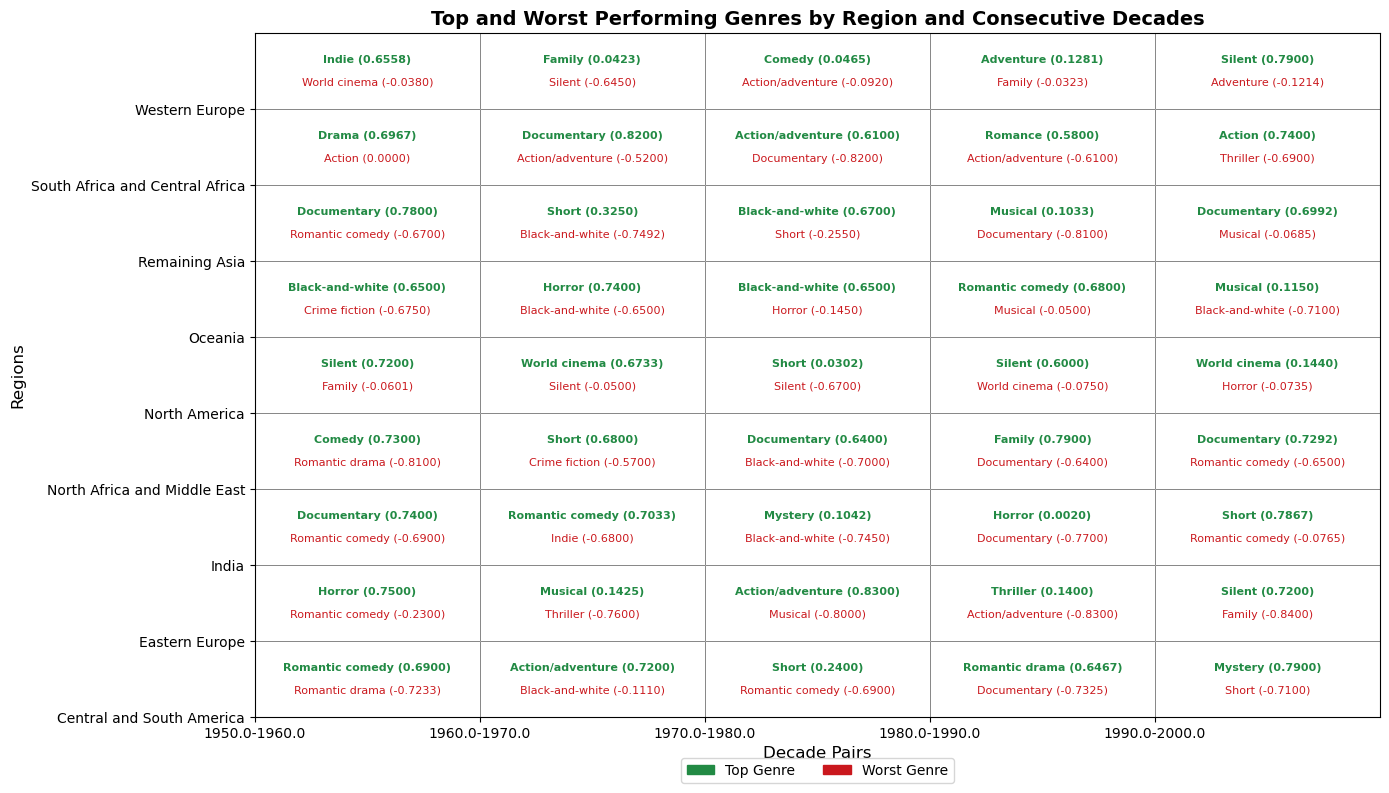

In [94]:
# plot_top_worst_genres() call, to create a grid plot visualizing the top and worst-performing genres 
# across regions and consecutive decade pairs
ratings_visualizations.plot_top_worst_genres(
    top_worst_df=df_top_worst,
    regions=regions_unique,
    decade_labels=decade_labels,
    decade_pairs=decade_pairs,
)

From this table, evolution of genre preferences are also highlighted, together with some apparent contradictions. For example, isn't it strange that 'Romantic comedy' and 'Romantic drama' are at the same time, in the same region (Central and South America) the top and most performing genres?

The anova on slopes test is performed for all genre-regions combinations, to answer to the question: are there meaningful changes in ratings over decades?

In [95]:
# anova_on_slopes() call to perform ANOVA on the slopes of average ratings between different decades 
# for specified genre-region combinations
anova_results_df, significant_results_df = ratings_statistics.anova_on_slopes(
    df_movies_ratings_region_decadefilled,
    top_6_genres,
    regions_unique
)

print("Significant Results:")
significant_results_df.head(5)

Significant Results:


genre          region     f_stat  anova_p_value  kruskal_stat  \
1  Drama  Eastern Europe   4.874727   2.670461e-04     16.975513   
2  Drama           India  49.856161   7.811295e-49    201.272168   
4  Drama   North America  18.414591   3.492335e-18     75.891697   
6  Drama  Remaining Asia  13.962152   4.150508e-13     80.543766   
8  Drama  Western Europe   3.959657   1.409835e-03     18.323417   

   kruskal_p_value  significant_anova  significant_kruskal  
1     4.546472e-03               True                 True  
2     1.517943e-41               True                 True  
4     6.060235e-15               True                 True  
6     6.457784e-16               True                 True  
8     2.567227e-03               True                 True

The first rows of the dataframe are printed above, a low p-value is associated to significant differences. 

### 3.3.1 - Arima model

We have proved interactions between region - genre now and we have proved that genre - regions pairs evoluate differently through time. Is it possible to capture these relationships and try to predict the ratings for certain genre - regions? or for some regions at least? 

To do that, we tried first to implement an Arima model which tries to capture and then predict ratings for each region. 

In [96]:
# categorization into 5-year bins to have more datapoints for ARIMA
df_movies_ratings_region_decadefilled["5yearbin"] = df_movies_ratings_region_decadefilled["release_date"].apply(cleaning.categorize_5_year)

# dropping unmatched '5yearbin' column entries
df_movies_ratings_region_decadefilled.dropna(subset=['5yearbin'], inplace=True)

# defining the 5 year bins of interest
five_year_bins = ["1950", "1955", "1960", "1965", "1970", "1975", "1980", "1985", "1990", "1995", "2000", "2005"]

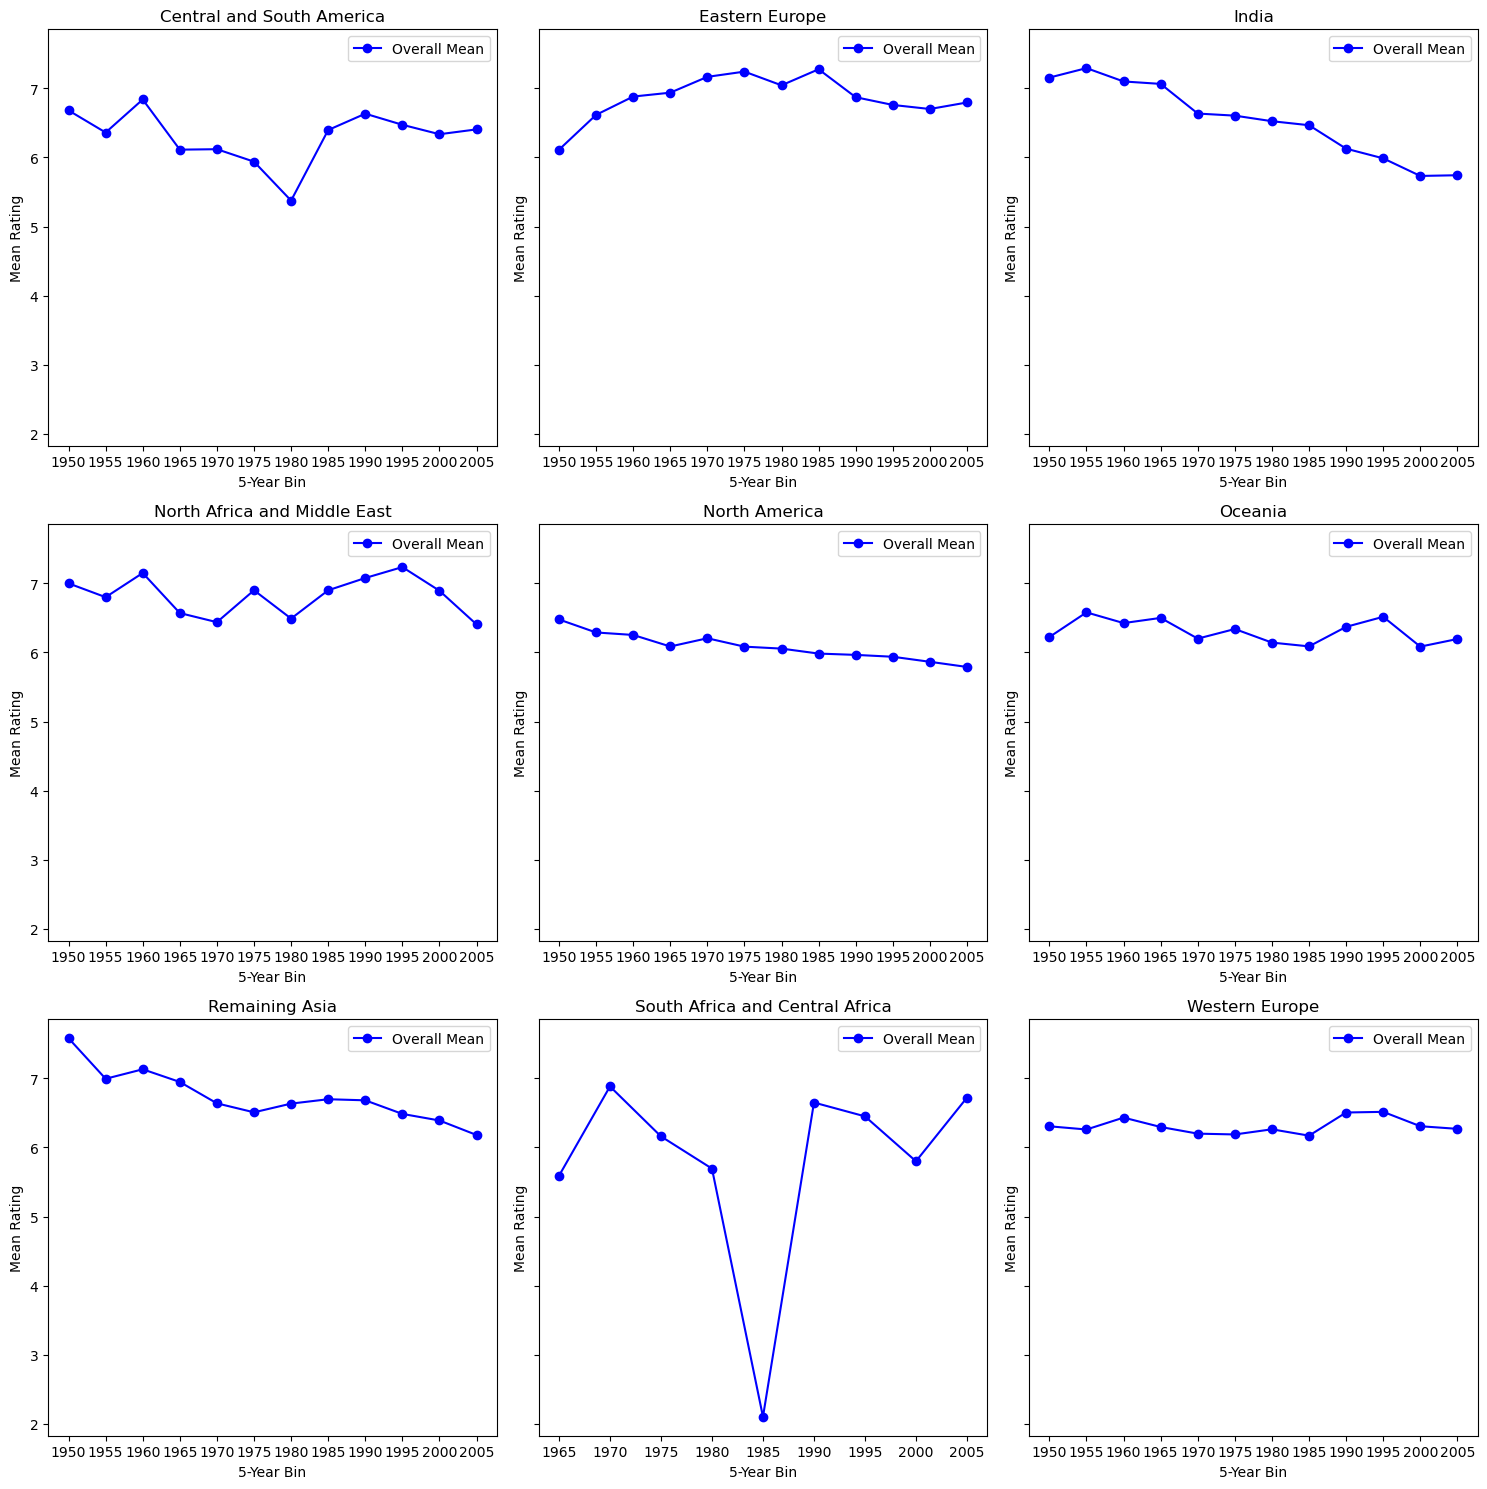

In [97]:
# computing overall means to then fit the Arima model
overall_means = ratings_visualizations.calculate_and_plot_overall_means(
    df_movies_ratings_region_decadefilled,
    regions_unique
)

--- Fitting AutoARIMA for Region: Central and South America ---
Best Model for Central and South America:  ARIMA(0,0,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: Eastern Europe ---
Best Model for Eastern Europe:  ARIMA(1,0,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: India ---
Best Model for India:  ARIMA(0,1,1)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: North Africa and Middle East ---
Best Model for North Africa and Middle East:  ARIMA(0,0,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: North America ---
Best Model for North America:  ARIMA(0,1,1)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: Oceania ---
Best Model for Oceania:  ARIMA(0,0,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: Remaining Asia ---
Best Model for Remaining Asia:  ARIMA(0,1,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: South Africa and Central Africa ---
Best Model for South Africa and Central Africa:  ARIMA(0,0,0)(0,0,0)[0] intercept
--- Fi

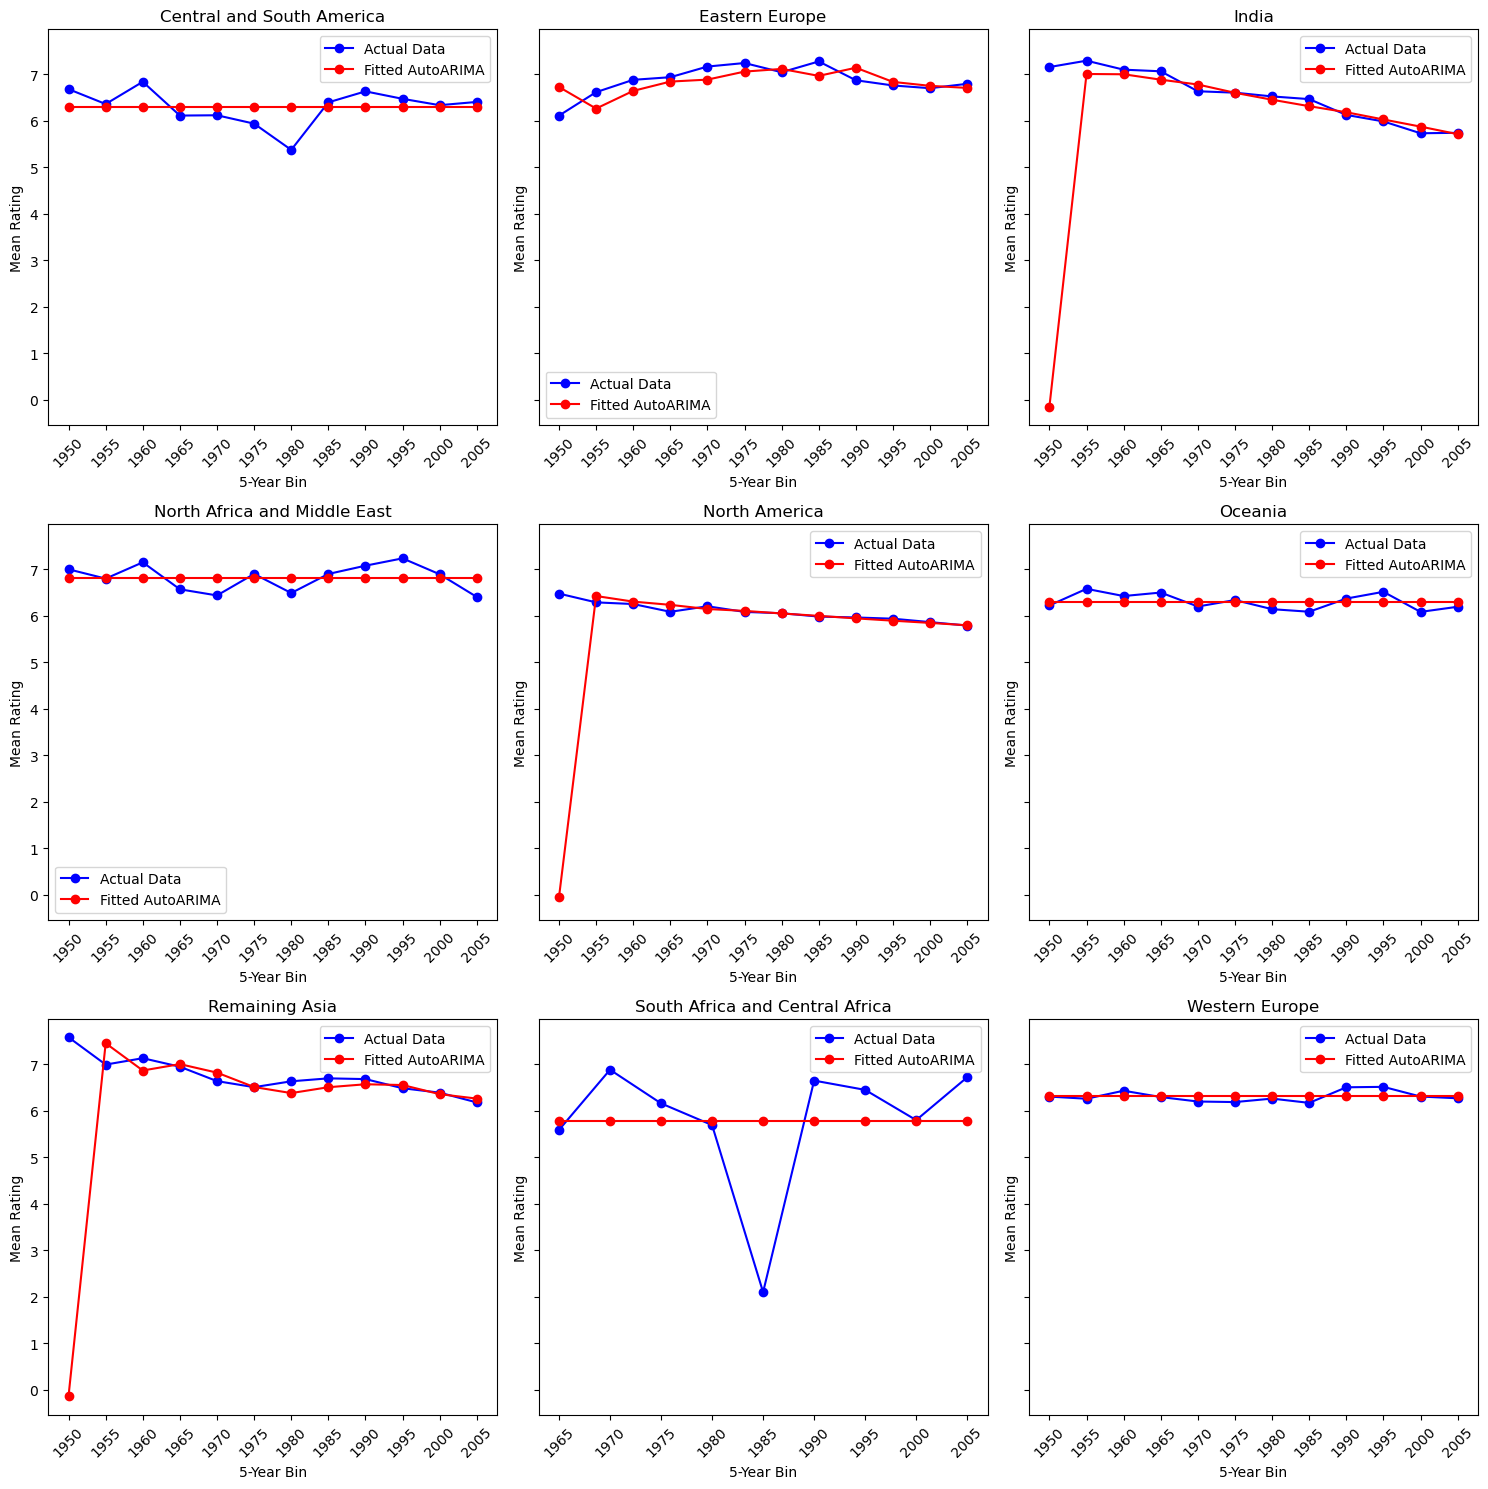

Region: Central and South America --> RMSE: 0.3714, R²: 0.0000
Region: Eastern Europe --> RMSE: 0.2696, R²: 0.2163
Region: India --> RMSE: 2.1128, R²: -15.1319
Region: North Africa and Middle East --> RMSE: 0.2720, R²: 0.0000
Region: North America --> RMSE: 1.8861, R²: -100.2430
Region: Oceania --> RMSE: 0.1659, R²: 0.0000
Region: Remaining Asia --> RMSE: 2.2334, R²: -37.6498
Region: South Africa and Central Africa --> RMSE: 1.3760, R²: 0.0000
Region: Western Europe --> RMSE: 0.1113, R²: -0.0000


In [98]:
# fitting and plotting the Arima model
fitted_models, forecast_results, error_metrics = ratings_visualizations.fit_autoarima_models(overall_means)

The AutoARIMA model fits varied significantly across regions. While RMSE values are generally low for most regions, indicating small absolute prediction errors, the R² scores are poor or negative for many regions. This suggests that the model often fails to explain variance effectively, especially for regions like India, North America, and Remaining Asia, where R² scores are heavily negative, reflecting poor model performance. The model performs better in Eastern Europe (moderate R² = 0.2166). Overall, the AutoARIMA model struggles to capture trends accurately across most regions, highlighting the need for better-suited modeling approaches.

Now, the model is used to try the forecasting of ratings based on actual data. The graphs below refer to 'India', 'North America' and 'Western Europe'.

--- Forecasting for Region: India ---
--- Forecasting for Region: North America ---
--- Forecasting for Region: Western Europe ---


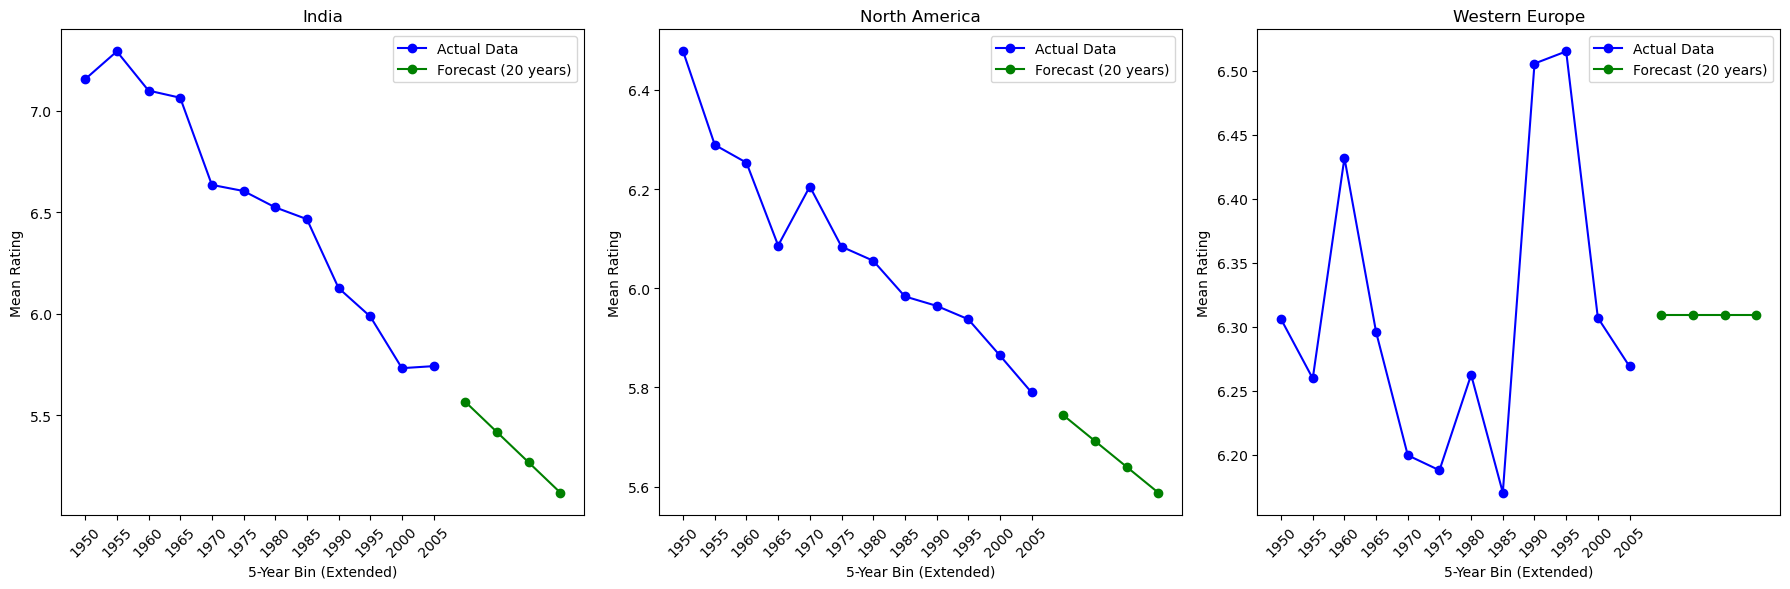

In [99]:
# trying to forecats on some selected regions ("India", "North America", "Western Europe")
future_predictions = ratings_visualizations.forecast_regions(fitted_models, overall_means)

In the above graphs, the model's predictions for 'India' and 'North America' look quite similar. The actual data shows a steeply decrease in the mean rating in both cases, therefore the model predicts this tendency to continue. On the other hand, the actual data for 'Western Europe' looks much less predictable, due to its fluctuations and changes. Indeed, the model forecast just stabilizes on what it seems to be a mean value for the mean rating.
To conclude, it is evident how 'standard' ways to predict mean ratings are not effective in the case of such complex objects, like movies. Therefore, an in-depth analysis must be conducted to provide a better prediction of the rating of a movie, based on the features provided.

# 4 - Features analysis

What drives a movie’s ratings? To explore this, we will investigate the data and features provided in our dataset, not only identifying the most relevant ones but also creating new ones when necessary. This approach aims to develop a robust set of features feed into our random forest model, enabling us to predict movie ratings more effectively.

In [100]:
# copies of the master dataframes to proceed with the analysis
df_movies_features = df_movies_ratings_imdb.copy()
df_movies_features_unique = df_movies_ratings_imdb_unique.copy()
df_characters_features = df_characters.copy()

## 4.1 - Number of actors

The first type of features to be analyzed is related to the actors cast for each movies. As a basic feature, it is easy to retrieve the number of actors that are starring in a single movie.

In [101]:
# nb of actors per movie = unique actors per movie as each entry of df_characters is a character in the movie 
actors_per_movie = df_characters.groupby('wikipedia_id')['freebase_actor_id'].nunique()

# mapping the count back to the original dataframe
df_movies_features['nb_actors'] = df_movies_features['wikipedia_id'].map(actors_per_movie)

In [102]:
# dropping missing values
df_movies_features = df_movies_features.dropna(subset=['averageRating', 'nb_actors'])

# printing basic stats
print(df_movies_features[['averageRating', 'nb_actors']].describe())

       averageRating     nb_actors
count    70755.00000  70755.000000
mean         6.14768      8.273507
std          1.08089      5.395348
min          1.10000      0.000000
25%          5.60000      4.000000
50%          6.30000      8.000000
75%          6.90000     11.000000
max          9.50000    115.000000


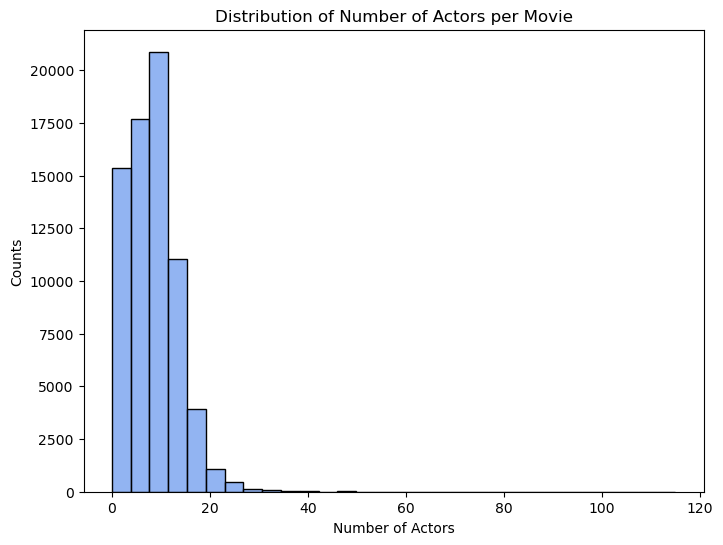

In [103]:
# plotting the distribution of the number of actors
plt.figure(figsize=(8, 6))
sns.histplot(df_movies_features['nb_actors'], bins=30, **styles['hist_style'])
plt.title("Distribution of Number of Actors per Movie")
plt.xlabel("Number of Actors")
plt.ylabel("Counts")
plt.show()

The above distribution is extremely left skewed, indicating that most of the movies have less than a 20 member cast.
Let us now analyze the correlation between the mean rating and the number od actors.

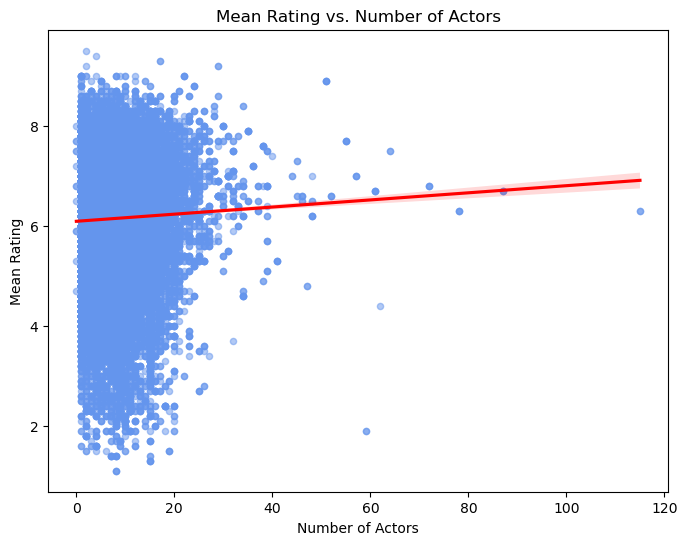

In [104]:
# scatter plot of nb of actors vs mean rating
plt.figure(figsize=(8,6))
sns.regplot(
    x='nb_actors', 
    y='averageRating', 
    data=df_movies_features, 
    scatter_kws=styles['scatter_style'], 
    line_kws=styles['line_style']
)
plt.xlabel('Number of Actors')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Number of Actors')
plt.show()

Most of the points in the scatter plot are situated in the left part of the graph, as we were expecting after seeing the previous plot. Moreover, the correlating seem to be positive, meaning that the larger the cast, the higher the rating. 
Let us now retrieve the Pearson and Spearman correlations between the mean rating and the number of actors to support our hypothesis.

In [105]:
# calculating Pearson correlation between averageRating and nb_actors
pearson_corr, pearson_p = pearsonr(df_movies_features['averageRating'], df_movies_features['nb_actors'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# calculating Spearman correlation between averageRating and nb_actors
spearman_corr, spearman_p = spearmanr(df_movies_features['averageRating'], df_movies_features['nb_actors'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: 0.0355, p-value: 0.0000
Spearman correlation: 0.0344, p-value: 0.0000


Both the correlations are positive, with a low p-value, confirming our initial hypothesis.

## 4.2 - Ethnicity score

Diving deeper into the cast analysis, the cast ethnicities are retrieved to understand if the audience judges a movie also based on the cast ethnicities. Cast ethinicity may be a better indicator rather than cast country of origin, since, when the cast is acting, their nationality is not known by the audience 'a priori' in general.

In [106]:
# merging character's data with master dataframe
df_movies_features_merged = pd.merge(df_characters_features[['wikipedia_id','actor_gender','actor_ethnicity','freebase_actor_id']],
                             df_movies_features_unique[['wikipedia_id','countries', 'title', 'release_date','genres','averageRating','region']], 
                             on='wikipedia_id', how='inner')

# filtering rows where both 'regions' and 'actor ethnicity' are not NaN
df_movies_features_merged = df_movies_features_merged.dropna(subset=['region', 'actor_ethnicity'])

In [107]:
# exploding the 'actor ethnicity' column to handle lists
df_movies_features_exploded = df_movies_features_merged.explode('actor_ethnicity')

# ethnicity representation by region through groupby()
region_ethnicity = df_movies_features_exploded.groupby(['region', 'actor_ethnicity']).size().unstack(fill_value=0)

# calculating percentages for each region
region_ethnicity = region_ethnicity.div(region_ethnicity.sum(axis=1), axis=0) * 100

Let us visualize now how the ethnicity of a specific region is represented by the cast diversity in movies produced in that specific region.

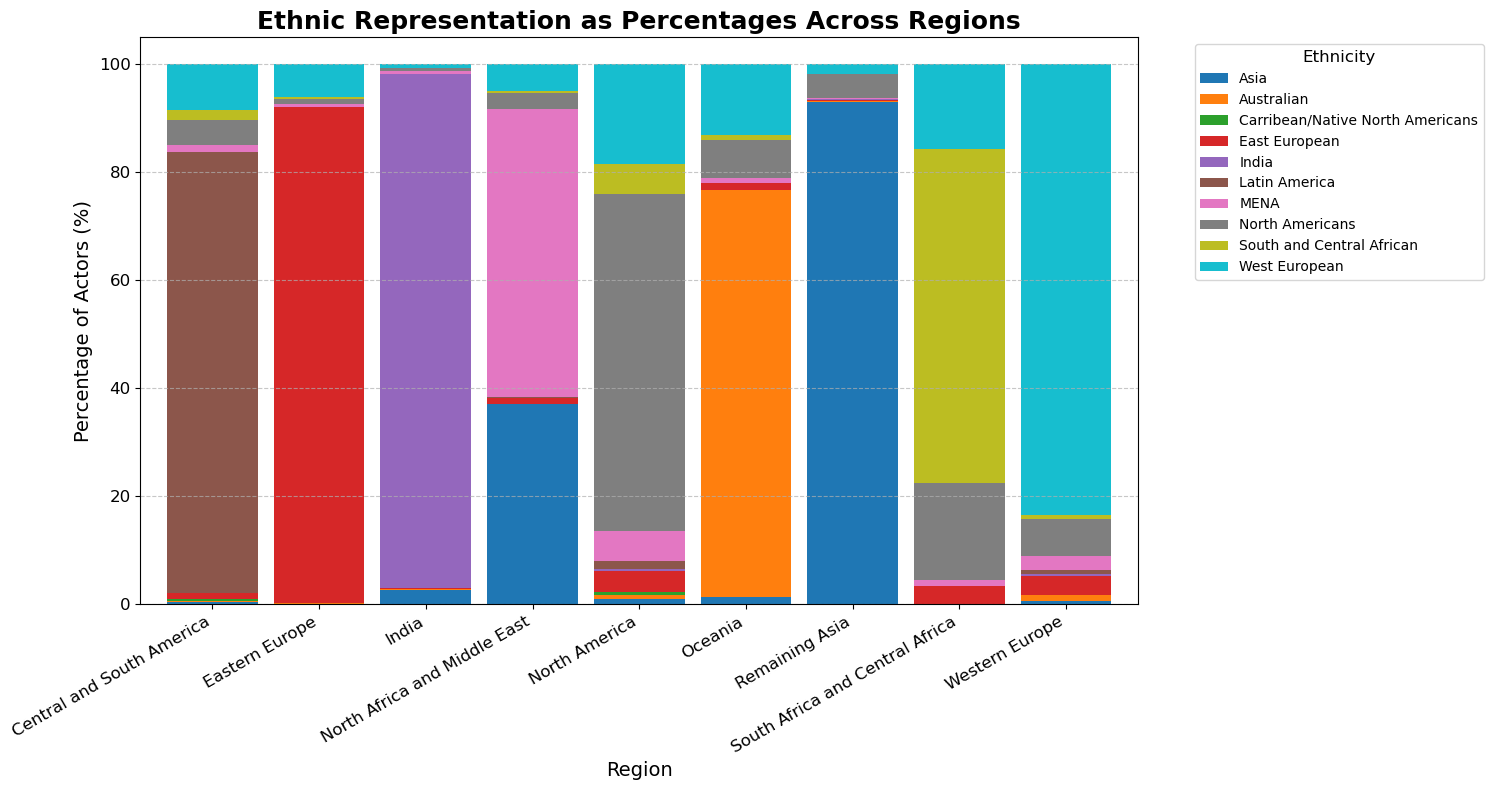

In [108]:
# plotting the stacked bar chart with percentages
plt.figure(figsize=(15, 8))

# stacked bar plot
region_ethnicity.plot(
    kind='bar',
    stacked=True,
    width=0.85,
    ax=plt.gca()
)

plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Regions", fontsize=18, fontweight='bold')
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

For most of the continents, like 'India', 'Oceania', Western Europe', the most present ethnicity is the one that is also present in the specific region. Moreover, it seems that the 'West European', as well as the 'North Americans', are ethnicities present in most of the regions, except for 'India'.

Since some of the ethnicities do not directly correspond to our regions, we need to have a mapping between the two. This mapping is contained in the `ethnicity_to_region` dictionary that is imported from `regions_clusters`.

In [109]:
# mapping the exploded ethnicity to standardized regions
df_movies_features_exploded['mapped_region'] = df_movies_features_exploded['actor_ethnicity'].map(ethnicity_to_region)

# dropping rows where mapping fails (unmatched regions)
df_movies_features_exploded = df_movies_features_exploded.dropna(subset=['mapped_region'])

In [110]:
# classifying as 'From Region' or 'Not From Region'
df_movies_features_exploded['region_category'] = df_movies_features_exploded.apply(
    lambda row: 'From Region' if row['region'] == row['mapped_region'] else 'Not From Region', axis=1
)

# grouping by 'region' and 'region_category' to count actors
region_category = df_movies_features_exploded.groupby(['region', 'region_category']).size().unstack(fill_value=0)

# converting counts to percentages
region_category = region_category.div(region_category.sum(axis=1), axis=0) * 100

# unstacking the data to prepare for grouped bar plotting
region_category = region_category.unstack().reset_index()
region_category.columns = ['Category', 'Region', 'Percentage']

# pivoting data to get Categories as columns (grouped bar structure)
region_category = region_category.pivot(index='Region', columns='Category', values='Percentage')

To avoid confusion and improve visualization, a further step must be made, by categorizing, for each region, the ethnicities that are from the region and the ones that are outsiders. 

<Figure size 1800x1000 with 0 Axes>

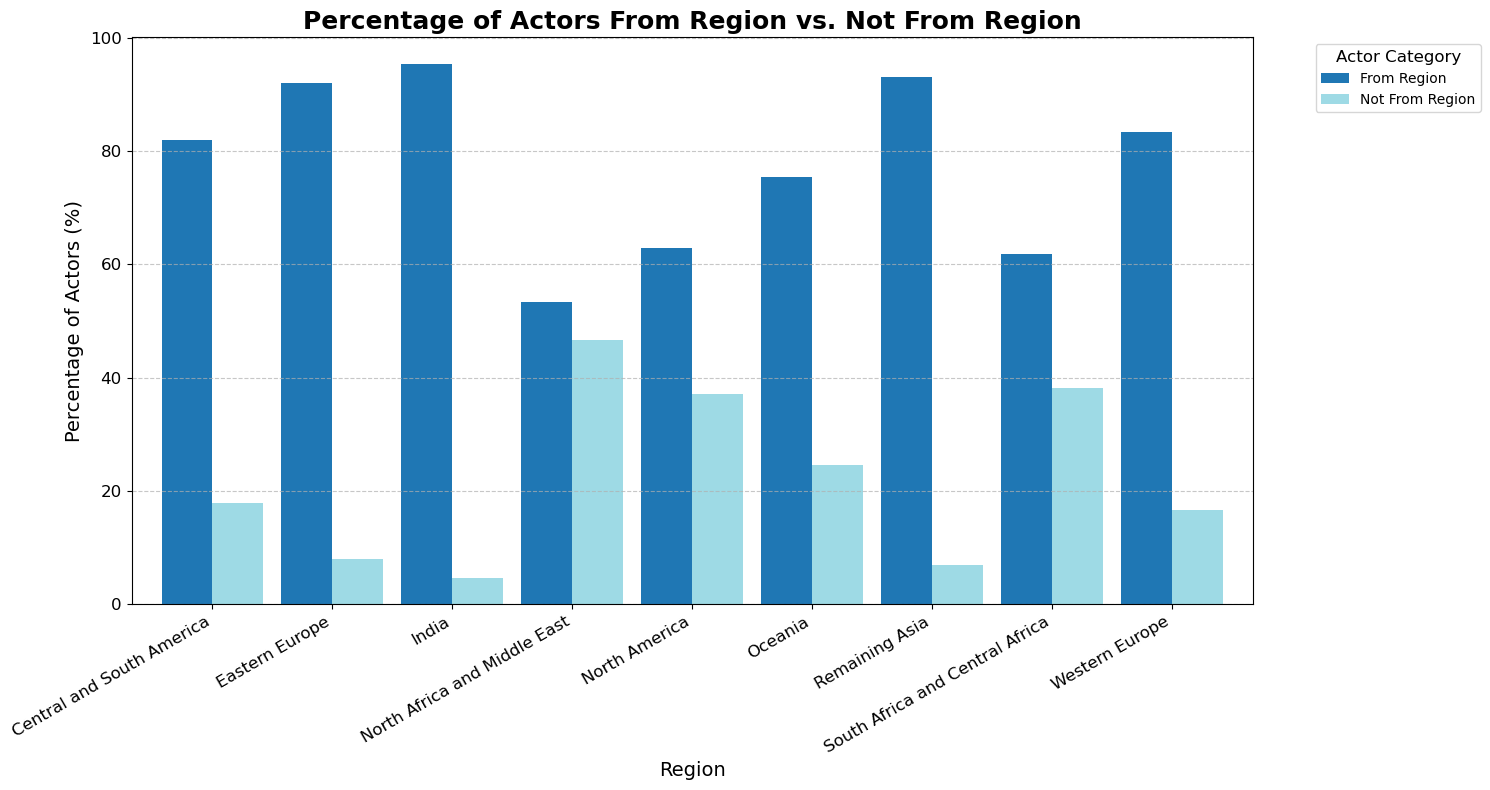

In [111]:
# plotting grouped bar chart for From Region vs. Not From Region
plt.figure(figsize=(18, 10))
region_category.plot(kind='bar', colormap='tab20', width=0.85, figsize=(15, 8))
 
plt.title("Percentage of Actors From Region vs. Not From Region", fontsize=18, fontweight='bold')
plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Actor Category", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

With this visualization, it is clear that, for all regions, the movies produced in a specific country also have a cast that is reflective of the population ethnicity. For example, almost all cast in movies produced in 'India' has also the 'Indian' ethnicity. The least 'represented' regions are 'North Africa and Middle East' and 'North America'.

What interests us is how the demographics of the cast members of one movie may impact it's ratings. We'll look at their ethnicities and their genders. This two features have to be quantified through an ethnicity_score and a gender_score per movie, reflecting not only the proportions but the distribution of the cast. A movie with 10 ethnicities represented equally (balanced distribution) should score higher in diversity than a movie with 10 ethnicities but dominated by one ethnicity. This is where the Shannon Diversity Index (SDI) becomes valuable because we are not capturing the true spread of diversity.
- **Shannon Index** offers a balanced measure of diversity, reducing the impact of outliers and providing a more accurate view of diversity distribution. We will be looking at the entropy of distribution. 
$$
H = - \sum_{i=1}^{n} p_i \ln(p_i)
$$

Where:

- \(H\): Shannon Diversity Index  
- \(p_i\): Proportion of individuals in the \(i\)-th category (ethnicity)  
- \(n\): Total number of categories (ethnicities)  




In [112]:
# filtering actors with no ethnicities by filtering nans and empty lists
df_characters_features_filtered = df_characters_features[
    df_characters_features['actor_ethnicity'].notna() & df_characters['actor_ethnicity'].apply(lambda x: len(x) > 0)
]

# exploding on actor ethnicity
df_characters_features_filtered = df_characters_features_filtered.explode('actor_ethnicity')

To better understand the actual ethnicities distributions, an `ehtnicity_proportion` columns is created.

In [113]:
# counting occurrences of each ethnicity per movie
ethnicity_counts = df_characters_features_filtered.groupby(['wikipedia_id', 'actor_ethnicity']).size().reset_index(name='ethnicity_count')

# since df_characters_features_filtered is exploded based on ethnicities, counting the nb of entries simply gives total nb of ethnicities in the movie
total_actors = df_characters_features_filtered.groupby('wikipedia_id').size().reset_index(name='total_actors')

# merging counts into total_actors dataframe
df_ethnicity_counts = ethnicity_counts.merge(total_actors, on='wikipedia_id')

# defining proportions for each ethnicity
df_ethnicity_counts['ethnicity_proportion'] = df_ethnicity_counts['ethnicity_count'] / df_ethnicity_counts['total_actors']

# printing head()
df_ethnicity_counts.head(20) 

wikipedia_id            actor_ethnicity  ethnicity_count  total_actors  \
0            330              West European                1             1   
1           3217              East European                1            13   
2           3217            North Americans                9            13   
3           3217              West European                3            13   
4           3333            North Americans               12            14   
5           3333              West European                2            14   
6           3746                       Asia                1            12   
7           3746              Latin America                1            12   
8           3746            North Americans                8            12   
9           3746              West European                2            12   
10          3837              East European                2            22   
11          3837                       MENA                2            22   
12          3837            North Americans               13            22   
13          3837  South and Central African                3            22   
14          3837              West European                2            22   
15          3947              East European                1            11   
16          3947            North Americans                7            11   
17          3947              West European                3            11   
18          4227              East European                1            11   
19          4227                       MENA                1            11   

    ethnicity_proportion  
0               1.000000  
1               0.076923  
2               0.692308  
3               0.230769  
4               0.857143  
5               0.142857  
6               0.083333  
7               0.083333  
8               0.666667  
9               0.166667  
10              0.090909  
11              0.090909  
12              0.590909  
13              0.136364  
14              0.090909  
15              0.090909  
16              0.636364  
17              0.272727  
18              0.090909  
19              0.090909

In [114]:
# calculating ethnicity SDI for each movie
df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(
    lambda group: characters_features.shannon_entropy(group['ethnicity_proportion'])
).reset_index(name='SDI_ethnicity')

# merging the SDI scores back to the original dataframe
df_ethnicity_counts = df_ethnicity_counts.merge(df_sdi, on='wikipedia_id')

# dropping duplicates for distribution analysis 
df_ethnicity_counts = df_ethnicity_counts.drop_duplicates(subset='wikipedia_id')

# displaying basic statistics
df_ethnicity_counts["SDI_ethnicity"].describe()

C:\Users\bosca\AppData\Local\Temp\ipykernel_4116\2167570855.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(


count    59557.000000
mean         0.392283
std          0.443042
min         -0.000000
25%          0.000000
50%          0.000000
75%          0.693147
max          1.858519
Name: SDI_ethnicity, dtype: float64

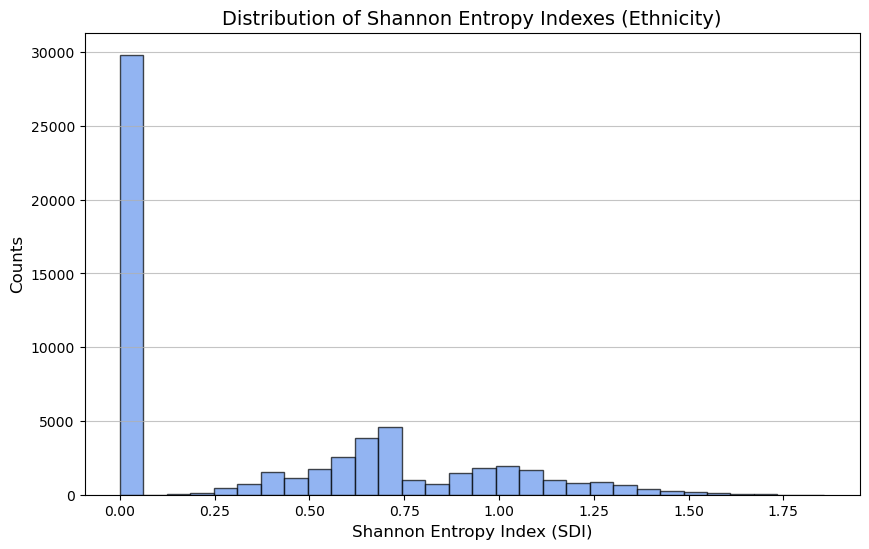

In [115]:
# plotting the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_ethnicity_counts['SDI_ethnicity'], bins=30, **styles['hist_style'])
plt.title('Distribution of Shannon Entropy Indexes (Ethnicity)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

The Shannon Entropy Index (SDI) for actors ethnicity in movies highlights a clear imbalance. From the summary statistics and distribution:

- Dominant Zero Values: A significant portion of the movies (over 50%) have an SDI of 0, meaning no ethnic diversity among the cast.
- Low Overall Mean (0.39): The average SDI remains low, indicating limited ethnic diversity across the dataset.
- Sparse Higher Values: A small subset of movies exhibit higher SDI values, reflecting greater ethnic diversity but occurring infrequently.

The distribution suggests that while some movies feature a diverse cast, the overall trend leans heavily toward minimal or no ethnic diversity.

## 4.3 - Gender score 

Beside ethnicity representation, the gender distribution among movies is a cast characteristic, specific for each movies, that could be useful to analyze.

In [116]:
# grouping by 'region' and 'actor_gender', then count occurrences
region_gender = df_movies_features_exploded.groupby(['region', 'actor_gender']).size().unstack(fill_value=0)

# calculating percentages for each region
region_gender = region_gender.div(region_gender.sum(axis=1), axis=0) * 100

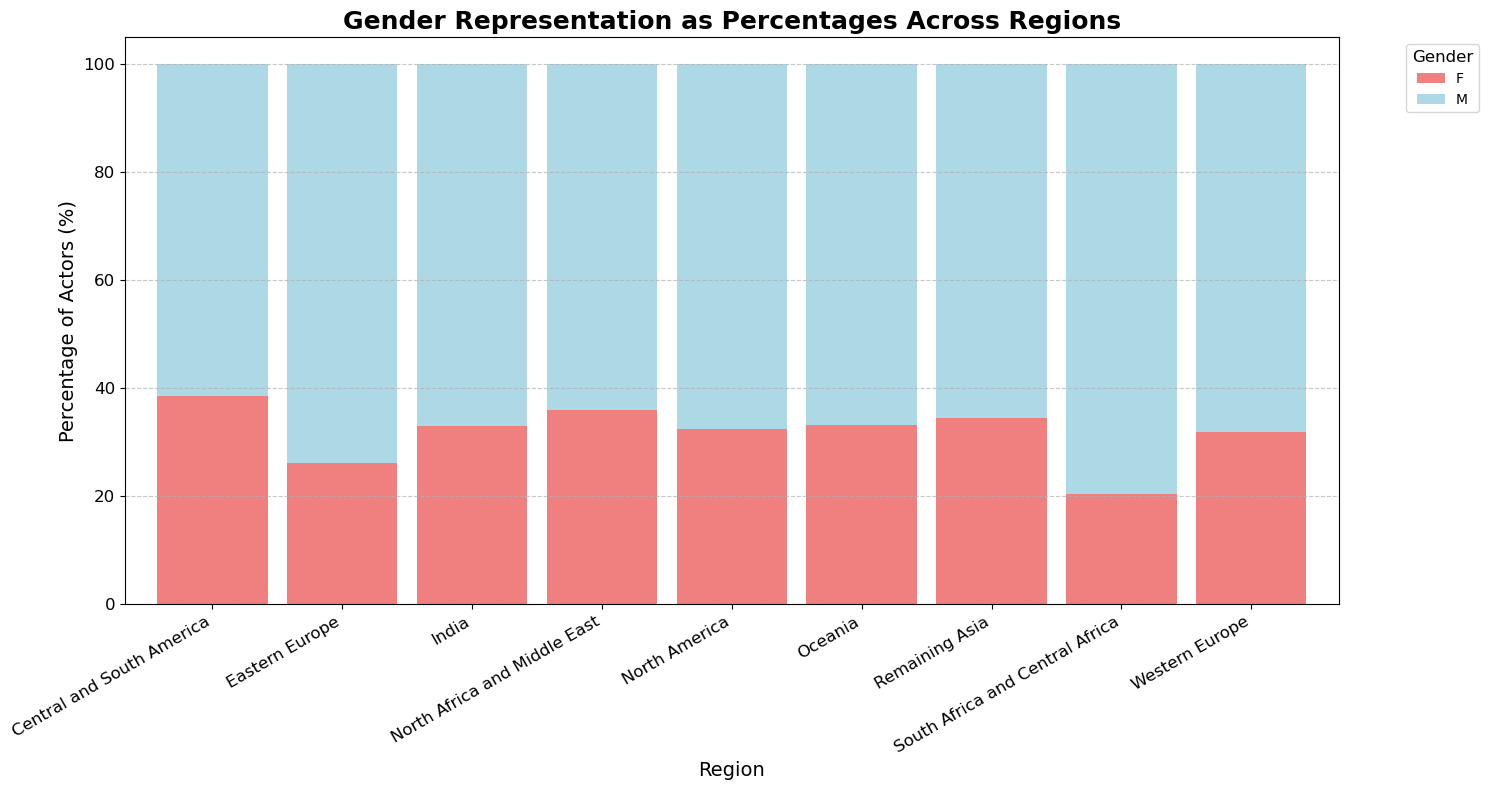

In [117]:
# plotting stacked bar chart with percentages
plt.figure(figsize=(15, 8))
region_gender.plot(
    kind='bar',
    stacked=True,
    color=['lightcoral', 'lightblue'],
    width=0.85,
    ax=plt.gca()
)

plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Gender Representation as Percentages Across Regions", fontsize=18, fontweight='bold')
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

From the above plot, it is evident that the women in movies casts are generally less than men. The average percentage of female actors on total number of actors per movie seems to be less than 40%. The regions with the lowest percentage is 'South Africa and Central Africa'.

In [118]:
# since we will now focus on genders, missing entries in this column must be removed
df_characters_features_gender = df_characters_features.dropna(subset=['actor_gender'])

In [119]:
# computing occurrences of each gender per movie
gender_counts = df_characters_features_gender.groupby(['wikipedia_id', 'actor_gender']).size().reset_index(name='gender_count')

# computing total number of actors per movie
total_actors = df_characters_features_gender.groupby('wikipedia_id').size().reset_index(name='total_actors')

# merging the counts back into a single dataframe
df_gender_counts = gender_counts.merge(total_actors, on='wikipedia_id')

# computing proportions for each gender
df_gender_counts['gender_proportion'] = df_gender_counts['gender_count'] / df_gender_counts['total_actors']

df_gender_counts.head(20) 

wikipedia_id actor_gender  gender_count  total_actors  gender_proportion
0            330            F             4             4           1.000000
1           3217            F             3            13           0.230769
2           3217            M            10            13           0.769231
3           3333            F             6            15           0.400000
4           3333            M             9            15           0.600000
5           3746            F             3            14           0.214286
6           3746            M            11            14           0.785714
7           3837            F             2            20           0.100000
8           3837            M            18            20           0.900000
9           3947            F             5            15           0.333333
10          3947            M            10            15           0.666667
11          4227            F             2            10           0.200000
12          4227            M             8            10           0.800000
13          4231            F             6            16           0.375000
14          4231            M            10            16           0.625000
15          4560            F             2            15           0.133333
16          4560            M            13            15           0.866667
17          4726            F             1            11           0.090909
18          4726            M            10            11           0.909091
19          4727            F             2            21           0.095238

In [120]:
# calculating gender SDI for each movie
df_sdi = df_gender_counts.groupby('wikipedia_id').apply(
    lambda group: characters_features.shannon_entropy(group['gender_proportion'])
).reset_index(name='SDI_gender')

# merging the SDI scores back to the original dataframe
df_gender_counts = df_gender_counts.merge(df_sdi, on='wikipedia_id')

# dropping duplicates for distribution analysis 
df_gender_counts = df_gender_counts.drop_duplicates(subset='wikipedia_id')

# displaying basic statistics
df_gender_counts["SDI_gender"].describe()

C:\Users\bosca\AppData\Local\Temp\ipykernel_4116\3863046563.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi = df_gender_counts.groupby('wikipedia_id').apply(


count    63652.000000
mean         0.445453
std          0.276033
min         -0.000000
25%         -0.000000
50%          0.562335
75%          0.673012
max          0.693147
Name: SDI_gender, dtype: float64

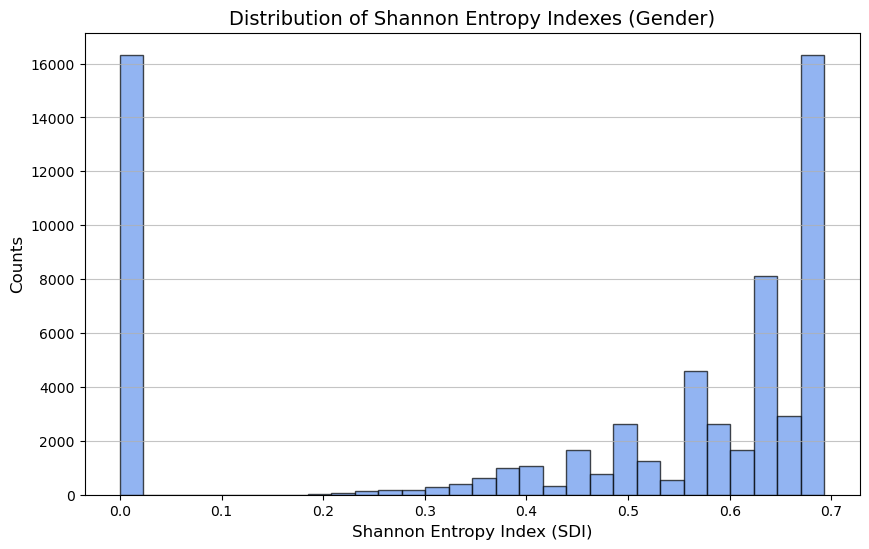

In [121]:
# plotting the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_gender_counts['SDI_gender'], bins=30, **styles['hist_style'])
plt.title('Distribution of Shannon Entropy Indexes (Gender)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

The **Shannon Entropy Index (SDI)** for gender reveals moderate diversity, with many movies showing an SDI of 0, reflecting single-gender casts, often male-dominated in reality. While the mean SDI of 0.45 indicates limited gender balance, higher values around 0.6–0.7 suggest progress in representation for some films. This aligns with ongoing industry efforts to improve gender diversity, though the persistence of imbalance highlights the slow pace of change.

## 4.4 - Shannon scores and ratings

In [122]:
# merging SDI_ethnicity
df_movies_features_unique = df_movies_features_unique.merge(
    df_ethnicity_counts[['wikipedia_id', 'SDI_ethnicity']],
    on='wikipedia_id',
    how='left'
)

# merging SDI_gender and GPR
df_movies_features_unique = df_movies_features_unique.merge(
    df_gender_counts[['wikipedia_id', 'SDI_gender']],
    on='wikipedia_id',
    how='left'
)

### 4.4.1 - SDI ethnicity and ratings

The large size of our dataset (32.621 entries) might lead to declare significant even trivial relationships. To better assess the relationship between the ethnicity score of a movie and its average rating, we will sample the unique dataframe and explore whether this yields meaningful insights.

In [123]:
# sampling the unique dataframe
df_sampled = df_movies_features_unique[['SDI_ethnicity', 'averageRating']].dropna().sample(n=7000, random_state=42)
df_sampled = df_sampled[['averageRating', 'SDI_ethnicity']].dropna()

# computing Pearson and Spearman correlations
pearson_corr, pearson_p = pearsonr(df_sampled['SDI_ethnicity'], df_sampled['averageRating'])
spearman_corr, spearman_p = spearmanr(df_sampled['SDI_ethnicity'], df_sampled['averageRating'])

# printing results
print(f"Pearson: Correlation = {pearson_corr:.4f}, p-value = {pearson_p:.4f}")
print(f"Spearman: Correlation = {spearman_corr:.4f}, p-value = {spearman_p:.4f}")

Pearson: Correlation = -0.0430, p-value = 0.0003
Spearman: Correlation = -0.0504, p-value = 0.0000


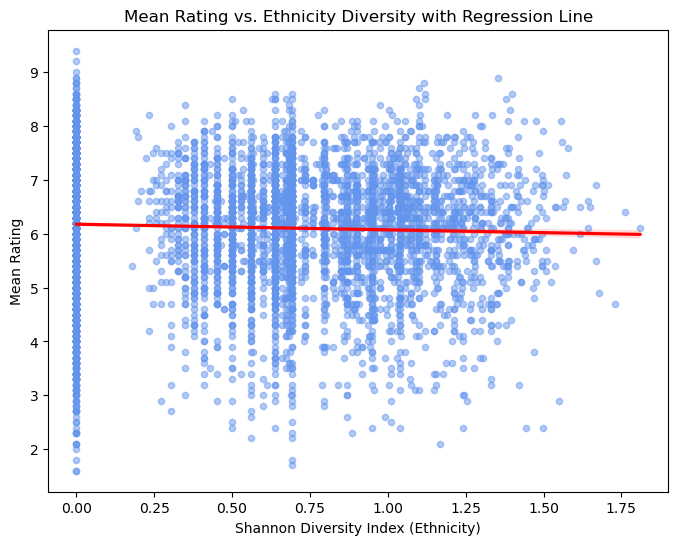

In [124]:
# scatter plot
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_ethnicity', 
    y='averageRating', 
    data=df_sampled, 
    scatter_kws=styles['scatter_style'], 
    line_kws=styles['line_style']
)
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Ethnicity Diversity with Regression Line')
plt.show()

Thanks to the Pearson and Spearman correlations, with low p-values, a slightly negative correlation is highlighted. Moreover, by plotting the mean rating vs the shannon diversity index for ethnicity and its regression line, we can see that the slope is slightly negative.
The code below is used to visualize a Q-Q plot to assess normality and a boxplot to assess the homogeneity of variance.

In [125]:
# binning ethnicities into 4 groups in terms of DSI index to compare their mean ratings
bin_edges = [-0.01, 0.0, 0.5, 1.0, 2.0]
bin_labels = ["Zero", "Low", "Medium", "High"]

df_sampled['ethnicity_group'] = pd.cut(
    df_sampled['SDI_ethnicity'], 
    bins=bin_edges, 
    labels=bin_labels,
    include_lowest=True
)

# checking the distribution of the bins
print(df_sampled['ethnicity_group'].value_counts())

ethnicity_group
Zero      3045
Medium    2367
High      1041
Low        547
Name: count, dtype: int64


In [126]:
# extracting ratings for each group to assess ANOVA p-value
group_zero = df_sampled[df_sampled['ethnicity_group'] == 'Zero']['averageRating']
group_low = df_sampled[df_sampled['ethnicity_group'] == 'Low']['averageRating']
group_medium = df_sampled[df_sampled['ethnicity_group'] == 'Medium']['averageRating']
group_high = df_sampled[df_sampled['ethnicity_group'] == 'High']['averageRating']

# f_oneway() call for ANOVA p-value
_, p_anova = f_oneway(group_zero, group_low, group_medium, group_high)
print(f"ANOVA p-value: {p_anova:.4f}")


ANOVA p-value: 0.0025


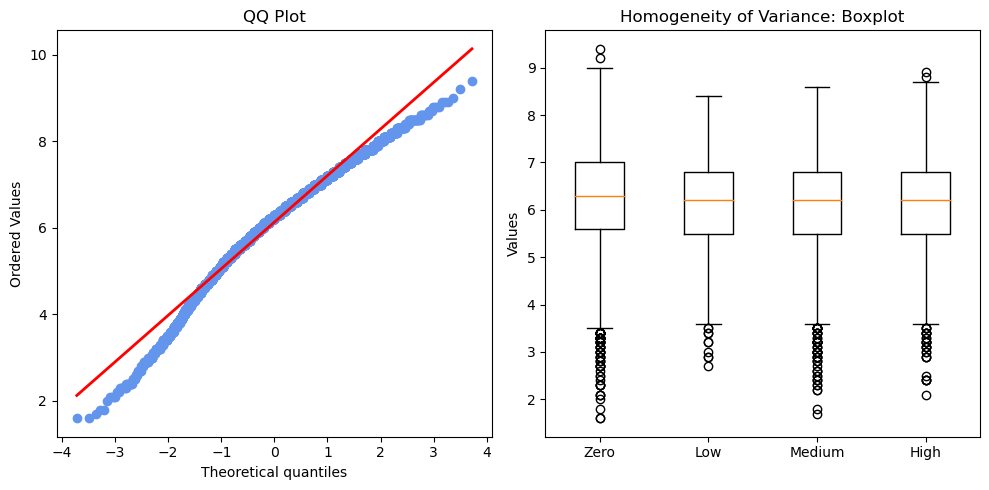

In [127]:
# combining with order all groups to prepare data for QQ plot
groups_combined = np.concatenate([group_zero, group_low, group_medium, group_high])

# preparing figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# QQ Plot
stats.probplot(groups_combined, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot")

# line settings
axes[0].get_lines()[0].set_color('cornflowerblue') 
axes[0].get_lines()[0].set_linewidth(2)
axes[0].get_lines()[1].set_color('red') 
axes[0].get_lines()[1].set_linewidth(2)

# boxplot for variance visualization
axes[1].boxplot([group_zero, group_low, group_medium, group_high], labels=["Zero", "Low", "Medium", "High"])
axes[1].set_title("Homogeneity of Variance: Boxplot")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

The null hypothesis for ANOVA states that the mean ratings across all four ethnicity groups ("Zero," "Low," "Medium," "High") are equal. Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant difference in mean ratings among at least one of the groups.

### 4.4.2 - SDI gender and ratings

After the SDI related to ethnicities analysis, the SDI related to gender undergoes the same analysis and reasonings to justify its use.

In [128]:
# sampling the unique dataframe
df_sampled = df_movies_features_unique[['SDI_gender', 'averageRating']].dropna().sample(n=7000, random_state=42)
df_sampled = df_sampled[['averageRating', 'SDI_gender']].dropna()

# computing Pearson and Spearman correlations
pearson_corr, pearson_p = pearsonr(df_sampled['SDI_gender'], df_sampled['averageRating'])
spearman_corr, spearman_p = spearmanr(df_sampled['SDI_gender'], df_sampled['averageRating'])

# printing results
print(f"Pearson: Correlation = {pearson_corr:.4f}, p-value = {pearson_p:.4f}")
print(f"Spearman: Correlation = {spearman_corr:.4f}, p-value = {spearman_p:.4f}")

Pearson: Correlation = -0.0450, p-value = 0.0002
Spearman: Correlation = -0.0453, p-value = 0.0001


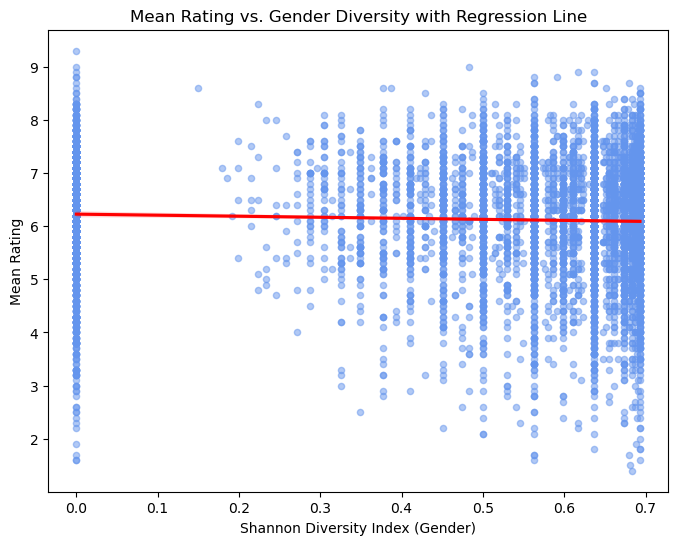

In [129]:
# scatter plot
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_gender', 
    y='averageRating', 
    data=df_sampled, 
    scatter_kws=styles['scatter_style'], 
    line_kws=styles['line_style']
)
plt.xlabel('Shannon Diversity Index (Gender)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Gender Diversity with Regression Line')
plt.show()

Just like for the previous score, both the Pearson and Spearman correlation are negative, with a low p-value, highlighting the negative correlation between the mean rating and the gender diversity. The same conclusion can obviously be retrieved by the graph.
The code below is used to visualize a Q-Q plot to assess normality and a boxplot to assess the homogeneity of variance.

In [130]:
# splitting SDI_genders into two groups to perform ANOVA testing
group_low = df_sampled[df_sampled['SDI_gender'] <= 0.5]['averageRating']
group_high = df_sampled[df_sampled['SDI_gender'] > 0.5]['averageRating']

# f_oneway() call for ANOVA p-value
_, p_anova = f_oneway(group_low, group_high)
print(f"ANOVA p-value: {p_anova:.4f}")

ANOVA p-value: 0.0001


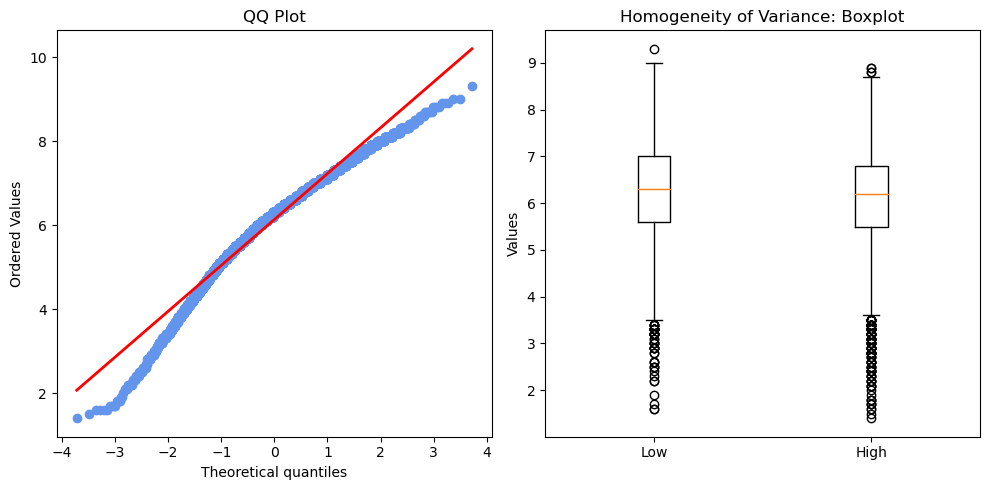

In [131]:
# combining with order all groups to prepare data for QQ plot
groups_combined = np.concatenate([ group_low ,group_high])

# preparing figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# QQ Plot
stats.probplot(groups_combined, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot")

# line settings
axes[0].get_lines()[0].set_color('cornflowerblue') 
axes[0].get_lines()[0].set_linewidth(2)
axes[0].get_lines()[1].set_color('red') 
axes[0].get_lines()[1].set_linewidth(2)

# boxplot for variance visualization
axes[1].boxplot([group_low, group_high], labels=["Low", "High"])
axes[1].set_title("Homogeneity of Variance: Boxplot")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

## 4.5 Number of spoken languages 

Another factor that can reflect a movie's **diversity and global appeal** is the **number of spoken languages** featured in it. Analyzing this can provide insights into how linguistic diversity might influence audience ratings.

In [132]:
# dropping rows where spoken_languages is NaN
df_movies_features_lang = df_movies_features_unique.dropna(subset=['spoken_languages'])

# dropping rows where spoken_languages is an empty list
df_movies_features_lang = df_movies_features_lang[
    df_movies_features_lang['spoken_languages'].apply(lambda x: len(x) > 0)
]

# counting the number of languages per movie
df_movies_features_lang['nb_languages'] = df_movies_features_lang['spoken_languages'].apply(len)

# dropping rows with missing values in 'mean_rating' or 'nb_languages'
df_movies_features_lang = df_movies_features_lang.dropna(subset=['averageRating', 'nb_languages'])

In [133]:
# computing Pearson correlation
pearson_corr, pearson_p = pearsonr(df_movies_features_lang['nb_languages'], df_movies_features_lang['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# computing Spearman correlation
spearman_corr, spearman_p = spearmanr(df_movies_features_lang['nb_languages'], df_movies_features_lang['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: 0.0969, p-value: 0.0000
Spearman correlation: 0.0749, p-value: 0.0000


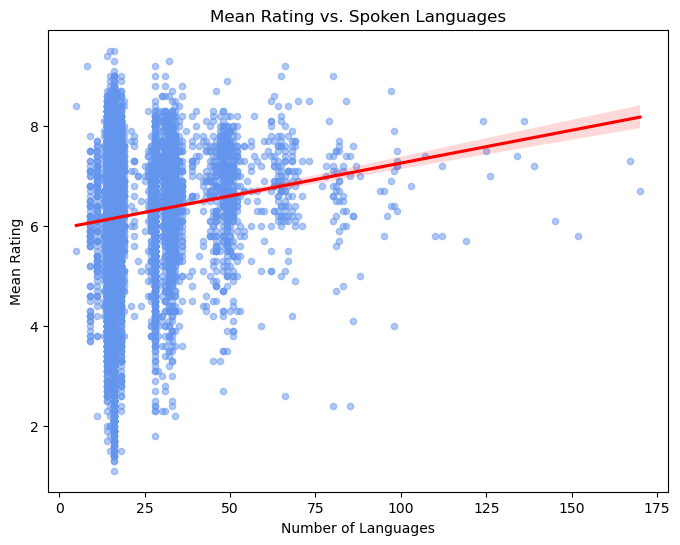

In [134]:
# scatter plot
plt.figure(figsize=(8,6))
sns.regplot(
    x='nb_languages', 
    y='averageRating', 
    data=df_movies_features_lang, 
    scatter_kws=styles['scatter_style'], 
    line_kws=styles['line_style']
)
plt.xlabel('Number of Languages')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Spoken Languages')
plt.show()

Spearman and Pearson correlation tests both yield extremely low p-values (effectively 0), yet the corresponding correlation coefficients remain relatively low. This indicates there may be meaningful relationships that are not fully captured by simple linear or monotonic assumptions. To investigate this further, we perform an ANOVA comparing ratings between two groups: individuals who speak fewer than 15 languages and those who speak 15 or more.

An equivalent ANOVA analysis as the previous ones will now be performed also on this feature.

In [135]:
# plitting nb_languages into two groups
group_low = df_movies_features_lang[df_movies_features_lang['nb_languages'] <= 15]['averageRating']
group_high = df_movies_features_lang[df_movies_features_lang['nb_languages'] > 15]['averageRating']

# f_oneway() call for ANOVA p-value
_, p_anova = f_oneway(group_low, group_high)
print(f"ANOVA p-value: {p_anova:.4f}")

ANOVA p-value: 0.0174


P-value of Anova proves once again the effect of spoken languages on the The resulting p-value from the ANOVA confirms that the number of spoken languages significantly affects the ratings.

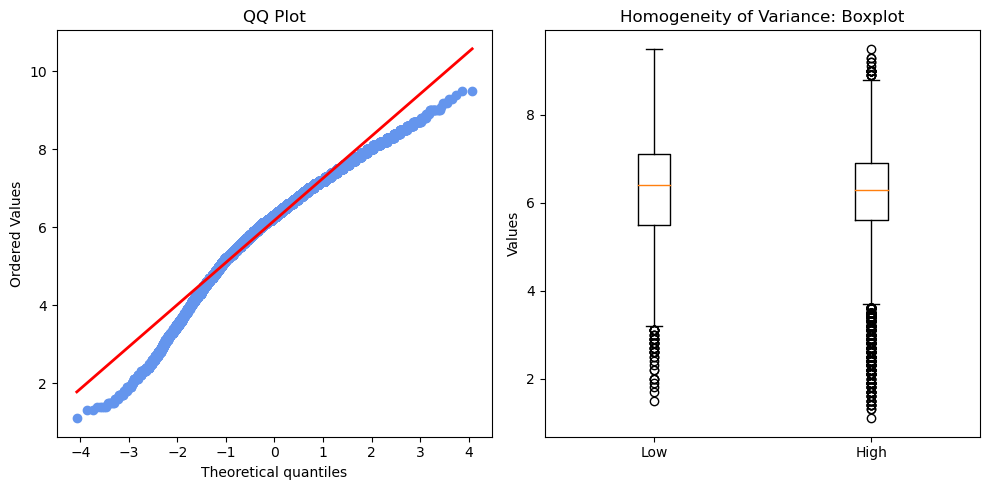

In [136]:
# combining with order all groups to prepare data for QQ plot
groups_combined = np.concatenate([ group_low ,group_high])

# preparing figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# QQ Plot
stats.probplot(groups_combined, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot")

# line settings
axes[0].get_lines()[0].set_color('cornflowerblue') 
axes[0].get_lines()[0].set_linewidth(2)
axes[0].get_lines()[1].set_color('red') 
axes[0].get_lines()[1].set_linewidth(2)

# boxplot for variance visualization
axes[1].boxplot([group_low, group_high], labels=["Low", "High"])
axes[1].set_title("Homogeneity of Variance: Boxplot")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

Although the Q–Q plot and boxplots suggest that normality and homogeneity of variance may not be perfectly met, we will proceed under these assumptions for the purposes of this analysis.

Since the next two sections (4.6 and 4.7) regard features that will be surely added to the model, the dataframes copies for section 5 will be created now and the new features will be directly defined in them.

In [137]:
# copies of the master dataframes to proceed with the analysis
df_movies_model = df_movies_ratings_imdb.copy()
df_characters_model = df_characters.copy()

## 4.6 - Historical proximity score

Before proceeding with the classification model, a final interesting observation can be made. That is, how do historical events influence movies production? For this reason, a feature called `historical_proximity_score` will be defined. In particular, entries are in range [-1, 1]. Taking into account that a movie takes minimum a year to produce (in general), if a meaningful historical event happens, a score of 1 is given to the exact year of the event and the year later, then the score decreases by 0.2 each year. Therefore, an historical event has a decreasing impact on movies for the next 5 years. If the event is positive, the score is positive, viceversa if the event is negative.

The historical proximity score will be added in a column specified to it in our master data frame. 

In [138]:
# saving df_movies_tmdb_ratings as a pickle file
output_path = Path("src/scripts/df_movies_model.pkl")
df_movies_model.to_pickle(output_path)

# running historical_proximity.py script
result = subprocess.run(["python", "src/scripts/historical_proximity.py"], capture_output=True, text=True)

# if the script failed, print the error message
if result.returncode != 0:
    print("Error occurred:")
    print(result.stderr)
else:
    print("Script ran successfully.")

# loading historical_proximity_score
historical_proximity_score = pd.read_pickle("src/scripts/historical_proximity_score.pkl")

Script ran successfully.


In [139]:
# adding historical_proximity_score column
df_movies_model['historical_proximity_score'] = df_movies_model.apply(
    lambda row: add_features.get_historical_proximity_score(row, historical_proximity_score), axis=1
)

## 4.7 - Genre complexity score

Over time, genres evolved and more complex genre combinations emerged. To measure this complexity, we counted the number of genres associated with each movie. Because we maintained the data frame exploded on genres this calculation was straightforward.

In [140]:
# grouping the data by 'genre_count' to calculate count and mean rating
complexity_stats = (
    df_movies_model.groupby('genre_count')
    .agg(count=('averageRating', 'size'), mean_rating=('averageRating', 'mean'))
    .reset_index()
)

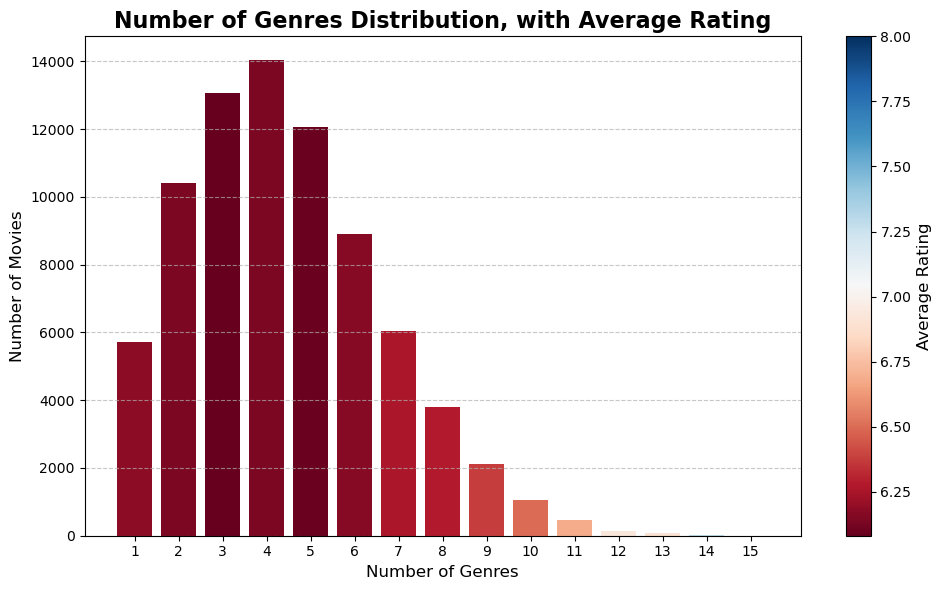

In [141]:
# creating the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# selecting current colormap
cmap = plt.cm.RdBu
norm = plt.Normalize(complexity_stats['mean_rating'].min(), complexity_stats['mean_rating'].max())

bars = ax.bar(
    complexity_stats['genre_count'], 
    complexity_stats['count'], 
    color=[cmap(norm(rating)) for rating in complexity_stats['mean_rating']]
)

# adding color bar for the mean rating
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Average Rating", fontsize=12)

ax.set_title("Number of Genres Distribution, with Average Rating", fontsize=16, weight='bold')
ax.set_xlabel("Number of Genres", fontsize=12)
ax.set_ylabel("Number of Movies", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# changing x-axis ticks
ax.set_xticks(complexity_stats['genre_count'])
ax.set_xticklabels(complexity_stats['genre_count'].astype(int))

plt.tight_layout()
plt.show()

The plot shows that movies tend to have 3 to 5 genres with average ratings being around 6.25 . More complex films although less frequent also tend to have slightly higher average ratings.

# 5 - Classification model

After completing the feature engineering steps and setting binned_ratings (dwhy binned ratings when we explain which model maybe or now  ) as our target variable, we consolidate all the processed information into a single DataFrame, df_movies_model. This DataFrame includes both numerical and categorical features derived from the original movie dataset. To enable a classification model to predict the rating category of each movie, we treat features such as 'release_date', 'genres', 'genre_count', 'region', 'nb_actors', and 'nb_languages' as categorical variables and apply one-hot encoding to them.

In [142]:
# adding 'nb_actors'
df_movies_model['nb_actors'] = df_movies_model['wikipedia_id'].map(actors_per_movie)

# adding 'SDI_ethnicity'
df_movies_model = df_movies_model.merge(
    df_ethnicity_counts[['wikipedia_id', 'SDI_ethnicity']],
    on='wikipedia_id',
    how='left'
)

# adding 'SDI_gender'
df_movies_model = df_movies_model.merge(
    df_gender_counts[['wikipedia_id', 'SDI_gender']],
    on='wikipedia_id',
    how='left'
)

# dropping rows where spoken_languages is nan
df_movies_model = df_movies_model.dropna(subset=['spoken_languages'])

# dropping rows where spoken_languages is an empty list
df_movies_model = df_movies_model[
    df_movies_model['spoken_languages'].apply(lambda x: len(x) > 0)
]

# adding 'nb_languages'
df_movies_model['nb_languages'] = df_movies_model['spoken_languages'].apply(len)

# adding 'binned_rating' column as the target
df_movies_model['binned_rating'] = df_movies_model['averageRating'].round()

In [143]:
# keeping only some features and specifing the target variable
features = df_movies_model[
    [
        'release_date',
        'revenue',
        'runtime',
        'genres',
        'budget',
        'genre_count',
        'region',
        'historical_proximity_score',
        'SDI_ethnicity',
        'SDI_gender',
        'nb_actors',
        'nb_languages'
    ]
]

target = df_movies_model[['binned_rating']]

# encoding target variable to discrete classes
encoder = LabelEncoder()
target = encoder.fit_transform(target)

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [144]:
# one-hot encoding of some features that need this treatment
features = pd.get_dummies(features, columns=['release_date', 'genres', 'genre_count', 'region', 'nb_actors', 'nb_languages'], drop_first=True)

A 80-20 train-test split was used to divide the data into training and testing subsets. The Random Forest is then trained on 58,430 samples, fine-tuning its predictive capabilities through ten-fold cross-validation. This step not only validates the model’s performance but also ensures resilience to overfitting.

In [145]:
# train-test split 80-20 ratio
df_train, df_test, df_train_target, df_test_target = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42
)

# printing train and test sizes
print(f'The number of samples in the train dataset is: {len(df_train)}')
print(f'The number of samples in the test dataset is: {len(df_test)}')

The number of samples in the train dataset is: 58430
The number of samples in the test dataset is: 14608


We chose the classifier to be a Random Forest classifier to handle the blend of categorical and numerical features. Random Forests also provide insight into which factors most influence the predicted rating categories. 

In [146]:
# creating the model
random_forest = RandomForestClassifier()

# training the model
random_forest.fit(df_train, df_train_target)

# cross-validating features
scores = cross_val_score(random_forest, df_train, df_train_target, cv=10)

# computing the 95% CI (since cv=10, t-Student parameter is adopted)
SE = scores.std() / np.sqrt(10)

# t-score for 95% CI with 9 degrees of freedom (n-1, n=10)
t_score = stats.t.ppf(0.975, df=9)

# printing results
print(f"The mean accuracy is {scores.mean():.4f} ± {t_score*SE:.4f}")

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


The mean accuracy is 0.7532 ± 0.0023


In [147]:
# prediction on testing set
target_predict = random_forest.predict(df_test)

# printing accuracy scores
accuracy = accuracy_score(df_test_target, target_predict)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.758


In [148]:
# retrieving feature importances
importances = random_forest.feature_importances_

# creating a DataFrame with feature names and importances
df_importances = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
})

# cleaning features names
df_importances['Features'] = df_importances['Feature'].apply(cleaning.extract_category)

# grouping by the features, summing and sorting values
importances_extracted = df_importances.groupby('Features', as_index=False).agg({'Importance': 'sum'})
importances_extracted = importances_extracted.sort_values(by='Importance', ascending=False)

C:\Users\bosca\AppData\Local\Temp\ipykernel_4116\2274882583.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Features', data=importances_extracted, orient='h', palette=palette)


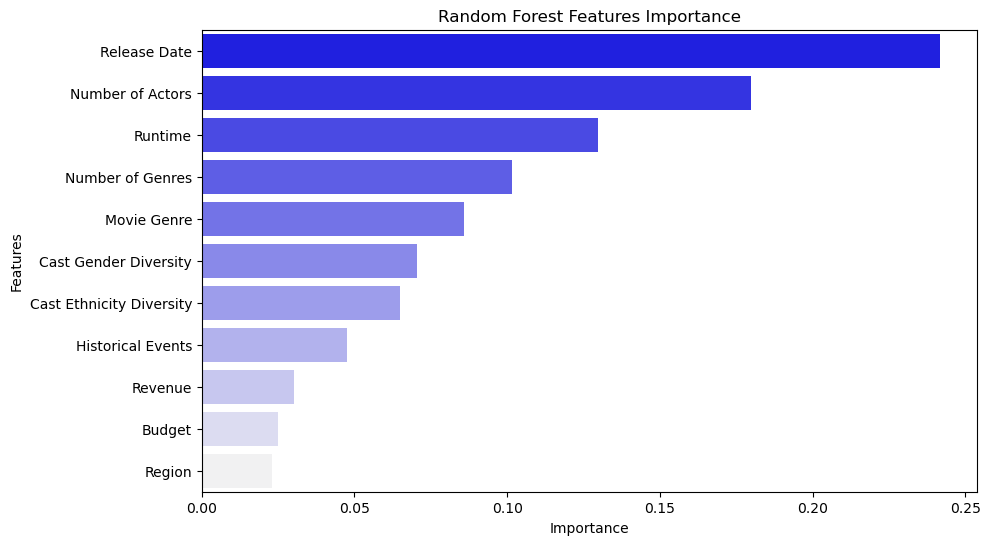

In [149]:
# renaming the indices (features) for graph readability
importances_extracted['Features'] = ['Release Date', 'Number of Actors', 'Runtime', 'Number of Genres', 'Movie Genre', 
                            'Cast Gender Diversity', 'Cast Ethnicity Diversity', 'Historical Events', 'Revenue',
                            'Budget', 'Region']

# preparing bar plot
plt.figure(figsize=(10, 6))

# selecting color palette
palette = sns.light_palette("blue", reverse=True, n_colors=len(importances_extracted))
sns.barplot(x='Importance', y='Features', data=importances_extracted, orient='h', palette=palette)

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Features Importance')

plt.show()

Building on our initial exploratory and statistical assessments, the Random Forest model confirms the relationships identified earlier through both parametric and non-parametric tests. Preliminary ANOVA results revealed statistically significant interactions among key factors such as release date, regions, and genres, suggesting that both short- and long-term temporal trends significantly influence audience reception. Complementing these findings, ARIMA modeling on region-level time series data, aggregated into 5-year bins for the top 20 genres, hinted at the importance of timing, despite yielding mixed results.

Further data exploration uncovered a wider range of predictors, including casting attributes, runtime, and diversity metrics. Our Random Forest classifier therefore leverages these insights by capturing complex, non-linear relationships. Its classification accuracy of approximately 75% cross-validated and 76.4% on unseen data—demonstrates the robustness of this approach.

The result is more than just a predictive model; it provides a deeper understanding of how temporal context, casting, film characteristics, and cultural trends intersect to shape audience ratings.